#Starter

# INSTALL LIBRARY

In [3]:
!pip install contextily
!pip install mgwr
!pip install linearmodels
!pip install mapclassify
!pip install statsmodels
# !pip install pmdarima


# IMPORT LIBRARY

In [4]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily
from mgwr.gwr import GWR

from mgwr.sel_bw import Sel_BW
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from linearmodels import PooledOLS
from linearmodels import PanelOLS
from linearmodels import RandomEffects
import statsmodels.api as sm
import numpy.linalg as la
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score


In [5]:
# Load Panel Dataset
datas = pd.read_excel(
    "/kaggle/input/data-gwpr/22052025 Data Gula (tahun kedua)  inflasi.xlsx", sheet_name='DATA'
)
# datas = datas.sort_values(by=['Year','Month','Province'])
# datas['YearMonth'] = pd.to_numeric(datas['Year'].apply('{:0>4}'.format) + datas['Month'].apply('{:0>2}'.format))
# S_price = MinMaxScaler()
# S_production = MinMaxScaler()
# S_importation = MinMaxScaler()
# S_demand = MinMaxScaler()

# datas['Price'] = S_price.fit_transform(datas['Price'].values.reshape(-1,1))
# datas['Production'] = S_price.fit_transform(datas['Production'].values.reshape(-1,1))
# datas['Importation'] = S_price.fit_transform(datas['Importation'].values.reshape(-1,1))
# datas['Demand'] = S_price.fit_transform(datas['Demand'].values.reshape(-1,1))

# datas.head()
datas = datas.drop(['No','Latitude', 'Longitude', 'Inflation', 'Economy Growth (%)'],axis=1)
datas['Province'] = datas['Province'].replace({
    'Bangka Belitung': 'Bangka-Belitung',
    'Jakarta': 'Jakarta Raya'
})

datas

Province  Year  Month  Production  Importation  Demand  Supply    Price  \
0        Aceh  2013      1         0.0          0.0  3262.0     0.0  12500.0   
1        Aceh  2013      2         0.0          0.0  3127.0     0.0  12500.0   
2        Aceh  2013      3         0.0          0.0  3223.0     0.0  12500.0   
3        Aceh  2013      4         0.0          0.0  4188.0     0.0  12000.0   
4        Aceh  2013      5         0.0          0.0  5076.0     0.0  12659.0   
...       ...   ...    ...         ...          ...     ...     ...      ...   
4075    Papua  2022      8         0.0          0.0  2460.0     0.0  16120.0   
4076    Papua  2022      9         0.0          0.0  5308.0     0.0  15846.0   
4077    Papua  2022     10         0.0          0.0  2538.0     0.0  15425.0   
4078    Papua  2022     11         0.0          0.0  4808.0     0.0  16357.0   
4079    Papua  2022     12         0.0          0.0  3470.0     0.0  16473.0   

      Population  Religious Holiday  
0        4811100                  0  
1        4811100                  0  
2        4811100                  0  
3        4811100                  0  
4        4811100                  0  
...          ...                ...  
4075     4418600                  0  
4076     4418600                  0  
4077     4418600                  0  
4078     4418600                  0  
4079     4418600                  1  

[4080 rows x 10 columns]

# EXPLORATORY DATA ANALYSIS

## 1) NAN VALUES

In [6]:
datas.isna().sum()

Province             0
Year                 0
Month                0
Production           1
Importation          0
Demand               1
Supply               1
Price                1
Population           0
Religious Holiday    0
dtype: int64

## 2) SUPPLY VS DEMAND (RATA - RATA 10 TAHUN TERAKHIR)

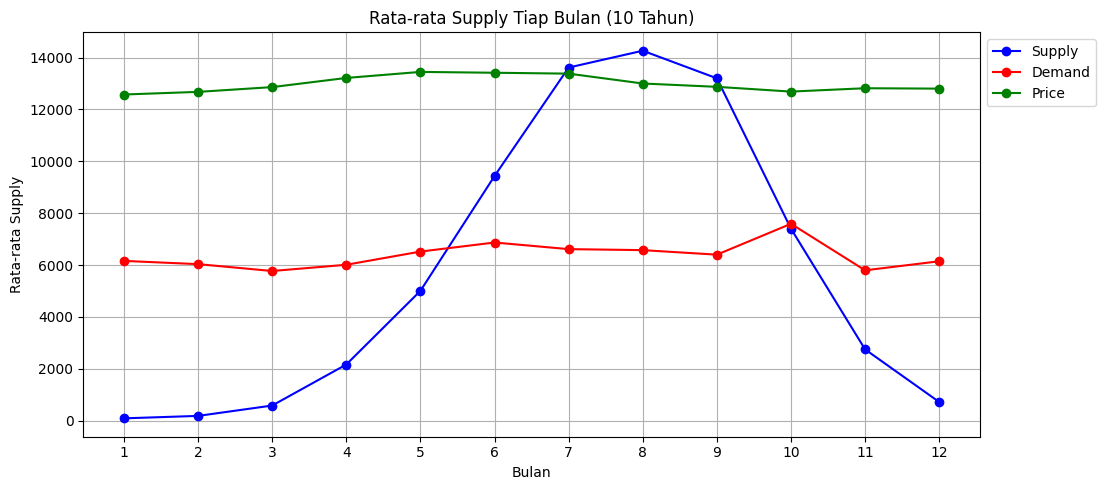

In [7]:
avg_supply_per_month = datas.groupby("Month")["Supply"].mean()
avg_demand_per_month = datas.groupby("Month")["Demand"].mean()
avg_price_per_month = datas.groupby("Month")["Price"].mean()
# Plot
plt.figure(figsize=(10, 5))
plt.plot(avg_supply_per_month.index, avg_supply_per_month.values, marker='o', linestyle='-', color='b',label='Supply')
plt.plot(avg_demand_per_month.index, avg_demand_per_month.values, marker='o', linestyle='-', color='r',label='Demand')
plt.plot(avg_price_per_month.index, avg_price_per_month.values, marker='o', linestyle='-', color='g',label='Price')
plt.title("Rata-rata Supply Tiap Bulan (10 Tahun)")
plt.xlabel("Bulan")
plt.ylabel("Rata-rata Supply")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

## 3) IMPORTATION VS PRODUCTION VS DEMAND (RATA RATA PER TAHUN)

In [8]:
datas['Year'].unique()
jumlah_per_tahun =datas['Year'].value_counts().sort_index()

print(jumlah_per_tahun)

Year
2013    408
2014    408
2015    408
2016    408
2017    408
2018    408
2019    408
2020    408
2021    408
2022    408
Name: count, dtype: int64


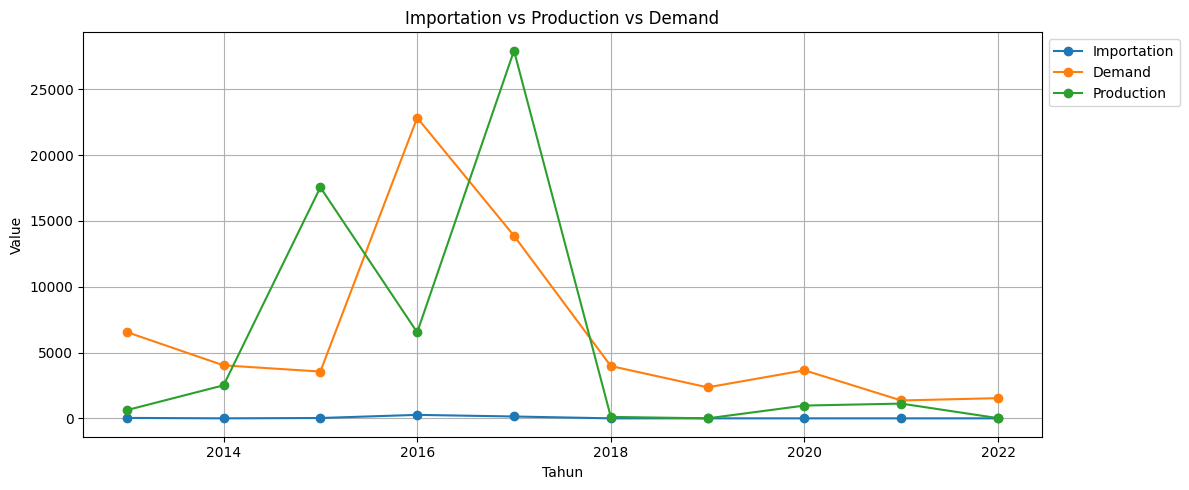

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Misalnya kamu sudah punya DataFrame `datas` berisi 4080 baris (10 tahun × 408)
# Buat list tahun berulang sebanyak 408 kali per tahun
years = list(range(2013, 2023))  # 2013–2022
datas['Year'] = [year for year in years for _ in range(408)]

# Hitung rata-rata per tahun
grouped = datas.groupby('Year')[['Importation', 'Demand', 'Production']].mean()

# Plot rata-rata tahunan
plt.figure(figsize=(12, 5))

plt.plot(grouped.index, grouped['Importation'], marker='o', label='Importation')
plt.plot(grouped.index, grouped['Demand'], marker='o', label='Demand')
plt.plot(grouped.index, grouped['Production'], marker='o', label='Production')
plt.xlabel("Tahun")
plt.ylabel("Value")
plt.title("Importation vs Production vs Demand")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


## 5) PRICE RATA RATA PER TAHUN

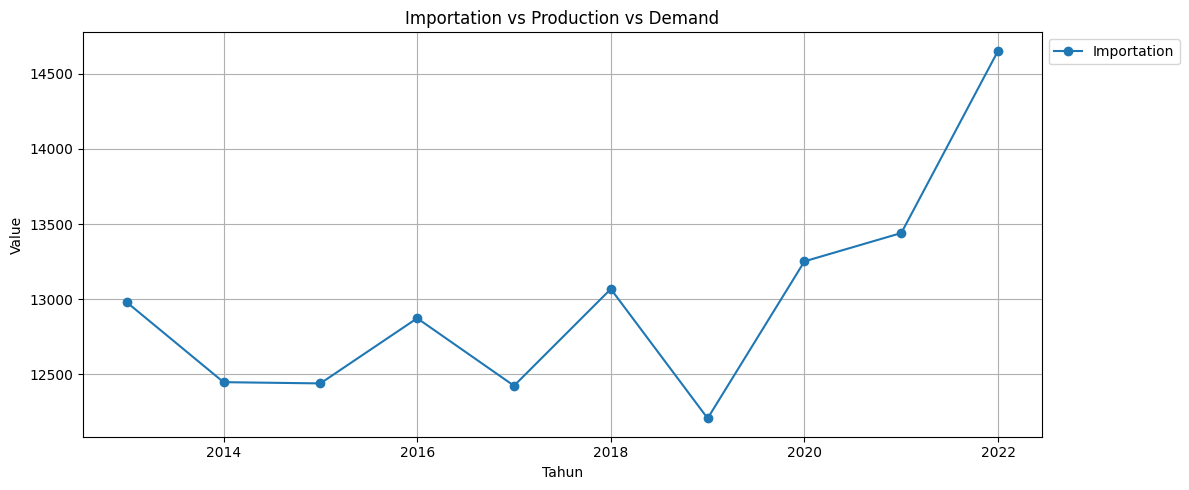

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Misalnya kamu sudah punya DataFrame `datas` berisi 4080 baris (10 tahun × 408)
# Buat list tahun berulang sebanyak 408 kali per tahun
years = list(range(2013, 2023))  # 2013–2022
datas['Year'] = [year for year in years for _ in range(408)]

# Hitung rata-rata per tahun
grouped = datas.groupby('Year')[['Price']].mean()

# Plot rata-rata tahunan
plt.figure(figsize=(12, 5))

plt.plot(grouped.index, grouped['Price'], marker='o', label='Importation')
plt.xlabel("Tahun")
plt.ylabel("Value")
plt.title("Importation vs Production vs Demand")
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()


## 6) SCATTER PLOT

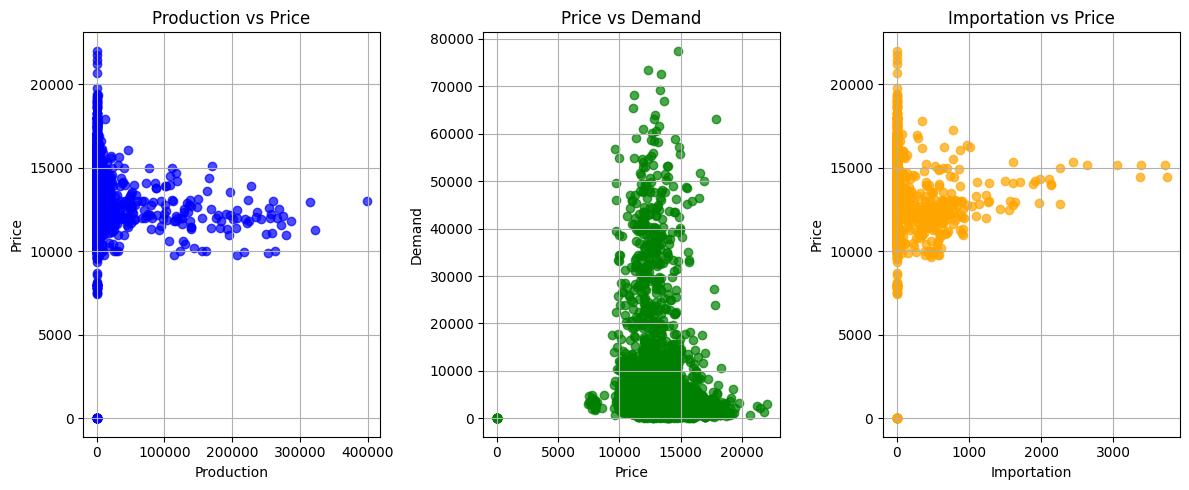

In [11]:
import matplotlib.pyplot as plt

# Asumsikan datas memiliki kolom: 'Production', 'Price', 'Demand', 'Importation'

plt.figure(figsize=(12, 5))

# 1. Production vs Price
plt.subplot(131)
plt.scatter(datas['Production'], datas['Price'], alpha=0.7, color='blue')
plt.xlabel("Production")
plt.ylabel("Price")
plt.title("Production vs Price")
plt.grid(True)

# 2. Price vs Demand
plt.subplot(132)
plt.scatter(datas['Price'], datas['Demand'], alpha=0.7, color='green')
plt.xlabel("Price")
plt.ylabel("Demand")
plt.title("Price vs Demand")
plt.grid(True)

# 3. Importation vs Price
plt.subplot(133)
plt.scatter(datas['Importation'], datas['Price'], alpha=0.7, color='orange')
plt.xlabel("Importation")
plt.ylabel("Price")
plt.title("Importation vs Price")
plt.grid(True)

plt.tight_layout()
plt.show()


## 7) CORRELATION FEATURES

In [12]:
fitur = datas[['Production','Importation','Demand','Supply','Price','Population','Religious Holiday']]
fitur

Production  Importation  Demand  Supply    Price  Population  \
0            0.0          0.0  3262.0     0.0  12500.0     4811100   
1            0.0          0.0  3127.0     0.0  12500.0     4811100   
2            0.0          0.0  3223.0     0.0  12500.0     4811100   
3            0.0          0.0  4188.0     0.0  12000.0     4811100   
4            0.0          0.0  5076.0     0.0  12659.0     4811100   
...          ...          ...     ...     ...      ...         ...   
4075         0.0          0.0  2460.0     0.0  16120.0     4418600   
4076         0.0          0.0  5308.0     0.0  15846.0     4418600   
4077         0.0          0.0  2538.0     0.0  15425.0     4418600   
4078         0.0          0.0  4808.0     0.0  16357.0     4418600   
4079         0.0          0.0  3470.0     0.0  16473.0     4418600   

      Religious Holiday  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  
...                 ...  
4075                  0  
4076                  0  
4077                  0  
4078                  0  
4079                  1  

[4080 rows x 7 columns]

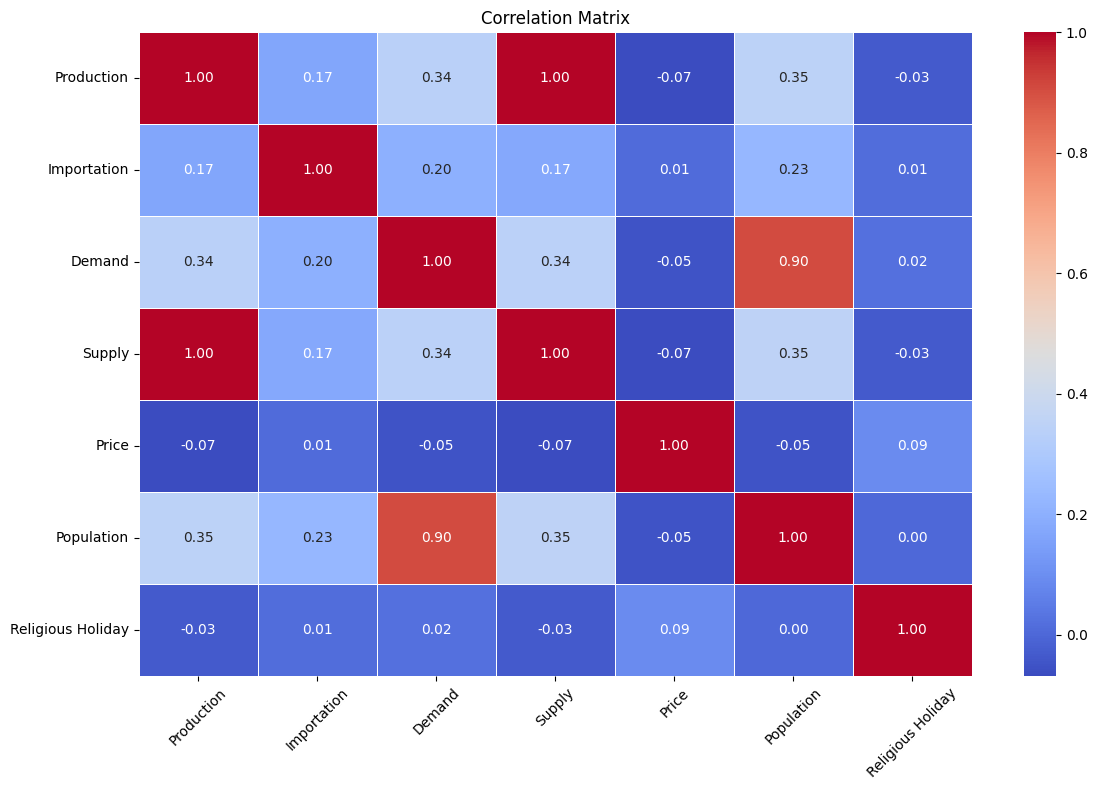

In [13]:
plt.figure(figsize=(12, 8))
sns.heatmap(fitur.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Asumsikan df adalah DataFrame kamu
# sns.pairplot(fitur)
# plt.suptitle("Pairwise Scatter Plots", y=1.02)
# plt.show()


In [15]:
# # prompt: datas ubah 0 menjadi np.nan

# import numpy as np
# datas = datas.replace(0, np.nan)


# PROCESSING

## 1) IMPUTER FOR NAN VALUES

In [16]:
# prompt: knn imputer colomn Production, Importation,Demand,Price, dengan nilai N = 3

from sklearn.impute import KNNImputer

# Select columns to impute
cols_to_impute = ['Production', 'Demand', 'Supply', 'Price']

# Create KNNImputer object
imputer = KNNImputer(n_neighbors=3)

# Fit and transform the selected columns
datas[cols_to_impute] = imputer.fit_transform(datas[cols_to_impute])
datas


Province  Year  Month  Production  Importation  Demand  Supply    Price  \
0        Aceh  2013      1         0.0          0.0  3262.0     0.0  12500.0   
1        Aceh  2013      2         0.0          0.0  3127.0     0.0  12500.0   
2        Aceh  2013      3         0.0          0.0  3223.0     0.0  12500.0   
3        Aceh  2013      4         0.0          0.0  4188.0     0.0  12000.0   
4        Aceh  2013      5         0.0          0.0  5076.0     0.0  12659.0   
...       ...   ...    ...         ...          ...     ...     ...      ...   
4075    Papua  2022      8         0.0          0.0  2460.0     0.0  16120.0   
4076    Papua  2022      9         0.0          0.0  5308.0     0.0  15846.0   
4077    Papua  2022     10         0.0          0.0  2538.0     0.0  15425.0   
4078    Papua  2022     11         0.0          0.0  4808.0     0.0  16357.0   
4079    Papua  2022     12         0.0          0.0  3470.0     0.0  16473.0   

      Population  Religious Holiday  
0        4811100                  0  
1        4811100                  0  
2        4811100                  0  
3        4811100                  0  
4        4811100                  0  
...          ...                ...  
4075     4418600                  0  
4076     4418600                  0  
4077     4418600                  0  
4078     4418600                  0  
4079     4418600                  1  

[4080 rows x 10 columns]

# PANEL DATA TEST

## 1) KOLMOGOROV SMIRNOV

In [17]:
import pandas as pd
from scipy.stats import kstest, norm

import pandas as pd
from scipy.stats import kstest, norm

# Misal data kamu sudah dimuat ke variabel datas (DataFrame)

# Fungsi bantu untuk normality test KS
def normality_ks_test(data, col):
    # Normalisasi data supaya mean=0, std=1 (standar normal)
    standardized = (data[col] - data[col].mean()) / data[col].std()
    
    # Lakukan uji KS dengan distribusi normal standar
    stat, p_value = kstest(standardized.dropna(), 'norm')
    
    print(f"Kolom: {col}")
    print(f"  Statistik KS = {stat:.4f}")
    print(f"  p-value     = {p_value:.4f}")
    if p_value > 0.05:
        print("  -> Distribusi data kemungkinan NORMAL ")
    else:
        print("  -> Distribusi data kemungkinan TIDAK NORMAL ")

# Pilih kolom numerik saja untuk diuji
numeric_cols = datas.select_dtypes(include=['number']).columns

# Jalankan test untuk tiap kolom numerik
for col in numeric_cols:
    normality_ks_test(datas, col)




Kolom: Year
  Statistik KS = 0.1079
  p-value     = 0.0000
  -> Distribusi data kemungkinan TIDAK NORMAL 
Kolom: Month
  Statistik KS = 0.0988
  p-value     = 0.0000
  -> Distribusi data kemungkinan TIDAK NORMAL 
Kolom: Production
  Statistik KS = 0.4209
  p-value     = 0.0000
  -> Distribusi data kemungkinan TIDAK NORMAL 
Kolom: Importation
  Statistik KS = 0.4766
  p-value     = 0.0000
  -> Distribusi data kemungkinan TIDAK NORMAL 
Kolom: Demand
  Statistik KS = 0.2675
  p-value     = 0.0000
  -> Distribusi data kemungkinan TIDAK NORMAL 
Kolom: Supply
  Statistik KS = 0.4197
  p-value     = 0.0000
  -> Distribusi data kemungkinan TIDAK NORMAL 
Kolom: Price
  Statistik KS = 0.1241
  p-value     = 0.0000
  -> Distribusi data kemungkinan TIDAK NORMAL 
Kolom: Population
  Statistik KS = 0.2911
  p-value     = 0.0000
  -> Distribusi data kemungkinan TIDAK NORMAL 
Kolom: Religious Holiday
  Statistik KS = 0.5067
  p-value     = 0.0000
  -> Distribusi data kemungkinan TIDAK NORMAL 


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

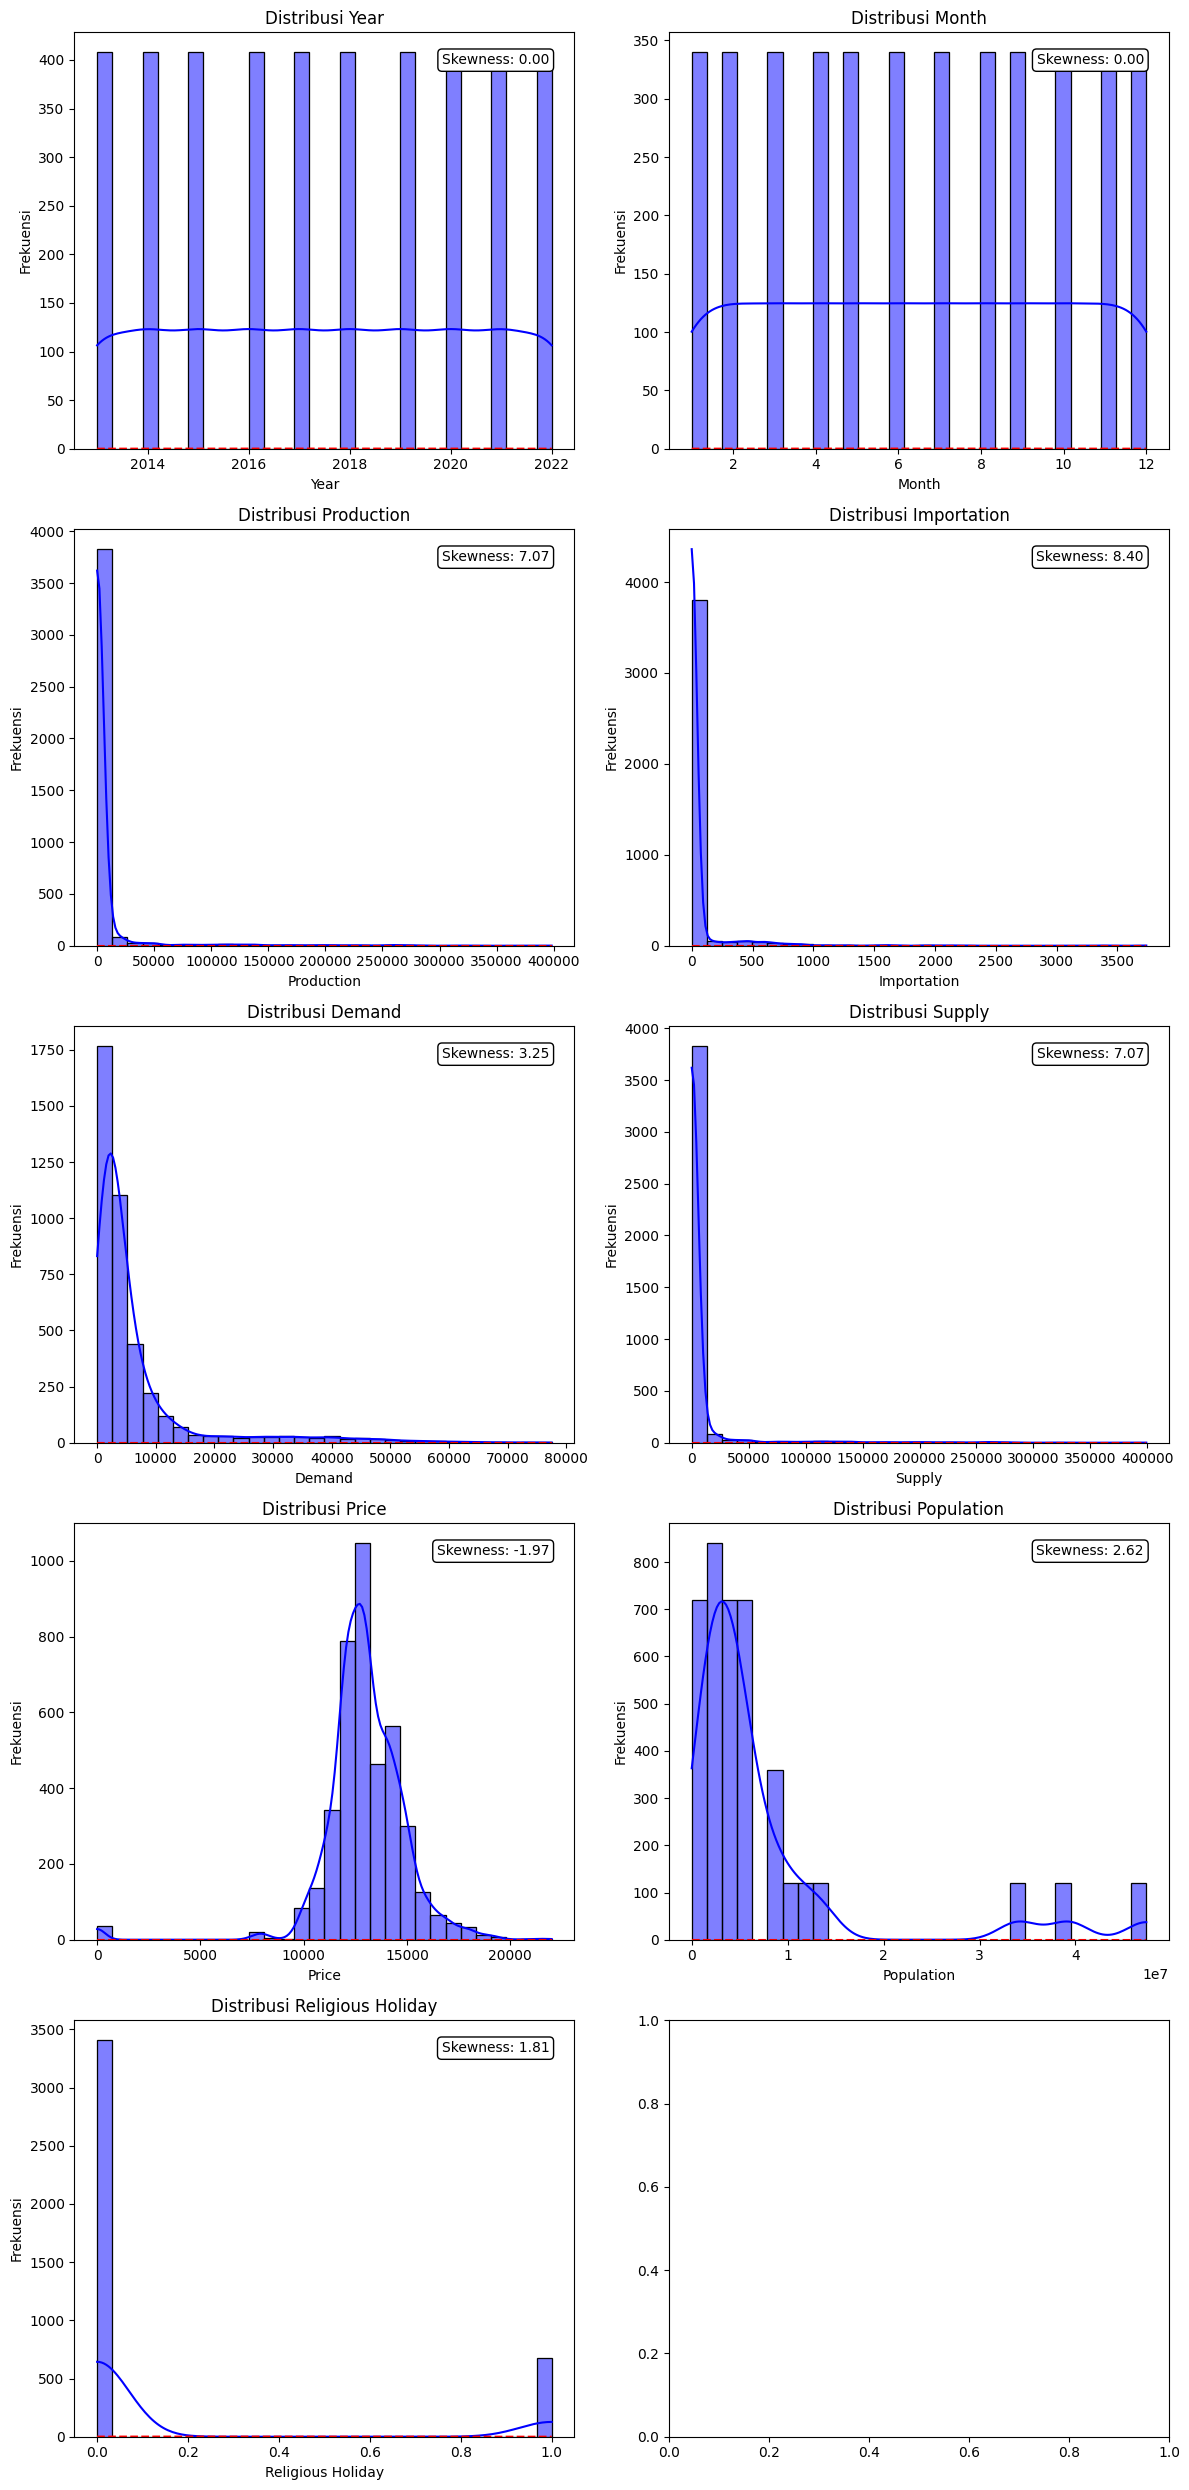

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew

def plot_distributions(data, numeric_cols):
    num_cols = len(numeric_cols)
    num_rows = (num_cols + 1) // 2  # Menghitung jumlah baris
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 5 * num_rows))  # Subplot dengan 2 kolom
    
    for i, col in enumerate(numeric_cols):
        row, col_idx = divmod(i, 2)  # Menentukan posisi subplot
        ax = axes[row, col_idx]

        # Histogram dengan kurva KDE
        sns.histplot(data[col], kde=True, bins=30, color='blue', alpha=0.5, ax=ax)
        
        # Tambahkan distribusi normal standar
        x_vals = np.linspace(data[col].min(), data[col].max(), 100)
        ax.plot(x_vals, norm.pdf(x_vals, data[col].mean(), data[col].std()), color='red', linestyle='dashed')

        # Hitung skewness
        skew_val = skew(data[col].dropna())

        # Tambahkan teks skewness ke plot
        ax.text(0.95, 0.95, f'Skewness: {skew_val:.2f}', 
                horizontalalignment='right',
                verticalalignment='top',
                transform=ax.transAxes,
                fontsize=10,
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

        ax.set_title(f'Distribusi {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frekuensi')

    plt.tight_layout()
    plt.show()

# Contoh pemanggilan:
plot_distributions(datas, numeric_cols)


## 2) STATIONARY ADF

In [19]:
from statsmodels.tsa.stattools import adfuller

def adf_test(data, col):
    print(f"ADF Test untuk kolom: {col}")
    
    # Ambil data kolom dan drop NA
    series = data[col].dropna()
    
    # Jalankan ADF test
    result = adfuller(series)
    
    print(f"  Test Statistic   : {result[0]:.4f}")
    print(f"  p-value          : {result[1]:.4f}")
    print(f"  Used Lag         : {result[2]}")
    print(f"  Number of Obs    : {result[3]}")
    print("  Critical Values:")
    for key, value in result[4].items():
        print(f"    {key} : {value:.4f}")
        
    if result[1] < 0.05:
        print("  -> Data stasioner (tolak H0)\n")
    else:
        print("  -> Data tidak stasioner (gagal tolak H0)\n")

# Contoh: tes ADF untuk semua kolom numerik (kecuali Year, Month kalau mau)
for col in numeric_cols:
    adf_test(datas, col)


ADF Test untuk kolom: Year
  Test Statistic   : -0.5216
  p-value          : 0.8877
  Used Lag         : 0
  Number of Obs    : 4079
  Critical Values:
    1% : -3.4320
    5% : -2.8622
    10% : -2.5671
  -> Data tidak stasioner (gagal tolak H0)

ADF Test untuk kolom: Month
  Test Statistic   : -495932951154571.1250
  p-value          : 0.0000
  Used Lag         : 11
  Number of Obs    : 4068
  Critical Values:
    1% : -3.4320
    5% : -2.8623
    10% : -2.5671
  -> Data stasioner (tolak H0)

ADF Test untuk kolom: Production
  Test Statistic   : -4.9409
  p-value          : 0.0000
  Used Lag         : 31
  Number of Obs    : 4048
  Critical Values:
    1% : -3.4320
    5% : -2.8623
    10% : -2.5672
  -> Data stasioner (tolak H0)

ADF Test untuk kolom: Importation
  Test Statistic   : -5.4599
  p-value          : 0.0000
  Used Lag         : 31
  Number of Obs    : 4048
  Critical Values:
    1% : -3.4320
    5% : -2.8623
    10% : -2.5672
  -> Data stasioner (tolak H0)

ADF Test untu

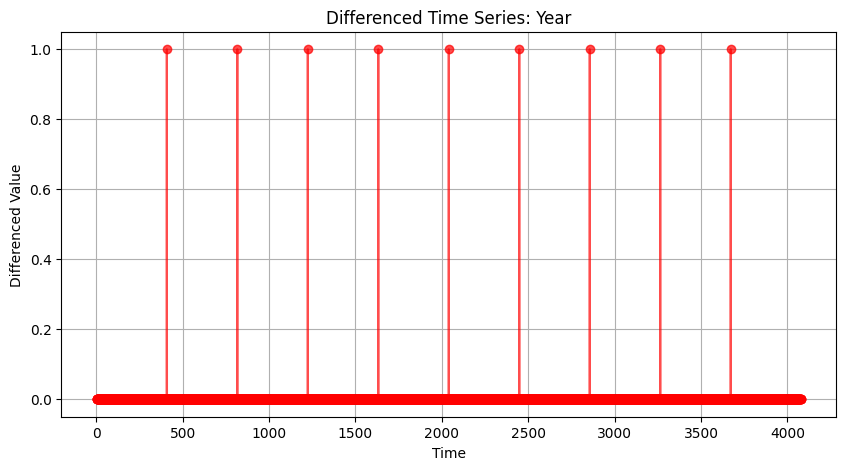

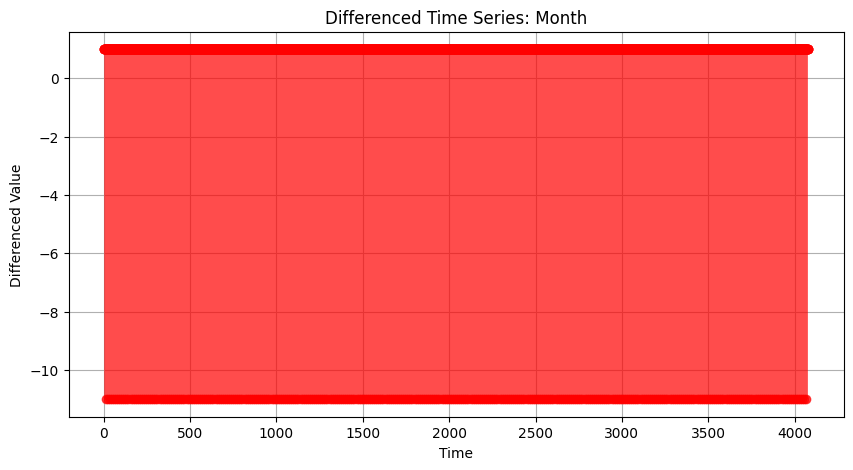

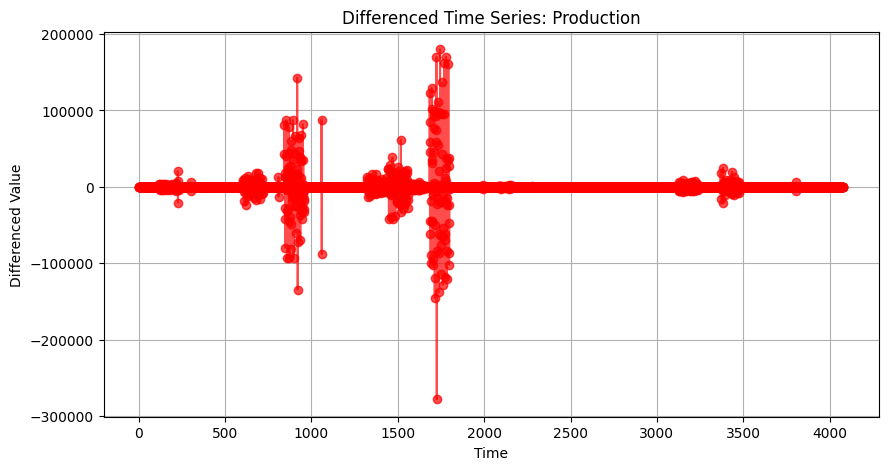

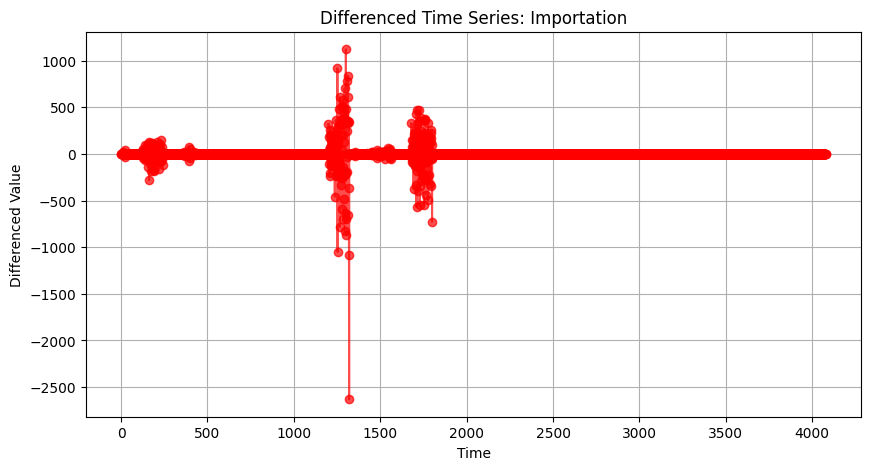

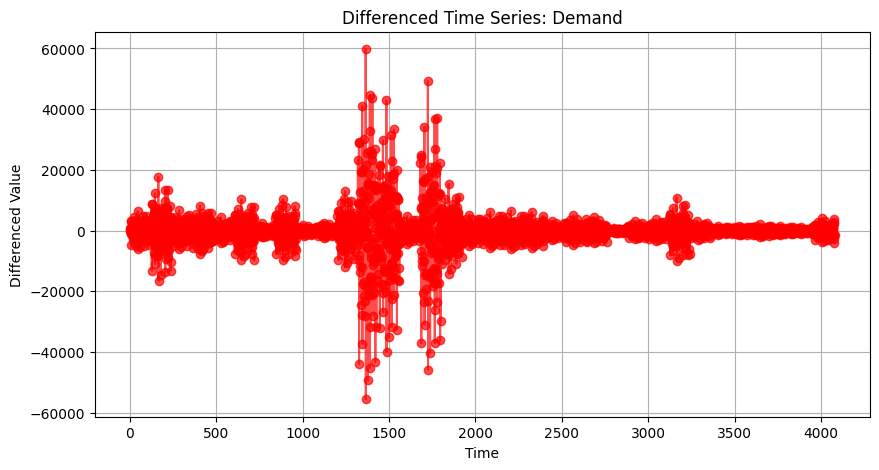

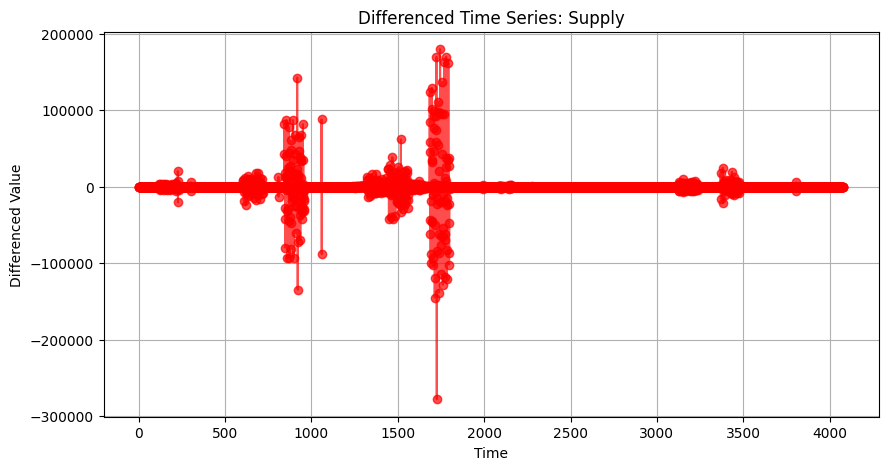

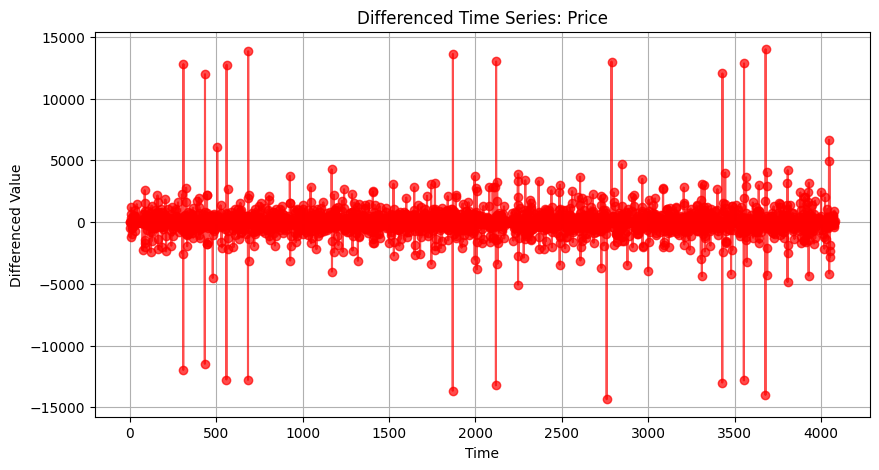

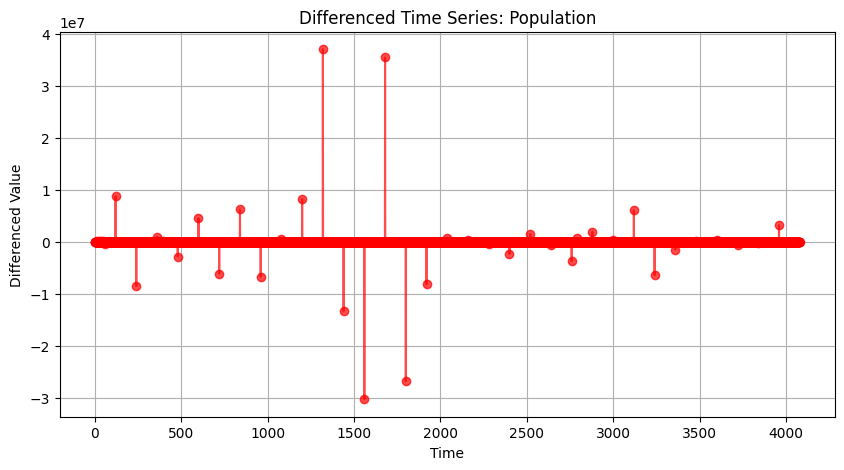

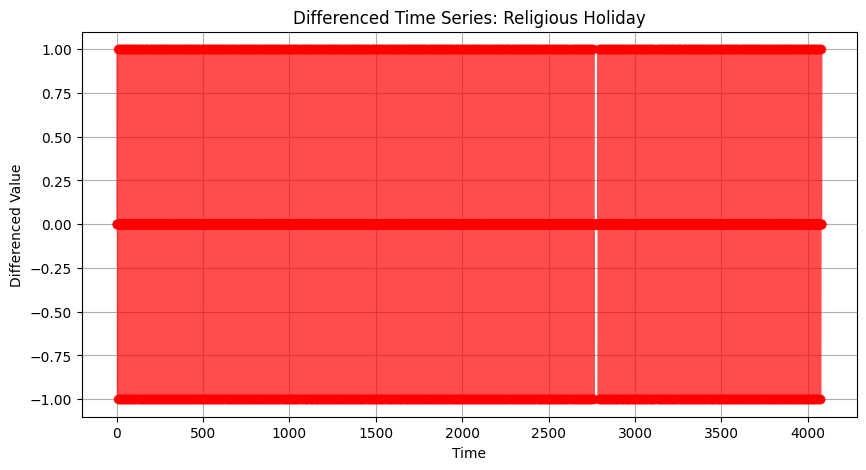

In [20]:
def plot_differencing(data, col):
    plt.figure(figsize=(10, 5))
    plt.plot(data[col].diff(), marker='o', linestyle='-', color='red', alpha=0.7)
    plt.title(f'Differenced Time Series: {col}')
    plt.xlabel('Time')
    plt.ylabel('Differenced Value')
    plt.grid(True)
    plt.show()

for col in numeric_cols:
    plot_differencing(datas, col)

## 3) MULTI-COLINEARITY (VIF)

In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Pilih hanya fitur numerik yang ingin dicek multikolinearitasnya
features = ['Production', 'Importation', 'Demand', 'Supply', 'Price', 'Population', 
            'Religious Holiday']

# Ambil subset data untuk fitur tersebut (drop NA jika ada)
X = datas[features].dropna()

# Hitung VIF untuk setiap fitur
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)


             Feature           VIF
0         Production  1.616207e+09
1        Importation  1.007520e+05
2             Demand  7.775523e+00
3             Supply  1.621400e+09
4              Price  1.692085e+00
5         Population  8.448237e+00
6  Religious Holiday  1.211896e+00


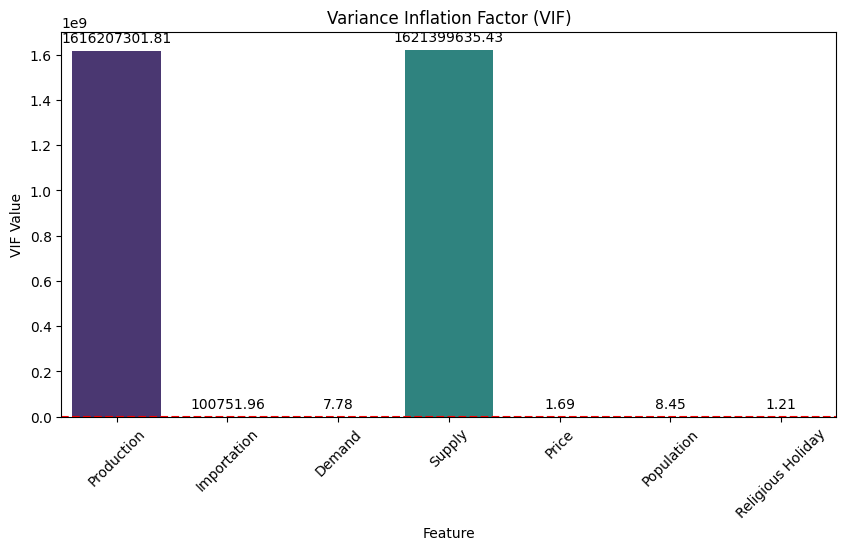

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot VIF dengan angka di atas batang
def plot_vif(vif_data):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x='Feature', y='VIF', data=vif_data, palette='viridis')
    
    # Tambahkan nilai di atas batang
    for bar in ax.patches:
        ax.annotate(format(bar.get_height(), '.2f'), 
                    (bar.get_x() + bar.get_width() / 2., bar.get_height()), 
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    
    plt.axhline(y=5, color='red', linestyle='dashed')  # Garis batas VIF=5
    plt.xticks(rotation=45)
    plt.title('Variance Inflation Factor (VIF)')
    plt.xlabel('Feature')
    plt.ylabel('VIF Value')
    plt.show()

plot_vif(vif_data)

## 4) HOMOSCEDASITY (Breusch Pagan)

In [23]:
datas.columns

Index(['Province', 'Year', 'Month', 'Production', 'Importation', 'Demand',
       'Supply', 'Price', 'Population', 'Religious Holiday'],
      dtype='object')

In [24]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Misal kita buat model regresi sederhana dulu (contoh dengan 'Price' sebagai target)
features = ['Year', 'Month', 'Production', 'Importation', 'Demand',
       'Supply', 'Population', 'Religious Holiday']
X = datas[features]
y = datas['Price']

# Tambahkan konstanta (intercept) untuk regresi
X = sm.add_constant(X)

# Fit model OLS
model = sm.OLS(y, X).fit()

# Lakukan uji Breusch-Pagan
bp_test = het_breuschpagan(model.resid, model.model.exog)

# Hasil test
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))


{'Lagrange multiplier statistic': 24.71689175615044, 'p-value': 0.0017358428477593235, 'f-value': 3.1015857479449647, 'f p-value': 0.001709898716945533}


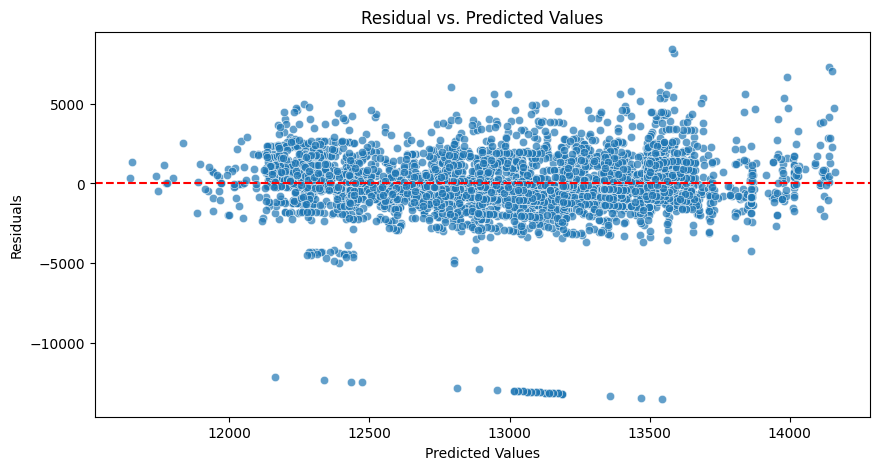

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_residuals(model):
    plt.figure(figsize=(10, 5))
    
    predicted_values = model.fittedvalues
    residuals = model.resid
    
    sns.scatterplot(x=predicted_values, y=residuals, alpha=0.7)
    plt.axhline(y=0, color='red', linestyle='dashed')
    
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual vs. Predicted Values')
    plt.show()

plot_residuals(model)

# MODELS FOR PANEL DATA

## 1) POOLED OLS

In [26]:
kolom_fitur = fitur.columns
kolom_fitur

Index(['Production', 'Importation', 'Demand', 'Supply', 'Price', 'Population',
       'Religious Holiday'],
      dtype='object')

In [27]:
# Perform PooledOLS
datas['YearMonth'] = pd.to_datetime(datas[['Year', 'Month']].assign(DAY=1))
datas

Province  Year  Month  Production  Importation  Demand  Supply    Price  \
0        Aceh  2013      1         0.0          0.0  3262.0     0.0  12500.0   
1        Aceh  2013      2         0.0          0.0  3127.0     0.0  12500.0   
2        Aceh  2013      3         0.0          0.0  3223.0     0.0  12500.0   
3        Aceh  2013      4         0.0          0.0  4188.0     0.0  12000.0   
4        Aceh  2013      5         0.0          0.0  5076.0     0.0  12659.0   
...       ...   ...    ...         ...          ...     ...     ...      ...   
4075    Papua  2022      8         0.0          0.0  2460.0     0.0  16120.0   
4076    Papua  2022      9         0.0          0.0  5308.0     0.0  15846.0   
4077    Papua  2022     10         0.0          0.0  2538.0     0.0  15425.0   
4078    Papua  2022     11         0.0          0.0  4808.0     0.0  16357.0   
4079    Papua  2022     12         0.0          0.0  3470.0     0.0  16473.0   

      Population  Religious Holiday  YearMonth  
0        4811100                  0 2013-01-01  
1        4811100                  0 2013-02-01  
2        4811100                  0 2013-03-01  
3        4811100                  0 2013-04-01  
4        4811100                  0 2013-05-01  
...          ...                ...        ...  
4075     4418600                  0 2022-08-01  
4076     4418600                  0 2022-09-01  
4077     4418600                  0 2022-10-01  
4078     4418600                  0 2022-11-01  
4079     4418600                  1 2022-12-01  

[4080 rows x 11 columns]

In [28]:
# Perform PooledOLS
datas['YearMonth'] = pd.to_datetime(datas[['Year', 'Month']].assign(DAY=1))

data = datas.set_index(['Province','YearMonth']).sort_values(by=['YearMonth','Province'])
data
# kolom_fitur = fitur.columns
# # define predictor and response variables
X = data[['Production',	'Importation', 'Demand','Supply','Population',	
          'Religious Holiday']]
Y = data[['Price']]

exog = sm.tools.tools.add_constant(X)
endog = Y
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)
print(pooledOLS_res.summary)

# # Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

                          PooledOLS Estimation Summary                          
Dep. Variable:                  Price   R-squared:                        0.0146
Estimator:                  PooledOLS   R-squared (Between):              0.0473
No. Observations:                4080   R-squared (Within):               0.0088
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.0146
Time:                        08:26:51   Log-likelihood                -3.683e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      10.056
Entities:                          34   P-value                           0.0000
Avg Obs:                       120.00   Distribution:                  F(6,4073)
Min Obs:                       120.00                                           
Max Obs:                       120.00   F-statistic (robust):             76.788
                            

In [29]:
# White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
pooled_OLS_dataset = pd.concat([data, residuals_pooled_OLS], axis=1)
exog = sm.tools.tools.add_constant(Y).fillna(0)
white_test_results = het_white(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val']
print('White Test: ',dict(zip(labels, white_test_results)))

# Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val']
print('Breusch-Pagan: ',dict(zip(labels, breusch_pagan_test_results)))

# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson
durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual'])
print('Durbin-Watson:', durbin_watson_test_results)

White Test:  {'LM-Stat': 4071.161757546827, 'LM p-val': 0.0, 'F-Stat': 938994.7477374678, 'F p-val': 0.0}
Breusch-Pagan:  {'LM-Stat': 1003.5757967766064, 'LM p-val': 2.9992864248749595e-220, 'F-Stat': 1330.3048698443163, 'F p-val': 2.4608662322494165e-252}
Durbin-Watson: 1.3823519271087046


## 2) FEM & REM

In [30]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, RandomEffects
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

# --- Model Estimasi ---

# Siapkan X dan Y
exog = sm.tools.tools.add_constant(X)
endog = Y

# Random Effects Model
model_re = RandomEffects(endog, exog)
re_res = model_re.fit()
residuals_re = re_res.resids.rename('residual')

# Fixed Effects Model
model_fe = PanelOLS(endog, exog, entity_effects=True, drop_absorbed=True)
fe_res = model_fe.fit()
residuals_fe = fe_res.resids.rename('residual')

# Cetak hasil
print(re_res)
print('\n')
print(fe_res)


                        RandomEffects Estimation Summary                        
Dep. Variable:                  Price   R-squared:                        0.0123
Estimator:              RandomEffects   R-squared (Between):             -0.0371
No. Observations:                4080   R-squared (Within):               0.0127
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.0052
Time:                        08:26:51   Log-likelihood                -3.651e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8.4875
Entities:                          34   P-value                           0.0000
Avg Obs:                       120.00   Distribution:                  F(6,4073)
Min Obs:                       120.00                                           
Max Obs:                       120.00   F-statistic (robust):             8.4875
                            

In [31]:
endog

Price
Province    YearMonth          
Aceh        2013-01-01  12500.0
            2013-01-01  12000.0
            2013-01-01  11000.0
            2013-01-01  13000.0
            2013-01-01  14500.0
...                         ...
Papua Barat 2022-12-01  13938.0
            2022-12-01  14416.0
            2022-12-01  14650.0
            2022-12-01  14750.0
            2022-12-01  15750.0

[4080 rows x 1 columns]

In [32]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel import PanelOLS, RandomEffects
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import f

# ------------------- Fungsi Chow Test -------------------
def run_chow_test(X, y, group_var):
    """
    Chow test untuk membandingkan dua grup (group_var harus binary: 0 dan 1).
    X: DataFrame fitur (sudah termasuk konstanta).
    y: dependent variable.
    group_var: Series/array 0/1 pembagi grup.
    """
    # Split data berdasarkan group_var
    X1, y1 = X[group_var == 0], y[group_var == 0]
    X2, y2 = X[group_var == 1], y[group_var == 1]

    # Model gabungan
    model_full = sm.OLS(y, X).fit()
    RSS_pooled = sum(model_full.resid ** 2)

    # Model subset
    model_1 = sm.OLS(y1, X1).fit()
    model_2 = sm.OLS(y2, X2).fit()
    RSS_1 = sum(model_1.resid ** 2)
    RSS_2 = sum(model_2.resid ** 2)

    n1, n2 = X1.shape[0], X2.shape[0]
    k = X.shape[1]  # termasuk konstanta

    numerator = (RSS_pooled - (RSS_1 + RSS_2)) / k
    denominator = (RSS_1 + RSS_2) / (n1 + n2 - 2 * k)
    F_stat = numerator / denominator
    p_value = 1 - f.cdf(F_stat, k, n1 + n2 - 2 * k)

    return F_stat, p_value

# ------------------- Fungsi Uji Diagnostik -------------------
# ------------------- Fungsi Uji Diagnostik -------------------
def run_all_tests(model_name, X, residuals, dependent_var=None, group_var=None):
    print(f"\n--- Diagnostic Tests for {model_name} ---")

    residuals = residuals.rename("residual").reset_index(drop=True).astype(float)
    X_clean = X.reset_index(drop=True).astype(float)

    data_test = pd.concat([X_clean, residuals], axis=1).dropna()
    exog_test = sm.add_constant(data_test.drop(columns='residual'), has_constant='add')

    labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val']  # Pindah ke sini agar selalu tersedia

    # White test
    try:
        white_test = het_white(data_test['residual'], exog_test)
        print('White Test:', dict(zip(labels, white_test)))
    except Exception as e:
        print('White Test Error:', e)

    # Breusch-Pagan test
    try:
        bp_test = het_breuschpagan(data_test['residual'], exog_test)
        print('Breusch-Pagan Test:', dict(zip(labels, bp_test)))
    except Exception as e:
        print('Breusch-Pagan Error:', e)

    # Durbin-Watson test
    try:
        dw = durbin_watson(data_test['residual'])
        print('Durbin-Watson:', dw)
    except Exception as e:
        print('Durbin-Watson Error:', e)

    # Chow test
    if dependent_var is not None and group_var is not None:
        try:
            y = dependent_var.reset_index(drop=True).astype(float)
            grp = group_var.reset_index(drop=True)
            X_chow = exog_test  # sudah termasuk konstanta

            F_stat, p_val = run_chow_test(X_chow, y, grp)
            print(f"Chow Test: F-statistic = {F_stat:.4f}, p-value = {p_val:.4f}")
        except Exception as e:
            print("Chow Test Error:", e)


# ------------------- Input Data Panel -------------------
# Misal kamu sudah punya X, Y, dan group_var sebagai berikut:

# Gunakan MultiIndex dari (Province, YearMonth)
# Pastikan X dan Y sudah memiliki index yang sama
# Sudah termasuk 'const' dalam X
exog = sm.add_constant(X)
endog = Y

# Random Effects
model_re = RandomEffects(endog, exog)
re_res = model_re.fit()
residuals_re = re_res.resids

# Fixed Effects
model_fe = PanelOLS(endog, exog, entity_effects=True, drop_absorbed=True)
fe_res = model_fe.fit()
residuals_fe = fe_res.resids

# Cetak hasil regresi
print(re_res)
print("\n")
print(fe_res)

# ------------------- Jalankan Uji Diagnostik -------------------
# Misal group_var = X['Religious Holiday'] atau buat grup lain dari tahun
group_var = X['Religious Holiday']

run_all_tests("Random Effects", X, residuals_re, dependent_var=Y, group_var=group_var)
run_all_tests("Fixed Effects", X, residuals_fe, dependent_var=Y, group_var=group_var)


                        RandomEffects Estimation Summary                        
Dep. Variable:                  Price   R-squared:                        0.0123
Estimator:              RandomEffects   R-squared (Between):             -0.0371
No. Observations:                4080   R-squared (Within):               0.0127
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.0052
Time:                        08:26:51   Log-likelihood                -3.651e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8.4875
Entities:                          34   P-value                           0.0000
Avg Obs:                       120.00   Distribution:                  F(6,4073)
Min Obs:                       120.00                                           
Max Obs:                       120.00   F-statistic (robust):             8.4875
                            

In [33]:
# # White-Test
# from statsmodels.stats.diagnostic import het_white, het_breuschpagan
# pooled_OLS_dataset = pd.concat([data, residuals_pooled_OLS], axis=1)
# exog = sm.tools.tools.add_constant(Y).fillna(0)
# white_test_results = het_white(pooled_OLS_dataset['residual'], exog)
# labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val']
# print('White Test: ',dict(zip(labels, white_test_results)))

# # Breusch-Pagan-Test
# breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
# labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val']
# print('Breusch-Pagan: ',dict(zip(labels, breusch_pagan_test_results)))

# # Durbin-Watson-Test
# from statsmodels.stats.stattools import durbin_watson
# durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual'])
# print('Durbin-Watson:', durbin_watson_test_results)

In [34]:
# Hausman Test
def hausman(fe, re):
    # ambil parameter yang sama
    common_coef = fe.params.index.intersection(re.params.index)
    
    b = fe.params[common_coef]
    B = re.params[common_coef]
    v_b = fe.cov.loc[common_coef, common_coef]
    v_B = re.cov.loc[common_coef, common_coef]

    diff = b - B
    try:
        chi2 = np.dot(diff.T, la.inv(v_b - v_B).dot(diff))
        df = len(diff)
        pval = stats.chi2.sf(chi2, df)
    except np.linalg.LinAlgError:
        chi2, df, pval = np.nan, len(diff), np.nan

    return chi2, df, pval


hausman_results = hausman(fe_res, re_res)
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))
print('\n')
if hausman_results[2] > 0.05:
    # Random Effect
    print('Random Effect')
    print(re_res.params)
    # Store values for checking homoskedasticity graphically
    fittedvals = re_res.predict().fitted_values
    residuals = re_res.resids
else:
    # Fixed Effect
    print('Fixed Effect')
    print(fe_res.params)
    # Store values for checking homoskedasticity graphically
    fittedvals = fe_res.predict().fitted_values
    residuals = fe_res.resids


chi-Squared: 1481.4875147760379
degrees of freedom: 7
p-Value: 0.0


Fixed Effect
const               -110879.185814
Production              -13.424293
Importation             -12.657430
Demand                   -0.001841
Supply                   13.424258
Population                0.016117
Religious Holiday       410.116527
Name: parameter, dtype: float64


In [35]:
# White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan
panel_dataset = pd.concat([data, residuals], axis=1)
exog = sm.tools.tools.add_constant(Y).fillna(0)
white_test_results = het_white(panel_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val']
print('White Test: ',dict(zip(labels, white_test_results)))

# Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(panel_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val']
print('Breusch-Pagan: ',dict(zip(labels, breusch_pagan_test_results)))

# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson
durbin_watson_test_results = durbin_watson(panel_dataset['residual'])
print('Durbin-Watson:', durbin_watson_test_results)

White Test:  {'LM-Stat': 1325.8587105824724, 'LM p-val': 1.240049739173231e-288, 'F-Stat': 981.3450718405142, 'F p-val': 0.0}
Breusch-Pagan:  {'LM-Stat': 70.38334384097955, 'LM p-val': 4.883047711382751e-17, 'F-Stat': 71.58372004032603, 'F p-val': 3.656493582860864e-17}
Durbin-Watson: 1.7881044860198276


# GWPR

## 1) LOAD PETA INDONESIA

In [36]:
maps = gpd.read_file(
    "/kaggle/input/data-gwpr/indonesia.geojson"
)
maps

cartodb_id    country  id_1                         slug  \
0           16  Indonesia     1               indonesia-aceh   
1            2  Indonesia    31      indonesia-sumaterabarat   
2            8  Indonesia    34         indonesia-yogyakarta   
3           20  Indonesia    33      indonesia-sumaterautara   
4            7  Indonesia     3     indonesia-bangkabelitung   
5            5  Indonesia     7         indonesia-papuabarat   
6            4  Indonesia    12          indonesia-jawatimur   
7           10  Indonesia    13    indonesia-kalimantanbarat   
8            3  Indonesia    14  indonesia-kalimantanselatan   
9            6  Indonesia    16    indonesia-kalimantantimur   
10           9  Indonesia    18      indonesia-kepulauanriau   
11          11  Indonesia    19            indonesia-lampung   
12          14  Indonesia    21             indonesia-maluku   
13          19  Indonesia    20        indonesia-malukuutara   
14          15  Indonesia    22  indonesia-nusatenggarabarat   
15          29  Indonesia    23  indonesia-nusatenggaratimur   
16           1  Indonesia    24              indonesia-papua   
17          12  Indonesia    25               indonesia-riau   
18          18  Indonesia    27    indonesia-sulawesiselatan   
19          24  Indonesia     5           indonesia-bengkulu   
20          26  Indonesia    28     indonesia-sulawesitengah   
21          27  Indonesia    30      indonesia-sulawesiutara   
22          28  Indonesia    29   indonesia-sulawesitenggara   
23          31  Indonesia     2               indonesia-bali   
24          30  Indonesia     4             indonesia-banten   
25          32  Indonesia     6          indonesia-gorontalo   
26          25  Indonesia     8        indonesia-jakartaraya   
27          34  Indonesia     9              indonesia-jambi   
28          22  Indonesia    10          indonesia-jawabarat   
29          23  Indonesia    11         indonesia-jawatengah   
30          33  Indonesia    15   indonesia-kalimantantengah   
31          17  Indonesia    26      indonesia-sulawesibarat   
32          21  Indonesia    32    indonesia-sumateraselatan   
33          34  Indonesia    35    indonesia-kalimantanutara   

                  state                                           geometry  
0                  Aceh  MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
1        Sumatera Barat  MULTIPOLYGON (((99.17167 -1.50250, 99.20500 -1...  
2            Yogyakarta  MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...  
3        Sumatera Utara  MULTIPOLYGON (((98.71384 3.76947, 99.05473 3.6...  
4       Bangka-Belitung  MULTIPOLYGON (((105.34754 -1.84469, 105.39079 ...  
5           Papua Barat  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  
6            Jawa Timur  MULTIPOLYGON (((113.59208 -7.71486, 113.66695 ...  
7      Kalimantan Barat  MULTIPOLYGON (((108.92462 0.55861, 108.92167 0...  
8    Kalimantan Selatan  MULTIPOLYGON (((114.51278 -3.54225, 114.51806 ...  
9      Kalimantan Timur  MULTIPOLYGON (((117.01733 -1.16421, 116.93333 ...  
10       Kepulauan Riau  MULTIPOLYGON (((103.99194 1.13472, 104.01361 1...  
11              Lampung  MULTIPOLYGON (((105.81611 -5.57617, 105.79945 ...  
12               Maluku  MULTIPOLYGON (((128.28972 -3.62194, 128.25694 ...  
13         Maluku Utara  MULTIPOLYGON (((127.57263 0.86478, 127.54813 0...  
14  Nusa Tenggara Barat  MULTIPOLYGON (((118.83139 -6.56889, 118.84111 ...  
15  Nusa Tenggara Timur  MULTIPOLYGON (((124.22305 -10.15944, 124.10889...  
16                Papua  MULTIPOLYGON (((140.68666 -2.47778, 140.74722 ...  
17                 Riau  MULTIPOLYGON (((101.91405 -0.92096, 101.84528 ...  
18     Sulawesi Selatan  MULTIPOLYGON (((119.59165 -4.55424, 119.59671 ...  
19             Bengkulu  MULTIPOLYGON (((102.56528 -4.17972, 102.28000 ...  
20      Sulawesi Tengah  MULTIPOLYGON (((121.63028 -0.12361, 121.65417 ...  
21       Sulawesi Utara  MULTIPOLYGON (((125.24160 1.50043, 125.20739

In [37]:
print("maps:", maps["state"].unique())
# print("datas:", panel_dataset["Province"].unique())


maps: ['Aceh' 'Sumatera Barat' 'Yogyakarta' 'Sumatera Utara' 'Bangka-Belitung'
 'Papua Barat' 'Jawa Timur' 'Kalimantan Barat' 'Kalimantan Selatan'
 'Kalimantan Timur' 'Kepulauan Riau' 'Lampung' 'Maluku' 'Maluku Utara'
 'Nusa Tenggara Barat' 'Nusa Tenggara Timur' 'Papua' 'Riau'
 'Sulawesi Selatan' 'Bengkulu' 'Sulawesi Tengah' 'Sulawesi Utara'
 'Sulawesi Tenggara' 'Bali' 'Banten' 'Gorontalo' 'Jakarta Raya' 'Jambi'
 'Jawa Barat' 'Jawa Tengah' 'Kalimantan Tengah' 'Sulawesi Barat'
 'Sumatera Selatan' 'Kalimantan Utara']


In [38]:
# Gabung dataframe
maps["Province"] = maps["state"]
merged = maps.merge(panel_dataset, on="Province", how="right")

# Pastikan hasil adalah GeoDataFrame
import geopandas as gpd
merged = gpd.GeoDataFrame(merged, geometry="geometry")
merged

cartodb_id    country  id_1                  slug        state  \
0             16  Indonesia     1        indonesia-aceh         Aceh   
1             16  Indonesia     1        indonesia-aceh         Aceh   
2             16  Indonesia     1        indonesia-aceh         Aceh   
3             16  Indonesia     1        indonesia-aceh         Aceh   
4             16  Indonesia     1        indonesia-aceh         Aceh   
...          ...        ...   ...                   ...          ...   
4075           5  Indonesia     7  indonesia-papuabarat  Papua Barat   
4076           5  Indonesia     7  indonesia-papuabarat  Papua Barat   
4077           5  Indonesia     7  indonesia-papuabarat  Papua Barat   
4078           5  Indonesia     7  indonesia-papuabarat  Papua Barat   
4079           5  Indonesia     7  indonesia-papuabarat  Papua Barat   

                                               geometry     Province  Year  \
0     MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...         Aceh  2013   
1     MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...         Aceh  2013   
2     MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...         Aceh  2013   
3     MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...         Aceh  2013   
4     MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...         Aceh  2013   
...                                                 ...          ...   ...   
4075  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  Papua Barat  2022   
4076  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  Papua Barat  2022   
4077  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  Papua Barat  2022   
4078  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  Papua Barat  2022   
4079  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  Papua Barat  2022   

      Month  Production  Importation  Demand  Supply    Price  Population  \
0         1         0.0         0.00  3262.0    0.00  12500.0     4811100   
1         1         0.0        16.02  3399.0   16.02  12000.0     4906800   
2         1         0.0         0.00  2902.0    0.00  11000.0     5020000   
3         1         0.0         0.00  2529.0    0.00  13000.0     5096200   
4         1         0.0         0.00  4706.0    0.00  14500.0     5189500   
...     ...         ...          ...     ...     ...      ...         ...   
4075     12         0.0         0.00   802.0    0.00  13938.0     1183300   
4076     12         0.0         0.00   705.0    0.00  14416.0     1183300   
4077     12         0.0         0.00   651.0    0.00  14650.0     1183300   
4078     12         0.0         0.00  1014.0    0.00  14750.0     1183300   
4079     12         0.0         0.00   636.0    0.00  15750.0     1183300   

      Religious Holiday     residual  
0                     0   564.541202  
1                     0 -1489.866047  
2                     0 -4302.914627  
3                     0 -3531.699064  
4                     0 -3531.386379  
...                 ...          ...  
4075                  1 -1113.940301  
4076                  1  -636.118852  
4077                  1  -402.218252  
4078                  1  -301.550064  
4079                  1   697.754137  

[4080 rows x 17 columns]

## 2) GABUNG KOORDINAT PETA DENGAN DATASET

In [39]:
data = merged.drop(['cartodb_id','country',	'id_1',	'slug',	'state','geometry'],axis=1)
data

Province  Year  Month  Production  Importation  Demand  Supply  \
0            Aceh  2013      1         0.0         0.00  3262.0    0.00   
1            Aceh  2013      1         0.0        16.02  3399.0   16.02   
2            Aceh  2013      1         0.0         0.00  2902.0    0.00   
3            Aceh  2013      1         0.0         0.00  2529.0    0.00   
4            Aceh  2013      1         0.0         0.00  4706.0    0.00   
...           ...   ...    ...         ...          ...     ...     ...   
4075  Papua Barat  2022     12         0.0         0.00   802.0    0.00   
4076  Papua Barat  2022     12         0.0         0.00   705.0    0.00   
4077  Papua Barat  2022     12         0.0         0.00   651.0    0.00   
4078  Papua Barat  2022     12         0.0         0.00  1014.0    0.00   
4079  Papua Barat  2022     12         0.0         0.00   636.0    0.00   

        Price  Population  Religious Holiday     residual  
0     12500.0     4811100                  0   564.541202  
1     12000.0     4906800                  0 -1489.866047  
2     11000.0     5020000                  0 -4302.914627  
3     13000.0     5096200                  0 -3531.699064  
4     14500.0     5189500                  0 -3531.386379  
...       ...         ...                ...          ...  
4075  13938.0     1183300                  1 -1113.940301  
4076  14416.0     1183300                  1  -636.118852  
4077  14650.0     1183300                  1  -402.218252  
4078  14750.0     1183300                  1  -301.550064  
4079  15750.0     1183300                  1   697.754137  

[4080 rows x 11 columns]

In [40]:
data = pd.concat([data, merged['geometry']],axis=1)
data

Province  Year  Month  Production  Importation  Demand  Supply  \
0            Aceh  2013      1         0.0         0.00  3262.0    0.00   
1            Aceh  2013      1         0.0        16.02  3399.0   16.02   
2            Aceh  2013      1         0.0         0.00  2902.0    0.00   
3            Aceh  2013      1         0.0         0.00  2529.0    0.00   
4            Aceh  2013      1         0.0         0.00  4706.0    0.00   
...           ...   ...    ...         ...          ...     ...     ...   
4075  Papua Barat  2022     12         0.0         0.00   802.0    0.00   
4076  Papua Barat  2022     12         0.0         0.00   705.0    0.00   
4077  Papua Barat  2022     12         0.0         0.00   651.0    0.00   
4078  Papua Barat  2022     12         0.0         0.00  1014.0    0.00   
4079  Papua Barat  2022     12         0.0         0.00   636.0    0.00   

        Price  Population  Religious Holiday     residual  \
0     12500.0     4811100                  0   564.541202   
1     12000.0     4906800                  0 -1489.866047   
2     11000.0     5020000                  0 -4302.914627   
3     13000.0     5096200                  0 -3531.699064   
4     14500.0     5189500                  0 -3531.386379   
...       ...         ...                ...          ...   
4075  13938.0     1183300                  1 -1113.940301   
4076  14416.0     1183300                  1  -636.118852   
4077  14650.0     1183300                  1  -402.218252   
4078  14750.0     1183300                  1  -301.550064   
4079  15750.0     1183300                  1   697.754137   

                                               geometry  
0     MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
1     MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
2     MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
3     MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
4     MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
...                                                 ...  
4075  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  
4076  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  
4077  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  
4078  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  
4079  MULTIPOLYGON (((134.23334 -1.74194, 134.22139 ...  

[4080 rows x 12 columns]

## 3) SEBARAN HARGA GULA TIAP PROVINSI DENGAN VISUAL PETA

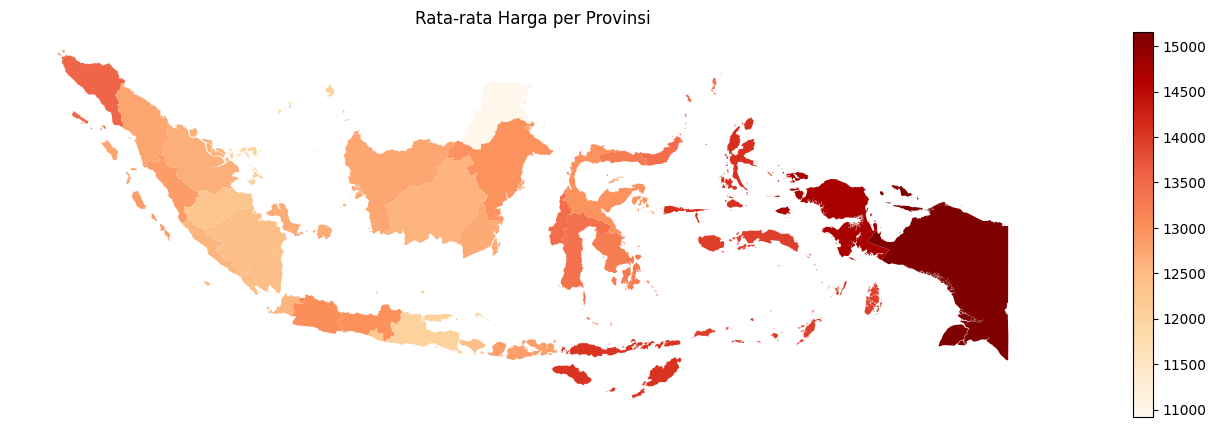

In [41]:
## import matplotlib.pyplot as plt

# Ambil data rata-rata per provinsi (terbaru atau agregat)
avg_price = data.groupby("Province")["Price"].mean().reset_index()
map_price = maps.merge(avg_price, on="Province", how="left")

# Plot
map_price.plot(column="Price", cmap="OrRd", legend=True, figsize=(20, 5))
plt.title("Rata-rata Harga per Provinsi")
plt.axis("off")
plt.show()


## 4) FIX DATA PANEL FOR GWPR

In [42]:
datas_panel = data.set_index(['Province', 'Year','Month']).sort_index()

# Contoh cek
print(datas_panel.head())

                     Production  Importation  Demand  Supply    Price  \
Province Year Month                                                     
Aceh     2013 1             0.0         0.00  3262.0    0.00  12500.0   
              1             0.0        16.02  3399.0   16.02  12000.0   
              1             0.0         0.00  2902.0    0.00  11000.0   
              1             0.0         0.00  2529.0    0.00  13000.0   
              1             0.0         0.00  4706.0    0.00  14500.0   

                     Population  Religious Holiday     residual  \
Province Year Month                                               
Aceh     2013 1         4811100                  0   564.541202   
              1         4906800                  0 -1489.866047   
              1         5020000                  0 -4302.914627   
              1         5096200                  0 -3531.699064   
              1         5189500                  0 -3531.386379   

                  

In [43]:
datas_panel

Production  Importation  Demand  Supply    Price  \
Province   Year Month                                                     
Aceh       2013 1             0.0         0.00  3262.0    0.00  12500.0   
                1             0.0        16.02  3399.0   16.02  12000.0   
                1             0.0         0.00  2902.0    0.00  11000.0   
                1             0.0         0.00  2529.0    0.00  13000.0   
                1             0.0         0.00  4706.0    0.00  14500.0   
...                           ...          ...     ...     ...      ...   
Yogyakarta 2017 11            0.0         0.00  2663.0    0.00  13239.0   
                12            0.0         0.00  4297.0    0.00  12424.0   
                12            0.0         0.00  2670.0    0.00  12500.0   
                12            0.0         0.00  3180.0    0.00  12500.0   
                12            0.0         0.00  3724.0    0.00  13386.0   

                       Population  Religious Holiday     residual  \
Province   Year Month                                               
Aceh       2013 1         4811100                  0   564.541202   
                1         4906800                  0 -1489.866047   
                1         5020000                  0 -4302.914627   
                1         5096200                  0 -3531.699064   
                1         5189500                  0 -3531.386379   
...                           ...                ...          ...   
Yogyakarta 2017 11        3762200                  0   815.233898   
                12        3762200                  1  -406.874864   
                12        3762200                  1  -333.869744   
                12        3762200                  1  -332.930968   
                12        3762200                  1   554.070393   

                                                                geometry  
Province   Year Month                                                     
Aceh       2013 1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...  
...                                                                  ...  
Yogyakarta 2017 11     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...  
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...  
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...  
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...  
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...  

[4080 rows x 9 columns]

## 5) AMBIL CENTROID

In [44]:
import geopandas as gpd

# Pastikan ini adalah GeoDataFrame (bukan DataFrame biasa)
datas_panel = gpd.GeoDataFrame(datas_panel, geometry='geometry')

# Atur crs jika belum ada (wajib untuk operasi spasial)
if datas_panel.crs is None:
    datas_panel.set_crs(epsg=4326, inplace=True)  # gunakan WGS84 (lat/lon)

# Ambil centroid dari setiap geometry
datas_panel['centroid'] = datas_panel.geometry.centroid

# Pecah jadi kolom lon dan lat
datas_panel['lon'] = datas_panel['centroid'].x
datas_panel['lat'] = datas_panel['centroid'].y
datas_panel

/tmp/ipykernel_35/3856991978.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  datas_panel['centroid'] = datas_panel.geometry.centroid


Production  Importation  Demand  Supply    Price  \
Province   Year Month                                                     
Aceh       2013 1             0.0         0.00  3262.0    0.00  12500.0   
                1             0.0        16.02  3399.0   16.02  12000.0   
                1             0.0         0.00  2902.0    0.00  11000.0   
                1             0.0         0.00  2529.0    0.00  13000.0   
                1             0.0         0.00  4706.0    0.00  14500.0   
...                           ...          ...     ...     ...      ...   
Yogyakarta 2017 11            0.0         0.00  2663.0    0.00  13239.0   
                12            0.0         0.00  4297.0    0.00  12424.0   
                12            0.0         0.00  2670.0    0.00  12500.0   
                12            0.0         0.00  3180.0    0.00  12500.0   
                12            0.0         0.00  3724.0    0.00  13386.0   

                       Population  Religious Holiday     residual  \
Province   Year Month                                               
Aceh       2013 1         4811100                  0   564.541202   
                1         4906800                  0 -1489.866047   
                1         5020000                  0 -4302.914627   
                1         5096200                  0 -3531.699064   
                1         5189500                  0 -3531.386379   
...                           ...                ...          ...   
Yogyakarta 2017 11        3762200                  0   815.233898   
                12        3762200                  1  -406.874864   
                12        3762200                  1  -333.869744   
                12        3762200                  1  -332.930968   
                12        3762200                  1   554.070393   

                                                                geometry  \
Province   Year Month                                                      
Aceh       2013 1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...   
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...   
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...   
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...   
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...   
...                                                                  ...   
Yogyakarta 2017 11     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...   
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...   
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...   
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...   
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...   

                                         centroid         lon       lat  
Province   Year Month                                                    
Aceh       2013 1        POINT (96.90797 4.22181)   96.907973  4.221807  
                1        POINT (96.90797 4.22181)   96.907973  4.221807  
                1        POINT (96.90797 4.22181)   96.907973  4.221807  
                1        POINT (96.90797 4.22181)   96.907973  4.221807  
                1        POINT (96.90797 4.22181)   96.907973  4.221807  
...                                           ...         ...       ...  
Yogyakarta 2017 11     POINT (110.44724 -7.89605)  110.447237 -7.896046  
                12     POINT (110.44724 -7.89605)  110.447237 -7.896046  
                12     POINT (110.44724 -7.89605)  110.447237 -7.896046  
                12     POINT (110.44724 -7.89605)  110.447237 -7.896046  
                12     POINT (110.44724 -7.89605)  110.447237 -7.896046  

[4080 rows x 12 columns]

## GWPR - SCENARIOS 

In [45]:
# import pandas as pd
# import numpy as np
# from mgwr.gwr import GWR
# from mgwr.sel_bw import Sel_BW
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from scipy.stats import t
# import warnings

# warnings.filterwarnings('ignore')

# # Supaya tampilan float di pandas lebih banyak digit
# pd.options.display.float_format = '{:.8f}'.format

# def run_gwr(
#     data,                # DataFrame berisi data (harus ada kolom lon, lat, dan Province)
#     features,            # List fitur prediktor (nama kolom)
#     target,              # Nama kolom target
#     kernel='bisquare',   # Kernel GWR (default bisquare)
#     fixed=True           # Fixed bandwidth (default True)
# ):
#     # Reset index jika perlu
#     data_reset = data.reset_index()

#     # Extract X, y, coords
#     X = data_reset[features].values.astype(float)
#     y = data_reset[target].values.reshape(-1, 1).astype(float)
#     coords = data_reset[['lon', 'lat']].values.astype(float)

#     # Standardisasi fitur dan target
#     scaler_X = StandardScaler()
#     scaler_y = StandardScaler()
#     X_scaled = scaler_X.fit_transform(X)
#     y_scaled = scaler_y.fit_transform(y)

#     # Pastikan tidak ada NaN/Inf
#     assert np.isfinite(X_scaled).all(), "X_scaled mengandung NaN atau Inf!"
#     assert np.isfinite(y_scaled).all(), "y_scaled mengandung NaN atau Inf!"

#     # Cari bandwidth optimal
#     print("Mencari bandwidth optimal...")
#     selector = Sel_BW(coords, y_scaled, X_scaled, kernel=kernel, fixed=fixed, spherical=True)
#     bandwidth = selector.search()
#     print(f"Bandwidth optimal: {bandwidth}")

#     # Fit model GWR
#     gwr_model = GWR(coords, y_scaled, X_scaled, bw=bandwidth, kernel=kernel, fixed=fixed)
#     gwr_results = gwr_model.fit()
#     print("GWR fitting selesai.")

#     # Buat dataframe parameter (intercept + features)
#     cols = ['intercept'] + features
#     gwr_df = pd.DataFrame(gwr_results.params, columns=cols)

#     # Hitung t-values dan p-values
#     tvals = gwr_results.filter_tvals()
#     n = len(y_scaled)
#     k = X_scaled.shape[1]
#     df = n - k - 1
#     p_values = 2 * (1 - t.cdf(np.abs(tvals), df=df))

#     # Debug print contoh t-values dan p-values untuk fitur Production
#     prod_index = features.index("Production") + 1  # +1 karena intercept di index 0
#     print("Contoh t-values untuk 'Production':", tvals[:5, prod_index])
#     print("Contoh p-values untuk 'Production':", p_values[:5, prod_index])

#     # Cek nilai unik p-value untuk fitur Production
#     unique_pvals_production = np.unique(np.round(p_values[:, prod_index], decimals=6))
#     print("Nilai unik p-values 'Production' (6 desimal):", unique_pvals_production)

#     # Tambahkan p-value untuk masing-masing fitur (tanpa intercept)
#     for i, var in enumerate(features):
#         gwr_df[f'p_value_{var}'] = p_values[:, i + 1]  # Simpan sebagai float

#     # Evaluasi prediksi
#     y_pred_scaled = gwr_results.predy
#     y_true = scaler_y.inverse_transform(y_scaled)
#     y_pred = scaler_y.inverse_transform(y_pred_scaled)

#     # Hitung residual dan tambahkan kolom hasil evaluasi
#     residuals = y_true.flatten() - y_pred.flatten()
#     gwr_df['Actual'] = y_true.flatten()
#     gwr_df['Predicted'] = y_pred.flatten()
#     gwr_df['Residual'] = residuals

#     # Susun kolom output
#     output_cols = (
#         features +
#         [f'p_value_{f}' for f in features] +
#         ['Actual', 'Predicted', 'Residual', 'Province']
#     )
#     gwr_df['Province'] = data_reset['Province'].values
#     gwr_df = gwr_df[output_cols]

#     # Evaluasi global model
#     mse = mean_squared_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_true, y_pred)
#     r2 = r2_score(y_true, y_pred)
#     evaluation = {
#         'mse': mse,
#         'rmse': rmse,
#         'mae': mae,
#         'r2': r2
#     }

#     return gwr_df, evaluation


In [46]:
# import pandas as pd
# import numpy as np
# from mgwr.gwr import GWR
# from mgwr.sel_bw import Sel_BW
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from scipy.stats import t
# import matplotlib.pyplot as plt
# import geopandas as gpd
# import warnings
# import contextily

# warnings.filterwarnings('ignore')
# pd.options.display.float_format = '{:.8f}'.format

# # Fungsi untuk menampilkan persamaan regresi per provinsi
# def create_equation(df):
#     provinsi = df['Province'].unique()
#     for prov in provinsi:
#         subset = df[df['Province'] == prov]
#         intercept_mean = subset['intercept'].mean()
#         coef1_mean = subset['x1_coef'].mean()
#         coef2_mean = subset['x2_coef'].mean()
#         coef3_mean = subset['x3_coef'].mean()
#         x1_sign = subset['x1_significant'].mean()
#         x2_sign = subset['x2_significant'].mean()
#         x3_sign = subset['x3_significant'].mean()
#         print(f"Region {prov}: y = {intercept_mean:.4f} + {coef1_mean:.4f}*x1 + {coef2_mean:.4f}*x2 + {coef3_mean:.4f}*x3")
#         print(f"x1_sign: {x1_sign:.4f}; x2_sign: {x2_sign:.4f}; x3_sign: {x3_sign:.4f};\n")

# # Fungsi visualisasi peta
# def build_plotmap(dbs, column):
#     f, ax = plt.subplots(1, figsize=(9, 9))
#     dbs.plot(
#         column=column,
#         cmap="viridis",
#         scheme="quantiles",
#         k=4,
#         edgecolor="white",
#         linewidth=0.0,
#         alpha=0.75,
#         legend=True,
#         legend_kwds=dict(loc=0),
#         ax=ax,
#     )
#     contextily.add_basemap(
#         ax,
#         crs=dbs.crs,
#         source=contextily.providers.CartoDB.VoyagerNoLabels,
#     )
#     ax.set_axis_off()
#     plt.title(column)
#     plt.figure(dpi=300)
#     plt.show()

# # Fungsi utama GWR
# def run_gwr(
#     data,                # DataFrame harus ada kolom lon, lat, Province
#     features,            # List fitur prediktor, contoh: ['Production', 'Importation', 'Demand']
#     target,              # Nama kolom target, contoh: 'Price'
#     kernel='bisquare',   # Kernel GWR default
#     fixed=True           # Bandwidth fixed default
# ):
#     data_reset = data.reset_index()

#     X = data_reset[features].values.astype(float)
#     y = data_reset[target].values.reshape(-1, 1).astype(float)
#     coords = data_reset[['lon', 'lat']].values.astype(float)

#     scaler_X = StandardScaler()
#     scaler_y = StandardScaler()
#     X_scaled = scaler_X.fit_transform(X)
#     y_scaled = scaler_y.fit_transform(y)

#     assert np.isfinite(X_scaled).all(), "X_scaled mengandung NaN atau Inf!"
#     assert np.isfinite(y_scaled).all(), "y_scaled mengandung NaN atau Inf!"

#     print("Mencari bandwidth optimal...")
#     selector = Sel_BW(coords, y_scaled, X_scaled, kernel=kernel, fixed=fixed, spherical=True)
#     bandwidth = selector.search(criterion='AICc')
#     print(f"Bandwidth optimal: {bandwidth}")

#     gwr_model = GWR(coords, y_scaled, X_scaled, bw=bandwidth, kernel=kernel, fixed=fixed, hat_matrix=True)
#     result_gwr = gwr_model.fit()
#     print("GWR fitting selesai.")

#     # Koefisien hasil GWR
#     coefficients = result_gwr.params
#     print("Shape koefisien:", coefficients.shape)

#     # Tambahkan intercept dan koefisien ke dalam dataframe
#     data_reset['intercept'] = coefficients[:, 0]
#     for i, feature in enumerate(features):
#         data_reset[f'{feature}_coef'] = coefficients[:, i + 1]

#     # Hitung p-values
#     tvals = result_gwr.tvalues
#     df_resid = result_gwr.df_resid
#     p_values = 2 * (1 - t.cdf(np.abs(tvals), df=df_resid))

#     print("\n--- ANALISIS P-VALUE < 0.05 ---")
#     for i, feature in enumerate(features):
#         pval_col = f'{feature}_pvalue'
#         signif_col = f'{feature}_significant'
#         data_reset[pval_col] = p_values[:, i + 1]
#         data_reset[signif_col] = (data_reset[pval_col] < 0.05).astype(int)
#         count_significant = data_reset[signif_col].sum()
#         print(f"Fitur '{feature}': {count_significant} titik signifikan (p < 0.05)")
#         print('='*20)
#         print()

#     # Tampilkan persamaan regresi per provinsi secara default
#     print("--- PERSAMAAN REGRESI PER PROVINSI ---")
#     temp_df = data_reset.copy()
#     # Rename koefisien agar sesuai dengan nama yang dipakai create_equation
#     temp_df = temp_df.rename(columns={
#         f'{features[0]}_coef': 'x1_coef',
#         f'{features[1]}_coef': 'x2_coef',
#         f'{features[2]}_coef': 'x3_coef',
#         f'{features[0]}_significant': 'x1_significant',
#         f'{features[1]}_significant': 'x2_significant',
#         f'{features[2]}_significant': 'x3_significant',
#     })
#     create_equation(temp_df)

#     # Visualisasi peta signifikan
#     first_signif_col = f'{features[0]}_significant'
#     build_plotmap(data_reset, first_signif_col)

#     # Evaluasi
#     y_pred_scaled = result_gwr.predy
#     y_true = scaler_y.inverse_transform(y_scaled)
#     y_pred = scaler_y.inverse_transform(y_pred_scaled)
#     residuals = y_true.flatten() - y_pred.flatten()

#     output_df = data_reset.copy()
#     output_df['Actual'] = y_true.flatten()
#     output_df['Predicted'] = y_pred.flatten()
#     output_df['Residual'] = residuals

#     mse = mean_squared_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_true, y_pred)
#     r2 = r2_score(y_true, y_pred)
#     evaluation = {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

#     avg_abs_coefs = np.mean(np.abs(coefficients[:, 1:]), axis=0)
#     max_idx = np.argmax(avg_abs_coefs)
#     fitur_paling_berpengaruh = features[max_idx]

#     print(f"\nFitur paling berpengaruh (berdasarkan rata-rata koefisien absolut): '{fitur_paling_berpengaruh}'")

#     return output_df, evaluation


In [47]:
datas_panel

Production  Importation  Demand  Supply    Price  \
Province   Year Month                                                     
Aceh       2013 1             0.0         0.00  3262.0    0.00  12500.0   
                1             0.0        16.02  3399.0   16.02  12000.0   
                1             0.0         0.00  2902.0    0.00  11000.0   
                1             0.0         0.00  2529.0    0.00  13000.0   
                1             0.0         0.00  4706.0    0.00  14500.0   
...                           ...          ...     ...     ...      ...   
Yogyakarta 2017 11            0.0         0.00  2663.0    0.00  13239.0   
                12            0.0         0.00  4297.0    0.00  12424.0   
                12            0.0         0.00  2670.0    0.00  12500.0   
                12            0.0         0.00  3180.0    0.00  12500.0   
                12            0.0         0.00  3724.0    0.00  13386.0   

                       Population  Religious Holiday     residual  \
Province   Year Month                                               
Aceh       2013 1         4811100                  0   564.541202   
                1         4906800                  0 -1489.866047   
                1         5020000                  0 -4302.914627   
                1         5096200                  0 -3531.699064   
                1         5189500                  0 -3531.386379   
...                           ...                ...          ...   
Yogyakarta 2017 11        3762200                  0   815.233898   
                12        3762200                  1  -406.874864   
                12        3762200                  1  -333.869744   
                12        3762200                  1  -332.930968   
                12        3762200                  1   554.070393   

                                                                geometry  \
Province   Year Month                                                      
Aceh       2013 1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...   
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...   
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...   
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...   
                1      MULTIPOLYGON (((97.97681 4.62750, 98.00173 4.6...   
...                                                                  ...   
Yogyakarta 2017 11     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...   
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...   
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...   
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...   
                12     MULTIPOLYGON (((110.70204 -8.18505, 110.43472 ...   

                                         centroid         lon       lat  
Province   Year Month                                                    
Aceh       2013 1        POINT (96.90797 4.22181)   96.907973  4.221807  
                1        POINT (96.90797 4.22181)   96.907973  4.221807  
                1        POINT (96.90797 4.22181)   96.907973  4.221807  
                1        POINT (96.90797 4.22181)   96.907973  4.221807  
                1        POINT (96.90797 4.22181)   96.907973  4.221807  
...                                           ...         ...       ...  
Yogyakarta 2017 11     POINT (110.44724 -7.89605)  110.447237 -7.896046  
                12     POINT (110.44724 -7.89605)  110.447237 -7.896046  
                12     POINT (110.44724 -7.89605)  110.447237 -7.896046  
                12     POINT (110.44724 -7.89605)  110.447237 -7.896046  
                12     POINT (110.44724 -7.89605)  110.447237 -7.896046  

[4080 rows x 12 columns]

In [48]:
# import pandas as pd
# import numpy as np
# from mgwr.gwr import GWR
# from mgwr.sel_bw import Sel_BW
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# from scipy.stats import t
# import matplotlib.pyplot as plt
# import geopandas as gpd
# import warnings
# import contextily

# warnings.filterwarnings('ignore')
# pd.options.display.float_format = '{:.8f}'.format

# # Fungsi untuk menampilkan persamaan regresi per provinsi
# def create_equation(df, feature_labels):
#     provinsi = df['Province'].unique()
#     for prov in provinsi:
#         subset = df[df['Province'] == prov]
#         intercept_mean = subset['intercept'].mean()
#         persamaan = f"Region {prov}: y = {intercept_mean:.4f}"

#         signif_output = []

#         for idx, feature in enumerate(feature_labels):
#             coef_col = f'x{idx+1}_coef'
#             signif_col = f'x{idx+1}_significant'
#             coef_mean = subset[coef_col].mean()
#             signif_mean = subset[signif_col].mean()

#             if signif_mean >= 0.5:
#                 persamaan += f" + {coef_mean:.4f}*x{idx+1}"
#                 signif_output.append(f"x{idx+1}_sign: {signif_mean:.4f}")

#         print(persamaan)
#         print("; ".join(signif_output))
#         print()

# # Fungsi untuk menampilkan peta
# def build_plotmap(dbs, column):
#     f, ax = plt.subplots(1, figsize=(9, 9))
#     dbs.plot(
#         column=column,
#         cmap="viridis",
#         scheme="quantiles",
#         k=4,
#         edgecolor="white",
#         linewidth=0.0,
#         alpha=0.75,
#         legend=True,
#         legend_kwds=dict(loc=0),
#         ax=ax,
#     )
#     contextily.add_basemap(
#         ax,
#         crs=dbs.crs,
#         source=contextily.providers.CartoDB.VoyagerNoLabels,
#     )
#     ax.set_axis_off()
#     plt.title(column)
#     plt.show()

# # Fungsi utama GWR
# def run_gwr(
#     data,
#     features,
#     target,
#     kernel='bisquare',
#     fixed=True
# ):
#     data_reset = data.reset_index()

#     X = data_reset[features].values.astype(float)
#     y = data_reset[target].values.reshape(-1, 1).astype(float)
#     coords = data_reset[['lon', 'lat']].values.astype(float)

#     scaler_X = StandardScaler()
#     scaler_y = StandardScaler()
#     X_scaled = scaler_X.fit_transform(X)
#     y_scaled = scaler_y.fit_transform(y)

#     assert np.isfinite(X_scaled).all(), "X_scaled mengandung NaN atau Inf!"
#     assert np.isfinite(y_scaled).all(), "y_scaled mengandung NaN atau Inf!"

#     print("Mencari bandwidth optimal...")
#     selector = Sel_BW(coords, y_scaled, X_scaled, kernel=kernel, fixed=fixed, spherical=True)
#     bandwidth = selector.search(criterion='AICc')
#     print(f"Bandwidth optimal: {bandwidth}")

#     gwr_model = GWR(coords, y_scaled, X_scaled, bw=bandwidth, kernel=kernel, fixed=fixed, hat_matrix=True)
#     result_gwr = gwr_model.fit()
#     print("GWR fitting selesai.")

#     coefficients = result_gwr.params
#     print("Shape koefisien:", coefficients.shape)

#     data_reset['intercept'] = coefficients[:, 0]
#     for i, feature in enumerate(features):
#         data_reset[f'{feature}_coef'] = coefficients[:, i + 1]

#     # Hitung p-value dan tandai signifikan
#     tvals = result_gwr.tvalues
#     df_resid = result_gwr.df_resid
#     p_values = 2 * (1 - t.cdf(np.abs(tvals), df=df_resid))

#     print("\n--- ANALISIS P-VALUE < 0.05 ---")
#     for i, feature in enumerate(features):
#         pval_col = f'{feature}_pvalue'
#         signif_col = f'{feature}_significant'
#         data_reset[pval_col] = p_values[:, i + 1]
#         data_reset[signif_col] = (data_reset[pval_col] < 0.05).astype(int)
#         count_significant = data_reset[signif_col].sum()
#         print(f"Fitur '{feature}': {count_significant} titik signifikan (p < 0.05)")
#         print('='*20)

#     # Tampilkan persamaan regresi per provinsi
#     print("\n--- PERSAMAAN REGRESI PER PROVINSI ---")
#     temp_df = data_reset.copy()
#     rename_dict = {}
#     for i, feature in enumerate(features):
#         rename_dict[f'{feature}_coef'] = f'x{i+1}_coef'
#         rename_dict[f'{feature}_significant'] = f'x{i+1}_significant'
#     temp_df = temp_df.rename(columns=rename_dict)
#     create_equation(temp_df, features)

#     # Prediksi dan evaluasi
#     y_pred_scaled = result_gwr.predy
#     y_true = scaler_y.inverse_transform(y_scaled)
#     y_pred = scaler_y.inverse_transform(y_pred_scaled)
#     residuals = y_true.flatten() - y_pred.flatten()

#     output_df = data_reset.copy()
#     output_df['Actual'] = y_true.flatten()
#     output_df['Predicted'] = y_pred.flatten()
#     output_df['Residual'] = residuals

#     mse = mean_squared_error(y_true, y_pred)
#     rmse = np.sqrt(mse)
#     mae = mean_absolute_error(y_true, y_pred)
#     r2 = r2_score(y_true, y_pred)
#     evaluation = {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

#     avg_abs_coefs = np.mean(np.abs(coefficients[:, 1:]), axis=0)
#     max_idx = np.argmax(avg_abs_coefs)
#     fitur_paling_berpengaruh = features[max_idx]
#     print(f"\nFitur paling berpengaruh (berdasarkan rata-rata koefisien absolut): '{fitur_paling_berpengaruh}'")

#     # === Visualisasi peta signifikan ===
#     print("\n--- VISUALISASI PETA SIGNIFIKANSI ---")
#     for i, feature in enumerate(features):
#         signif_col = f'{feature}_significant'
#         if signif_col in output_df.columns:
#             print(f"Memvisualisasikan X{i+1} ({feature}) ...")
#             # plt.title(f"X{i+1} - {feature} (Significance Map)")
#             build_plotmap(output_df, signif_col)

#     return output_df, evaluation



In [49]:
# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning)
# warnings.filterwarnings("ignore", category=UserWarning)


In [50]:
# features = ['Production', 'Importation', 'Demand', 'Supply',
#             'Population', 'Religious Holiday']
# target = 'Price'

## 1) BISQUARE - FALSE

In [51]:
# df_bi_fal, ev_bi_fal = run_gwr(datas_panel, features, target, kernel='bisquare', fixed=False)

## 2) BISQUARE - TRUE 

In [52]:
# df_bi_true, ev_bi_true = run_gwr(datas_panel, features, target, kernel='bisquare', fixed=True)

## 3) GAUSSIAN - FALSE

In [53]:
# df_ga_fal, ev_ga_fal= run_gwr(datas_panel, features, target, kernel='gaussian', fixed=False)

## 4) GAUSSIAN - TRUE

In [54]:
# df_ga_true, ev_ga_true = run_gwr(datas_panel, features, target, kernel='gaussian', fixed=True)

## PERFORMA GWPR

In [55]:
# import matplotlib.pyplot as plt

# # Data evaluasi dari 4 konfigurasi model
# evals = [ev_bi_true, ev_bi_fal, ev_ga_true, ev_ga_fal]
# labels = ['bisquare-fixed', 'bisquare-adaptive', 'gaussian-fixed', 'gaussian-adaptive']

# # Ambil nilai evaluasi
# r2_values = [ev['r2'] for ev in evals]
# rmse_values = [ev['rmse'] for ev in evals]
# mse_values = [ev['mse'] for ev in evals]
# mae_values = [ev['mae'] for ev in evals]

# # Plot subplot 2x2
# fig, axs = plt.subplots(2, 2, figsize=(13, 10))

# # Fungsi untuk menambahkan angka di atas batang
# def add_value_labels(ax, bars):
#     for bar in bars:
#         height = bar.get_height()
#         ax.annotate(f'{height:.3f}',  # Format angka dengan dua desimal
#                     xy=(bar.get_x() + bar.get_width() / 2, height),
#                     xytext=(0, 5),  # Offset dari batang
#                     textcoords="offset points",
#                     ha='center', va='bottom')

# # R²
# bars = axs[0, 0].bar(labels, r2_values, color='skyblue')
# axs[0, 0].set_title('R² Score')
# axs[0, 0].set_ylim(0, 1)
# axs[0, 0].grid(axis='y', linestyle='--', alpha=0.7)
# add_value_labels(axs[0, 0], bars)

# # RMSE
# bars = axs[0, 1].bar(labels, rmse_values, color='orange')
# axs[0, 1].set_title('RMSE')
# axs[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
# add_value_labels(axs[0, 1], bars)

# # MSE
# bars = axs[1, 0].bar(labels, mse_values, color='green')
# axs[1, 0].set_title('MSE')
# axs[1, 0].grid(axis='y', linestyle='--', alpha=0.7)
# add_value_labels(axs[1, 0], bars)

# # MAE
# bars = axs[1, 1].bar(labels, mae_values, color='salmon')
# axs[1, 1].set_title('MAE')
# axs[1, 1].grid(axis='y', linestyle='--', alpha=0.7)
# add_value_labels(axs[1, 1], bars)

# # Tata letak dan label
# for ax in axs.flat:
#     ax.set_xticks(range(len(labels)))
#     ax.set_xticklabels(labels, rotation=15)

# plt.suptitle('Perbandingan Evaluasi GWR\nberdasarkan Kernel dan Bandwidth', fontsize=14)
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.show()

In [56]:
# df_ga_fal 

In [57]:
# df_ga_fal.to_excel('hasil_gwpr_gaussian_false.xlsx')

# DATASET FIX FROM GWPR

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_ga_fal = pd.read_excel('/kaggle/input/data-gwpr/hasil_gwpr_gaussian_false (1).xlsx')
df_ga_fal

Unnamed: 0    Province  Year  Month  Production  Importation  Demand  \
0              0        Aceh  2013      1         0.0         0.00  3262.0   
1              1        Aceh  2013      1         0.0        16.02  3399.0   
2              2        Aceh  2013      1         0.0         0.00  2902.0   
3              3        Aceh  2013      1         0.0         0.00  2529.0   
4              4        Aceh  2013      1         0.0         0.00  4706.0   
...          ...         ...   ...    ...         ...          ...     ...   
4075        4075  Yogyakarta  2017     11         0.0         0.00  2663.0   
4076        4076  Yogyakarta  2017     12         0.0         0.00  4297.0   
4077        4077  Yogyakarta  2017     12         0.0         0.00  2670.0   
4078        4078  Yogyakarta  2017     12         0.0         0.00  3180.0   
4079        4079  Yogyakarta  2017     12         0.0         0.00  3724.0   

      Supply    Price  Population  ...  Demand_significant  Supply_pvalue  \
0       0.00  12500.0     4811100  ...                   0       0.984258   
1      16.02  12000.0     4906800  ...                   0       0.984258   
2       0.00  11000.0     5020000  ...                   0       0.984258   
3       0.00  13000.0     5096200  ...                   0       0.984258   
4       0.00  14500.0     5189500  ...                   0       0.984258   
...      ...      ...         ...  ...                 ...            ...   
4075    0.00  13239.0     3762200  ...                   0       0.025180   
4076    0.00  12424.0     3762200  ...                   0       0.025180   
4077    0.00  12500.0     3762200  ...                   0       0.025180   
4078    0.00  12500.0     3762200  ...                   0       0.025180   
4079    0.00  13386.0     3762200  ...                   0       0.025180   

     Supply_significant Population_pvalue  Population_significant  \
0                     0          0.018166                       1   
1                     0          0.018166                       1   
2                     0          0.018166                       1   
3                     0          0.018166                       1   
4                     0          0.018166                       1   
...                 ...               ...                     ...   
4075                  1          0.013923                       1   
4076                  1          0.013923                       1   
4077                  1          0.013923                       1   
4078                  1          0.013923                       1   
4079                  1          0.013923                       1   

      Religious Holiday_pvalue  Religious Holiday_significant   Actual  \
0                     0.246776                              0  12500.0   
1                     0.246776                              0  12000.0   
2                     0.246776                              0  11000.0   
3                     0.246776                              0  13000.0   
4                     0.246776                              0  14500.0   
...                        ...                            ...      ...   
4075                  0.270268                              0  13239.0   
4076                  0.270268                              0  12424.0   
4077                  0.270268                              0  12500.0   
4078                  0.270268                              0  12500.0   
4079                  0.270268                              0  13386.0   

         Predicted     Residual  
0     13326.308616  -826.308616  
1     13371.300270 -1371.300270  
2     13295.987232 -2295.987232  
3     13281.710313  -281.710313  
4     13299.282435  1200.717565  
...            ...          ...  
4075  12200.070293  1038.929707  
4076  12544.187168  -120.187168  
4077  12566.209965   -66.209965  
4078  12559.306691   -59.306691  
4079  12551.943199   834.056801  

[4080 rows x 38 c

In [59]:
df_fix = df_ga_fal.copy()
df_fix

Unnamed: 0    Province  Year  Month  Production  Importation  Demand  \
0              0        Aceh  2013      1         0.0         0.00  3262.0   
1              1        Aceh  2013      1         0.0        16.02  3399.0   
2              2        Aceh  2013      1         0.0         0.00  2902.0   
3              3        Aceh  2013      1         0.0         0.00  2529.0   
4              4        Aceh  2013      1         0.0         0.00  4706.0   
...          ...         ...   ...    ...         ...          ...     ...   
4075        4075  Yogyakarta  2017     11         0.0         0.00  2663.0   
4076        4076  Yogyakarta  2017     12         0.0         0.00  4297.0   
4077        4077  Yogyakarta  2017     12         0.0         0.00  2670.0   
4078        4078  Yogyakarta  2017     12         0.0         0.00  3180.0   
4079        4079  Yogyakarta  2017     12         0.0         0.00  3724.0   

      Supply    Price  Population  ...  Demand_significant  Supply_pvalue  \
0       0.00  12500.0     4811100  ...                   0       0.984258   
1      16.02  12000.0     4906800  ...                   0       0.984258   
2       0.00  11000.0     5020000  ...                   0       0.984258   
3       0.00  13000.0     5096200  ...                   0       0.984258   
4       0.00  14500.0     5189500  ...                   0       0.984258   
...      ...      ...         ...  ...                 ...            ...   
4075    0.00  13239.0     3762200  ...                   0       0.025180   
4076    0.00  12424.0     3762200  ...                   0       0.025180   
4077    0.00  12500.0     3762200  ...                   0       0.025180   
4078    0.00  12500.0     3762200  ...                   0       0.025180   
4079    0.00  13386.0     3762200  ...                   0       0.025180   

     Supply_significant Population_pvalue  Population_significant  \
0                     0          0.018166                       1   
1                     0          0.018166                       1   
2                     0          0.018166                       1   
3                     0          0.018166                       1   
4                     0          0.018166                       1   
...                 ...               ...                     ...   
4075                  1          0.013923                       1   
4076                  1          0.013923                       1   
4077                  1          0.013923                       1   
4078                  1          0.013923                       1   
4079                  1          0.013923                       1   

      Religious Holiday_pvalue  Religious Holiday_significant   Actual  \
0                     0.246776                              0  12500.0   
1                     0.246776                              0  12000.0   
2                     0.246776                              0  11000.0   
3                     0.246776                              0  13000.0   
4                     0.246776                              0  14500.0   
...                        ...                            ...      ...   
4075                  0.270268                              0  13239.0   
4076                  0.270268                              0  12424.0   
4077                  0.270268                              0  12500.0   
4078                  0.270268                              0  12500.0   
4079                  0.270268                              0  13386.0   

         Predicted     Residual  
0     13326.308616  -826.308616  
1     13371.300270 -1371.300270  
2     13295.987232 -2295.987232  
3     13281.710313  -281.710313  
4     13299.282435  1200.717565  
...            ...          ...  
4075  12200.070293  1038.929707  
4076  12544.187168  -120.187168  
4077  12566.209965   -66.209965  
4078  12559.306691   -59.306691  
4079  12551.943199   834.056801  

[4080 rows x 38 c

In [60]:
df_fix.columns

Index(['Unnamed: 0', 'Province', 'Year', 'Month', 'Production', 'Importation',
       'Demand', 'Supply', 'Price', 'Population', 'Religious Holiday',
       'residual', 'geometry', 'centroid', 'lon', 'lat', 'intercept',
       'Production_coef', 'Importation_coef', 'Demand_coef', 'Supply_coef',
       'Population_coef', 'Religious Holiday_coef', 'Production_pvalue',
       'Production_significant', 'Importation_pvalue',
       'Importation_significant', 'Demand_pvalue', 'Demand_significant',
       'Supply_pvalue', 'Supply_significant', 'Population_pvalue',
       'Population_significant', 'Religious Holiday_pvalue',
       'Religious Holiday_significant', 'Actual', 'Predicted', 'Residual'],
      dtype='object')

In [61]:
df_fix = df_fix.drop(['Unnamed: 0','geometry', 'centroid', 'lon', 'lat','residual',
                      'Production_significant','Importation_significant','Demand_significant',
                      'Supply_significant','Population_significant','Religious Holiday_significant','Actual'],axis=1)
df_fix

Province  Year  Month  Production  Importation  Demand  Supply  \
0           Aceh  2013      1         0.0         0.00  3262.0    0.00   
1           Aceh  2013      1         0.0        16.02  3399.0   16.02   
2           Aceh  2013      1         0.0         0.00  2902.0    0.00   
3           Aceh  2013      1         0.0         0.00  2529.0    0.00   
4           Aceh  2013      1         0.0         0.00  4706.0    0.00   
...          ...   ...    ...         ...          ...     ...     ...   
4075  Yogyakarta  2017     11         0.0         0.00  2663.0    0.00   
4076  Yogyakarta  2017     12         0.0         0.00  4297.0    0.00   
4077  Yogyakarta  2017     12         0.0         0.00  2670.0    0.00   
4078  Yogyakarta  2017     12         0.0         0.00  3180.0    0.00   
4079  Yogyakarta  2017     12         0.0         0.00  3724.0    0.00   

        Price  Population  Religious Holiday  ...  Population_coef  \
0     12500.0     4811100                  0  ...        -0.646329   
1     12000.0     4906800                  0  ...        -0.646329   
2     11000.0     5020000                  0  ...        -0.646329   
3     13000.0     5096200                  0  ...        -0.646329   
4     14500.0     5189500                  0  ...        -0.646329   
...       ...         ...                ...  ...              ...   
4075  13239.0     3762200                  0  ...         0.201285   
4076  12424.0     3762200                  1  ...         0.201285   
4077  12500.0     3762200                  1  ...         0.201285   
4078  12500.0     3762200                  1  ...         0.201285   
4079  13386.0     3762200                  1  ...         0.201285   

      Religious Holiday_coef  Production_pvalue  Importation_pvalue  \
0                   0.061372           0.984109            0.947903   
1                   0.061372           0.984109            0.947903   
2                   0.061372           0.984109            0.947903   
3                   0.061372           0.984109            0.947903   
4                   0.061372           0.984109            0.947903   
...                      ...                ...                 ...   
4075                0.067044           0.014209            0.521890   
4076                0.067044           0.014209            0.521890   
4077                0.067044           0.014209            0.521890   
4078                0.067044           0.014209            0.521890   
4079                0.067044           0.014209            0.521890   

      Demand_pvalue  Supply_pvalue  Population_pvalue  \
0          0.697051       0.984258           0.018166   
1          0.697051       0.984258           0.018166   
2          0.697051       0.984258           0.018166   
3          0.697051       0.984258           0.018166   
4          0.697051       0.984258           0.018166   
...             ...            ...                ...   
4075       0.374239       0.025180           0.013923   
4076       0.374239       0.025180           0.013923   
4077       0.374239       0.025180           0.013923   
4078       0.374239       0.025180           0.013923   
4079       0.374239       0.025180           0.013923   

      Religious Holiday_pvalue     Predicted     Residual  
0                     0.246776  13326.308616  -826.308616  
1                     0.246776  13371.300270 -1371.300270  
2                     0.246776  13295.987232 -2295.987232  
3                     0.246776  13281.710313  -281.710313  
4                     0.246776  13299.282435  1200.717565  
...                        ...           ...          ...  
4075                  0.270268  12200.070293  1038.929707  
4076                  0.270268  12544.187168  -120.187168  
4077                  0.270268  12566.209965   -66.209965  
4078                  0.270268  12559.306691   -59.306691  
4079                  0.270268  12551.943199   834.056801  

[4080 rows x 25 col

In [62]:
df_fix

Province  Year  Month  Production  Importation  Demand  Supply  \
0           Aceh  2013      1         0.0         0.00  3262.0    0.00   
1           Aceh  2013      1         0.0        16.02  3399.0   16.02   
2           Aceh  2013      1         0.0         0.00  2902.0    0.00   
3           Aceh  2013      1         0.0         0.00  2529.0    0.00   
4           Aceh  2013      1         0.0         0.00  4706.0    0.00   
...          ...   ...    ...         ...          ...     ...     ...   
4075  Yogyakarta  2017     11         0.0         0.00  2663.0    0.00   
4076  Yogyakarta  2017     12         0.0         0.00  4297.0    0.00   
4077  Yogyakarta  2017     12         0.0         0.00  2670.0    0.00   
4078  Yogyakarta  2017     12         0.0         0.00  3180.0    0.00   
4079  Yogyakarta  2017     12         0.0         0.00  3724.0    0.00   

        Price  Population  Religious Holiday  ...  Population_coef  \
0     12500.0     4811100                  0  ...        -0.646329   
1     12000.0     4906800                  0  ...        -0.646329   
2     11000.0     5020000                  0  ...        -0.646329   
3     13000.0     5096200                  0  ...        -0.646329   
4     14500.0     5189500                  0  ...        -0.646329   
...       ...         ...                ...  ...              ...   
4075  13239.0     3762200                  0  ...         0.201285   
4076  12424.0     3762200                  1  ...         0.201285   
4077  12500.0     3762200                  1  ...         0.201285   
4078  12500.0     3762200                  1  ...         0.201285   
4079  13386.0     3762200                  1  ...         0.201285   

      Religious Holiday_coef  Production_pvalue  Importation_pvalue  \
0                   0.061372           0.984109            0.947903   
1                   0.061372           0.984109            0.947903   
2                   0.061372           0.984109            0.947903   
3                   0.061372           0.984109            0.947903   
4                   0.061372           0.984109            0.947903   
...                      ...                ...                 ...   
4075                0.067044           0.014209            0.521890   
4076                0.067044           0.014209            0.521890   
4077                0.067044           0.014209            0.521890   
4078                0.067044           0.014209            0.521890   
4079                0.067044           0.014209            0.521890   

      Demand_pvalue  Supply_pvalue  Population_pvalue  \
0          0.697051       0.984258           0.018166   
1          0.697051       0.984258           0.018166   
2          0.697051       0.984258           0.018166   
3          0.697051       0.984258           0.018166   
4          0.697051       0.984258           0.018166   
...             ...            ...                ...   
4075       0.374239       0.025180           0.013923   
4076       0.374239       0.025180           0.013923   
4077       0.374239       0.025180           0.013923   
4078       0.374239       0.025180           0.013923   
4079       0.374239       0.025180           0.013923   

      Religious Holiday_pvalue     Predicted     Residual  
0                     0.246776  13326.308616  -826.308616  
1                     0.246776  13371.300270 -1371.300270  
2                     0.246776  13295.987232 -2295.987232  
3                     0.246776  13281.710313  -281.710313  
4                     0.246776  13299.282435  1200.717565  
...                        ...           ...          ...  
4075                  0.270268  12200.070293  1038.929707  
4076                  0.270268  12544.187168  -120.187168  
4077                  0.270268  12566.209965   -66.209965  
4078                  0.270268  12559.306691   -59.306691  
4079                  0.270268  12551.943199   834.056801  

[4080 rows x 25 col

In [63]:
df_fix['Province'].value_counts()

Province
Aceh                   120
Sulawesi Barat         120
Maluku Utara           120
Nusa Tenggara Barat    120
Nusa Tenggara Timur    120
Papua                  120
Papua Barat            120
Riau                   120
Sulawesi Selatan       120
Bali                   120
Sulawesi Tengah        120
Sulawesi Tenggara      120
Sulawesi Utara         120
Sumatera Barat         120
Sumatera Selatan       120
Sumatera Utara         120
Maluku                 120
Lampung                120
Kepulauan Riau         120
Kalimantan Utara       120
Kalimantan Timur       120
Kalimantan Tengah      120
Kalimantan Selatan     120
Kalimantan Barat       120
Jawa Timur             120
Jawa Tengah            120
Jawa Barat             120
Jambi                  120
Jakarta Raya           120
Gorontalo              120
Bengkulu               120
Banten                 120
Bangka-Belitung        120
Yogyakarta             120
Name: count, dtype: int64

In [64]:
# # Pastikan df_fix terurut dengan benar
# df_fix = df_fix.sort_values(by=['Province', 'Year', 'Month'])

# # Split data per-provinsi
# train_list, val_list, test_list = [], [], []

# for province, group in df_fix.groupby('Province'):
#     # Cek bahwa group panjangnya benar (120 baris)
#     assert len(group) == 120, f"{province} has {len(group)} rows instead of 120"
    
#     train = group.iloc[:96]   # 80%
#     val = group.iloc[96:108]  # 10%
#     test = group.iloc[108:]   # 10%
    
#     train_list.append(train)
#     val_list.append(val)
#     test_list.append(test)

# # Gabungkan kembali
# df_train = pd.concat(train_list)
# df_val = pd.concat(val_list)
# df_test = pd.concat(test_list)

# # Cek hasilnya
# print(f"Train shape: {df_train.shape}")
# print(f"Validation shape: {df_val.shape}")
# print(f"Test shape: {df_test.shape}")


# PILIH FITUR DAN TARGET + SPLIT 80:20

In [65]:
# ========== CELL 1: Split 1 ==========

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Urutkan data
df_fix = df_fix.sort_values(by=['Province', 'Year', 'Month'])

# Split data per provinsi: train (80%), val (10%), test (10%)
train_list, val_list, test_list = [], [], []

for province, group in df_fix.groupby('Province'):
    assert len(group) == 120, f"{province} has {len(group)} rows instead of 120"
    
    train = group.iloc[:96]
    val = group.iloc[96:108]
    test = group.iloc[108:]
    
    train_list.append(train)
    val_list.append(val)
    test_list.append(test)

df_train = pd.concat(train_list)
df_val = pd.concat(val_list)
df_test = pd.concat(test_list)

print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

# Kolom yang dipakai
feature_cols = ['Production', 'Importation', 'Demand', 'Supply', 'Population', 'Religious Holiday','Residual']
target_col = 'Price'

# Scaling per provinsi
scaled_train_list, scaled_val_list, scaled_test_list = [], [], []

for province in df_train['Province'].unique():
    train_group = df_train[df_train['Province'] == province].copy()
    val_group = df_val[df_val['Province'] == province].copy()
    test_group = df_test[df_test['Province'] == province].copy()

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaler_X.fit(train_group[feature_cols])
    scaler_y.fit(train_group[[target_col]])

    train_group[feature_cols] = scaler_X.transform(train_group[feature_cols])
    train_group[target_col] = scaler_y.transform(train_group[[target_col]])

    val_group[feature_cols] = scaler_X.transform(val_group[feature_cols])
    val_group[target_col] = scaler_y.transform(val_group[[target_col]])

    test_group[feature_cols] = scaler_X.transform(test_group[feature_cols])
    test_group[target_col] = scaler_y.transform(test_group[[target_col]])

    scaled_train_list.append(train_group)
    scaled_val_list.append(val_group)
    scaled_test_list.append(test_group)

# Gabungkan semua hasil scaling
df_train_scaled = pd.concat(scaled_train_list)
df_val_scaled = pd.concat(scaled_val_list)
df_test_scaled = pd.concat(scaled_test_list)

# Buat X dan y
X_train = df_train_scaled[feature_cols].values
Y_train = df_train_scaled[target_col].values

X_val = df_val_scaled[feature_cols].values
Y_val = df_val_scaled[target_col].values

X_test = df_test_scaled[feature_cols].values
Y_test = df_test_scaled[target_col].values

# Reshape target
Y_train = Y_train.reshape(-1, 1)
Y_val = Y_val.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

print("X_train shape:", X_train.shape)
print("y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", Y_test.shape)


Train shape: (3264, 25)
Validation shape: (408, 25)
Test shape: (408, 25)
X_train shape: (3264, 7)
y_train shape: (3264, 1)
X_val shape: (408, 7)
y_val shape: (408, 1)
X_test shape: (408, 7)
y_test shape: (408, 1)


In [66]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler

# # Urutkan data
# df_fix = df_fix.sort_values(by=['Province', 'Year', 'Month'])

# # Split data per provinsi menjadi train (80%), val (10%), test (10%)
# train_list, val_list, test_list = [], [], []

# for province, group in df_fix.groupby('Province'):
#     assert len(group) == 120, f"{province} has {len(group)} rows instead of 120"
    
#     train = group.iloc[:96]        # 80%
#     val = group.iloc[96:108]       # 10%
#     test = group.iloc[108:]        # 10%
    
#     train_list.append(train)
#     val_list.append(val)
#     test_list.append(test)

# df_train = pd.concat(train_list)
# df_val = pd.concat(val_list)
# df_test = pd.concat(test_list)

# print(f"Train shape: {df_train.shape}")
# print(f"Validation shape: {df_val.shape}")
# print(f"Test shape: {df_test.shape}")

# # Kolom yang dipakai
# feature_cols = ['Production', 'Importation',
#        'Demand', 'Supply', 'Population', 'Religious Holiday',
#        'intercept','Production_coef', 'Importation_coef', 'Demand_coef', 'Supply_coef',
#        'Population_coef', 'Religious Holiday_coef', 'Production_pvalue','Importation_pvalue', 'Demand_pvalue',
#        'Supply_pvalue', 'Population_pvalue', 'Religious Holiday_pvalue',
#        'Predicted', 'Residual']
# target_col = 'Price'

# # Scaling per provinsi
# scaled_train_list, scaled_val_list, scaled_test_list = [], [], []

# for province in df_train['Province'].unique():
#     train_group = df_train[df_train['Province'] == province].copy()
#     val_group = df_val[df_val['Province'] == province].copy()
#     test_group = df_test[df_test['Province'] == province].copy()

#     scaler_X = MinMaxScaler()
#     scaler_y = MinMaxScaler()

#     # Fit hanya pada data training
#     scaler_X.fit(train_group[feature_cols])
#     scaler_y.fit(train_group[[target_col]])

#     # Transform
#     train_group[feature_cols] = scaler_X.transform(train_group[feature_cols])
#     train_group[target_col] = scaler_y.transform(train_group[[target_col]])

#     val_group[feature_cols] = scaler_X.transform(val_group[feature_cols])
#     val_group[target_col] = scaler_y.transform(val_group[[target_col]])

#     test_group[feature_cols] = scaler_X.transform(test_group[feature_cols])
#     test_group[target_col] = scaler_y.transform(test_group[[target_col]])

#     scaled_train_list.append(train_group)
#     scaled_val_list.append(val_group)
#     scaled_test_list.append(test_group)

# # Gabungkan semua hasil scaling
# df_train_scaled = pd.concat(scaled_train_list)
# df_val_scaled = pd.concat(scaled_val_list)
# df_test_scaled = pd.concat(scaled_test_list)

# # Buat X dan y
# X_train = df_train_scaled[feature_cols].values
# Y_train = df_train_scaled[target_col].values

# X_val = df_val_scaled[feature_cols].values
# Y_val = df_val_scaled[target_col].values

# X_test = df_test_scaled[feature_cols].values
# Y_test = df_test_scaled[target_col].values

# # Reshape target
# Y_train = Y_train.reshape(-1, 1)
# Y_val = Y_val.reshape(-1, 1)
# Y_test = Y_test.reshape(-1, 1)

# # Output bentuk data
# print("X_train shape:", X_train.shape)
# print("y_train shape:", Y_train.shape)
# print("X_val shape:", X_val.shape)
# print("y_val shape:", Y_val.shape)
# print("X_test shape:", X_test.shape)
# print("y_test shape:", Y_test.shape)


In [67]:
# plt.plot(311)
# df_fix

In [68]:
# features = ['Production', 'Importation',
#        'Demand', 'Supply', 'Population', 'Religious Holiday',
#        'intercept', 'Production_coef', 'Importation_coef', 'Demand_coef',
#        'Supply_coef', 'Population_coef', 'Religious Holiday_coef',
#        'Production_pvalue', 'Importation_pvalue', 'Demand_pvalue',
#        'Supply_pvalue', 'Population_pvalue', 'Religious Holiday_pvalue',
#        'Predicted', 'Residual']
# TARGET = 'Price'
# LOOKBACK = 12
# HORIZON = 4

In [69]:
# features = ['Production', 'Importation',
#        'Demand', 'Supply', 'Population', 'Religious Holiday']
# TARGET = 'Price'
# LOOKBACK = 12
# HORIZON = 4

In [70]:
# from sklearn.preprocessing import MinMaxScaler
# import numpy as np
# import pandas as pd

# X_scaler = None
# y_scaler = None


# def make_panel_sequences_splitfirst(df, features, target, lookback, horizon):
#     global X_scaler, y_scaler
#     X_train_list, y_train_list = [], []
#     X_test_list, y_test_list = [], []
#     global train_provs, test_provs, train_times, test_times
#     train_provs, test_provs = [], []
#     train_times, test_times = [], []

#     for prov in df_train['Province'].unique():
#         df_p = df_train[df_train['Province'] == prov].reset_index(drop=True)
#         df_train = df_p
#         def create_sequences(df_subset):
#             X_seq, y_seq = [], []
#             prov_names = []
#             time_stamps = []
#             for i in range(len(df_subset) - lookback - horizon + 1):
#                 x_seq = df_subset.iloc[i:i+lookback][features].values
#                 y_seq_local = df_subset.iloc[i+lookback:i+lookback+horizon][target].values
#                 prov_name = df_subset.iloc[i+lookback+horizon-1]['Province']
#                 year = df_subset.iloc[i+lookback+horizon-1]['Year']
#                 month = df_subset.iloc[i+lookback+horizon-1]['Month']
        
#                 X_seq.append(x_seq)
#                 y_seq.append(y_seq_local)
#                 prov_names.append(prov_name)
#                 time_stamps.append((year, month))
        
#             return np.array(X_seq), np.array(y_seq), np.array(prov_names), np.array(time_stamps)

#         X_tr, y_tr, prov_tr, time_tr = create_sequences(df_train)
#         X_te, y_te, prov_te, time_te = create_sequences(df_test)

#         X_train_list.append(X_tr)
#         y_train_list.append(y_tr)
#         train_provs.extend(prov_tr)
#         train_times.extend([tuple(t) for t in time_tr])

#         X_test_list.append(X_te)
#         y_test_list.append(y_te)
#         test_provs.extend(prov_te)
#         test_times.extend([tuple(t) for t in time_te])

#     X_train = np.concatenate(X_train_list, axis=0)
#     y_train = np.concatenate(y_train_list, axis=0)
#     X_test = np.concatenate(X_test_list, axis=0)
#     y_test = np.concatenate(y_test_list, axis=0)

#     # --- Scaling X ---
#     # Flatten X to 2D: (samples * lookback, features)
#     n_samples, lookback, n_features = X_train.shape
#     X_train_flat = X_train.reshape(-1, n_features)
#     X_test_flat = X_test.reshape(-1, n_features)

#     X_scaler = MinMaxScaler()
#     X_scaler = MinMaxScaler()
#     X_train_scaled = X_scaler.fit_transform(X_train_flat).reshape(n_samples, lookback, n_features)
#     X_test_scaled = X_scaler.transform(X_test_flat).reshape(X_test.shape[0], lookback, n_features)


#     # --- Scaling y ---
#     y_train_flat = y_train.flatten().reshape(-1, 1)
#     y_test_flat = y_test.flatten().reshape(-1, 1)

#     y_scaler = MinMaxScaler()
#     y_train_scaled = y_scaler.fit_transform(y_train_flat).reshape(y_train.shape)
#     y_test_scaled = y_scaler.transform(y_test_flat).reshape(y_test.shape)

#     return X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, y_scaler
    
# X_train, Y_train, X_test, Y_test, scaler_y = make_panel_sequences_splitfirst(df_fix , features, TARGET, LOOKBACK, HORIZON)

In [71]:
# # Cek provinsi
# train_provs_set = set(train_provs)
# test_provs_set = set(test_provs)
# all_provs = set(df_fix['Province'].unique())

# missing_in_train = all_provs - train_provs_set
# missing_in_test = all_provs - test_provs_set

# print("Provinsi yang TIDAK muncul di train set:", missing_in_train if missing_in_train else "Semua ada ✅")
# print("Provinsi yang TIDAK muncul di test set:", missing_in_test if missing_in_test else "Semua ada ✅")

# # Ubah list tuple menjadi Series
# train_times_series = pd.Series(train_times)
# test_times_series = pd.Series(test_times)

# # Hitung frekuensi (Year, Month) di train dan test
# train_times_counts = train_times_series.value_counts().sort_index()
# test_times_counts = test_times_series.value_counts().sort_index()

# print("Distribusi (Year, Month) di Train Set:")
# print(train_times_counts)

# print("\nDistribusi (Year, Month) di Test Set:")
# print(test_times_counts)

In [72]:
# !pip install -U scikit-learn


# STANDALONE MODELS - TANPA DATA HASIL GWPR

##  ARIMA

In [73]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.deprecation")



=== EVALUASI VALIDASI ===
VAL MSE: 3549981.2485 | RMSE: 1884.1394 | MAE: 1617.2050 | MAPE: 14.78% | R2: -0.1050

=== EVALUASI TEST ===
TEST MSE: 3045882.4741 | RMSE: 1745.2457 | MAE: 1509.3418 | MAPE: 12.19% | R2: -0.0738


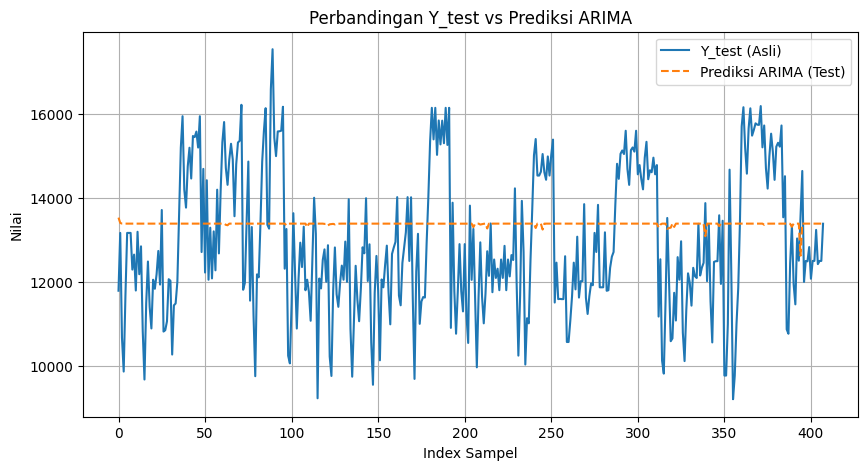

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm

# Misal ini sudah ada dari kamu:
# Y_train, Y_val, Y_test: shape (n_samples, 1), data target train/val/test (scaled)
# exog_train, exog_val, exog_test: shape (n_samples, n_features), exogenous features (scaled)
# scaler_y: scaler untuk inverse transform target y
# Ambil hanya 'Production' sebagai exogenous variable
exog_train = df_train_scaled[['Production']].values
exog_val = df_val_scaled[['Production']].values
exog_test = df_test_scaled[['Production']].values

# =========== Fungsi evaluasi ============
def evaluate_forecast(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

# =========== VALIDATION FORECAST ============

step_val = len(Y_val)  # horizon prediksi validasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
mse_list_val, rmse_list_val, mae_list_val, mape_list_val, r2_list_val = [], [], [], [], []


# Fit model ARIMA sekali saja pakai data training lengkap
model_val = sm.tsa.ARIMA(endog=Y_train.flatten(), exog=exog_train, order=(1,1,1))
model_fit_val = model_val.fit()

# Forecast untuk horizon validasi sekaligus
val_preds_scaled = model_fit_val.forecast(steps=step_val, exog=exog_val)

# Bentuk array prediksi sesuai shape Y_val
val_preds_scaled = np.array(val_preds_scaled).reshape(-1, 1)

# Inverse transform
Y_val_orig = scaler_y.inverse_transform(Y_val)
val_preds_orig = scaler_y.inverse_transform(val_preds_scaled)

# Evaluasi
mse_val, rmse_val, mae_val, mape_val = evaluate_forecast(Y_val_orig, val_preds_orig)
r2_val = r2_score(Y_val_orig, val_preds_orig)

mse_list_val.append(mse_val) 
rmse_list_val.append(rmse_val) 
mae_list_val.append(mae_val) 
mape_list_val.append(mape_val) 
r2_list_val.append(r2_val)

eval_summary_val = {
    'Avg MSE': [np.mean(mse_list_val)],
    'Avg RMSE': [np.mean(rmse_list_val)],
    'Avg MAE': [np.mean(mae_list_val)],
    'Avg MAPE (%)': [np.mean(mape_list_val)],
    'Avg R2': [np.mean(r2_list_val)]
}

df_arima_val = pd.DataFrame(eval_summary_val)

print("\n=== EVALUASI VALIDASI ===")
print(f"VAL MSE: {mse_val:.4f} | RMSE: {rmse_val:.4f} | MAE: {mae_val:.4f} | MAPE: {mape_val:.2f}% | R2: {r2_val:.4f}")

# =========== TEST FORECAST ============

step_test = len(Y_test)  # horizon prediksi test

# Fit model ARIMA sekali saja pakai data training lengkap
model_test = sm.tsa.ARIMA(endog=Y_train.flatten(), exog=exog_train, order=(1,1,1))
model_fit_test = model_test.fit()

# Forecast untuk horizon test sekaligus
test_preds_scaled = model_fit_test.forecast(steps=step_test, exog=exog_test)

test_preds_scaled = np.array(test_preds_scaled).reshape(-1, 1)

# Inverse transform
Y_test_orig = scaler_y.inverse_transform(Y_test)
test_preds_orig = scaler_y.inverse_transform(test_preds_scaled)

# Evaluasi
mse_test, rmse_test, mae_test, mape_test = evaluate_forecast(Y_test_orig, test_preds_orig)
r2_test = r2_score(Y_test_orig, test_preds_orig)

mse_list.append(mse_test) 
rmse_list.append(rmse_test) 
mae_list.append(mae_test) 
mape_list.append(mape_test) 
r2_list.append(r2_test)

eval_summary_test = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

df_arima_test = pd.DataFrame(eval_summary_test)


print("\n=== EVALUASI TEST ===")
print(f"TEST MSE: {mse_test:.4f} | RMSE: {rmse_test:.4f} | MAE: {mae_test:.4f} | MAPE: {mape_test:.2f}% | R2: {r2_test:.4f}")

# =========== PLOT PERBANDINGAN TEST ============

plt.figure(figsize=(10, 5))
plt.plot(Y_test_orig, label='Y_test (Asli)')
plt.plot(test_preds_orig, label='Prediksi ARIMA (Test)', linestyle='--')
plt.title('Perbandingan Y_test vs Prediksi ARIMA')
plt.xlabel('Index Sampel')
plt.ylabel('Nilai')
plt.legend()
plt.grid(True)
plt.show()


## SARIMA


=== EVALUASI VALIDASI ===
VAL MSE: 3627639.6665 | RMSE: 1904.6364 | MAE: 1617.6387 | MAPE: 14.82% | R2: -0.1292

=== EVALUASI TEST ===
TEST MSE: 3123667.1277 | RMSE: 1767.3899 | MAE: 1491.2815 | MAPE: 12.11% | R2: -0.1012


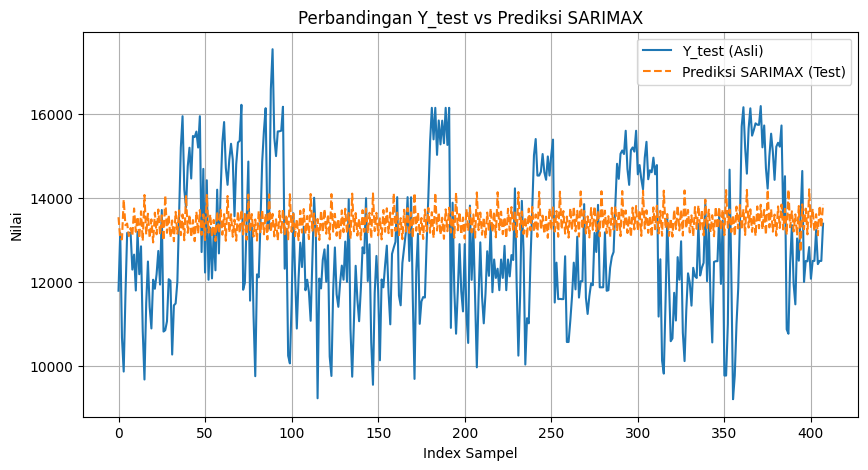

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm

# Contoh order SARIMAX (sesuaikan dengan data dan analisis kamu)
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # misal data bulanan, s=12

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
mse_list_val, rmse_list_val, mae_list_val, mape_list_val, r2_list_val = [], [], [], [], []

# ====================
# ===== VALIDASI =====
# ====================

step_val = len(Y_val)  # horizon prediksi validasi

# Fit SARIMAX model sekali pakai data training lengkap dan exog training
model_val = sm.tsa.SARIMAX(endog=Y_train.flatten(), 
                           exog=exog_train, 
                           order=order, 
                           seasonal_order=seasonal_order,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
model_fit_val = model_val.fit(disp=False)

# Forecast horizon validasi dengan exog validasi
val_preds_scaled = model_fit_val.forecast(steps=step_val, exog=exog_val)
val_preds_scaled = np.array(val_preds_scaled).reshape(-1, 1)

# Inverse transform target dan prediksi
Y_val_orig = scaler_y.inverse_transform(Y_val)
val_preds_orig = scaler_y.inverse_transform(val_preds_scaled)

# Evaluasi validasi
mse_val, rmse_val, mae_val, mape_val = evaluate_forecast(Y_val_orig, val_preds_orig)
r2_val = r2_score(Y_val_orig, val_preds_orig)

mse_list_val.append(mse_val) 
rmse_list_val.append(rmse_val) 
mae_list_val.append(mae_val) 
mape_list_val.append(mape_val) 
r2_list_val.append(r2_val)

eval_summary_val = {
    'Avg MSE': [np.mean(mse_list_val)],
    'Avg RMSE': [np.mean(rmse_list_val)],
    'Avg MAE': [np.mean(mae_list_val)],
    'Avg MAPE (%)': [np.mean(mape_list_val)],
    'Avg R2': [np.mean(r2_list_val)]
}

df_sarima_val = pd.DataFrame(eval_summary_val)

print("\n=== EVALUASI VALIDASI ===")
print(f"VAL MSE: {mse_val:.4f} | RMSE: {rmse_val:.4f} | MAE: {mae_val:.4f} | MAPE: {mape_val:.2f}% | R2: {r2_val:.4f}")

# ====================
# ====== TESTING =====
# ====================

step_test = len(Y_test)

# Fit SARIMAX model sekali pakai data training lengkap dan exog training (bisa juga pakai model_val jika ingin efisien)
model_test = sm.tsa.SARIMAX(endog=Y_train.flatten(), 
                            exog=exog_train, 
                            order=order, 
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
model_fit_test = model_test.fit(disp=False)

# Forecast horizon test dengan exog test
test_preds_scaled = model_fit_test.forecast(steps=step_test, exog=exog_test)
test_preds_scaled = np.array(test_preds_scaled).reshape(-1, 1)

# Inverse transform target dan prediksi test
Y_test_orig = scaler_y.inverse_transform(Y_test)
test_preds_orig = scaler_y.inverse_transform(test_preds_scaled)

# Evaluasi test
mse_test, rmse_test, mae_test, mape_test = evaluate_forecast(Y_test_orig, test_preds_orig)
r2_test = r2_score(Y_test_orig, test_preds_orig)

mse_list.append(mse_test) 
rmse_list.append(rmse_test) 
mae_list.append(mae_test) 
mape_list.append(mape_test) 
r2_list.append(r2_test)

eval_summary_test = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

df_sarima_test = pd.DataFrame(eval_summary_test)

print("\n=== EVALUASI TEST ===")
print(f"TEST MSE: {mse_test:.4f} | RMSE: {rmse_test:.4f} | MAE: {mae_test:.4f} | MAPE: {mape_test:.2f}% | R2: {r2_test:.4f}")

# ====================
# ====== PLOT ========
# ====================

plt.figure(figsize=(10, 5))
plt.plot(Y_test_orig, label='Y_test (Asli)')
plt.plot(test_preds_orig, label='Prediksi SARIMAX (Test)', linestyle='--')
plt.title('Perbandingan Y_test vs Prediksi SARIMAX')
plt.xlabel('Index Sampel')
plt.ylabel('Nilai')
plt.legend()
plt.grid(True)
plt.show()


## ADABOOST

In [76]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Tambahkan epsilon untuk hindari div 0
    return mse, rmse, mae, mape

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
mse_list_val, rmse_list_val, mae_list_val, mape_list_val, r2_list_val = [], [], [], [], []
# Reshape data untuk ExtraTrees: (samples, features)
X_train_reshaped = X_train
X_test_reshaped = X_test

# Karena ExtraTrees tidak support multivariate output langsung, buat model per langkah ke depan
preds_list = []
preds_list_val = []

model = AdaBoostRegressor(n_estimators=100, random_state=42)
model.fit(X_train_reshaped, Y_train)
preds = model.predict(X_test_reshaped)
preds_val = model.predict(X_val)
preds_list.append(preds)
preds_list_val.append(preds_val)

# Gabungkan prediksi ke array 2D: (n_samples, step)
adaboost_preds = np.column_stack(preds_list)
adaboost_preds_val = np.column_stack(preds_list_val)

# === Inverse transform sebelum evaluasi ===
scaler_target = scaler_y  # pakai scaler_y dari provinsi pertama fold ini
Y_test_orig = scaler_target.inverse_transform(Y_test)
Y_val_orig = scaler_target.inverse_transform(Y_val)
adaboost_preds_orig = scaler_target.inverse_transform(adaboost_preds)
adaboost_preds_orig_val = scaler_target.inverse_transform(adaboost_preds_val)

# Evaluasi hasil prediksi ExtraTrees
mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, adaboost_preds_orig)
r2 = r2_score(Y_test_orig.flatten(), adaboost_preds_orig.flatten())

mse_val, rmse_val, mae_val, mape_val = evaluate_forecast(Y_test_orig, adaboost_preds_orig)
r2_val = r2_score(Y_val_orig.flatten(), adaboost_preds_orig_val.flatten())

mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

mse_list_val.append(mse_val)
rmse_list_val.append(rmse_val)
mae_list_val.append(mae_val)
mape_list_val.append(mape_val)
r2_list_val.append(r2_val)

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI TEST ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary_test = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Buat DataFrame
df_adaboost_test = pd.DataFrame(eval_summary_test)

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI VAL ===")
print(f"Avg MSE VAL: {np.mean(mse_list_val):.4f}")
print(f"Avg RMSE VAL: {np.mean(rmse_list_val):.4f}")
print(f"Avg MAE VAL: {np.mean(mae_list_val):.4f}")
print(f"Avg MAPE VAL: {np.mean(mape_list_val):.2f}%")
print(f"Avg R2 VAL: {np.mean(r2_list_val):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary_val = {
    'Avg MSE': [np.mean(mse_list_val)],
    'Avg RMSE': [np.mean(rmse_list_val)],
    'Avg MAE': [np.mean(mae_list_val)],
    'Avg MAPE (%)': [np.mean(mape_list_val)],
    'Avg R2': [np.mean(r2_list_val)]
}

# Buat DataFrame
df_adaboost_val = pd.DataFrame(eval_summary_val)



=== RATA-RATA EVALUASI TEST ===
Avg MSE: 154732.5316
Avg RMSE: 393.3606
Avg MAE: 302.8206
Avg MAPE: 2.41%
Avg R2: 0.9455

=== RATA-RATA EVALUASI VAL ===
Avg MSE VAL: 154732.5316
Avg RMSE VAL: 393.3606
Avg MAE VAL: 302.8206
Avg MAPE VAL: 2.41%
Avg R2 VAL: 0.9153


## EXTRATREES REGRESSOR 

In [77]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Tambahkan epsilon untuk hindari div 0
    return mse, rmse, mae, mape

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
mse_list_val, rmse_list_val, mae_list_val, mape_list_val, r2_list_val = [], [], [], [], []
# Reshape data untuk ExtraTrees: (samples, features)
X_train_reshaped = X_train
X_test_reshaped = X_test

# Karena ExtraTrees tidak support multivariate output langsung, buat model per langkah ke depan
preds_list = []
preds_list_val = []

model = ExtraTreesRegressor(n_estimators=100, random_state=42)
model.fit(X_train_reshaped, Y_train)
preds = model.predict(X_test_reshaped)
preds_val = model.predict(X_val)
preds_list.append(preds)
preds_list_val.append(preds_val)

# Gabungkan prediksi ke array 2D: (n_samples, step)
extratrees_preds = np.column_stack(preds_list)
extratrees_preds_val = np.column_stack(preds_list_val)

# === Inverse transform sebelum evaluasi ===
scaler_target = scaler_y  # pakai scaler_y dari provinsi pertama fold ini
Y_test_orig = scaler_target.inverse_transform(Y_test)
Y_val_orig = scaler_target.inverse_transform(Y_val)
extratrees_preds_orig = scaler_target.inverse_transform(extratrees_preds)
extratrees_preds_orig_val = scaler_target.inverse_transform(extratrees_preds_val)

# Evaluasi hasil prediksi ExtraTrees
mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, extratrees_preds_orig)
r2 = r2_score(Y_test_orig.flatten(), extratrees_preds_orig.flatten())

mse_val, rmse_val, mae_val, mape_val = evaluate_forecast(Y_test_orig, extratrees_preds_orig)
r2_val = r2_score(Y_val_orig.flatten(), extratrees_preds_orig_val.flatten())

mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

mse_list_val.append(mse_val)
rmse_list_val.append(rmse_val)
mae_list_val.append(mae_val)
mape_list_val.append(mape_val)
r2_list_val.append(r2_val)

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI TEST ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary_test = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Buat DataFrame
df_extratrees_test = pd.DataFrame(eval_summary_test)

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI VAL ===")
print(f"Avg MSE VAL: {np.mean(mse_list_val):.4f}")
print(f"Avg RMSE VAL: {np.mean(rmse_list_val):.4f}")
print(f"Avg MAE VAL: {np.mean(mae_list_val):.4f}")
print(f"Avg MAPE VAL: {np.mean(mape_list_val):.2f}%")
print(f"Avg R2 VAL: {np.mean(r2_list_val):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary_val = {
    'Avg MSE': [np.mean(mse_list_val)],
    'Avg RMSE': [np.mean(rmse_list_val)],
    'Avg MAE': [np.mean(mae_list_val)],
    'Avg MAPE (%)': [np.mean(mape_list_val)],
    'Avg R2': [np.mean(r2_list_val)]
}

# Buat DataFrame
df_extratrees_val = pd.DataFrame(eval_summary_val)



=== RATA-RATA EVALUASI TEST ===
Avg MSE: 81487.1039
Avg RMSE: 285.4595
Avg MAE: 182.9691
Avg MAPE: 1.43%
Avg R2: 0.9713

=== RATA-RATA EVALUASI VAL ===
Avg MSE VAL: 81487.1039
Avg RMSE VAL: 285.4595
Avg MAE VAL: 182.9691
Avg MAPE VAL: 1.43%
Avg R2 VAL: 0.9298


## GRADIENT BOOSTING

In [78]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Tambahkan epsilon untuk hindari div 0
    return mse, rmse, mae, mape

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
mse_list_val, rmse_list_val, mae_list_val, mape_list_val, r2_list_val = [], [], [], [], []
# Reshape data untuk ExtraTrees: (samples, features)
X_train_reshaped = X_train
X_test_reshaped = X_test

# Karena ExtraTrees tidak support multivariate output langsung, buat model per langkah ke depan
preds_list = []
preds_list_val = []

model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train_reshaped, Y_train)
preds = model.predict(X_test_reshaped)
preds_val = model.predict(X_val)
preds_list.append(preds)
preds_list_val.append(preds_val)

# Gabungkan prediksi ke array 2D: (n_samples, step)
gbr_preds = np.column_stack(preds_list)
gbr_preds_val = np.column_stack(preds_list_val)

# === Inverse transform sebelum evaluasi ===
scaler_target = scaler_y  # pakai scaler_y dari provinsi pertama fold ini
Y_test_orig = scaler_target.inverse_transform(Y_test)
Y_val_orig = scaler_target.inverse_transform(Y_val)
gbr_preds_orig = scaler_target.inverse_transform(gbr_preds)
gbr_preds_orig_val = scaler_target.inverse_transform(gbr_preds_val)

# Evaluasi hasil prediksi ExtraTrees
mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, gbr_preds_orig)
r2 = r2_score(Y_test_orig.flatten(), gbr_preds_orig.flatten())

mse_val, rmse_val, mae_val, mape_val = evaluate_forecast(Y_test_orig, gbr_preds_orig)
r2_val = r2_score(Y_val_orig.flatten(), gbr_preds_orig_val.flatten())

mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

mse_list_val.append(mse_val)
rmse_list_val.append(rmse_val)
mae_list_val.append(mae_val)
mape_list_val.append(mape_val)
r2_list_val.append(r2_val)

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI TEST ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary_test = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Buat DataFrame
df_gbr_test = pd.DataFrame(eval_summary_test)

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI VAL ===")
print(f"Avg MSE VAL: {np.mean(mse_list_val):.4f}")
print(f"Avg RMSE VAL: {np.mean(rmse_list_val):.4f}")
print(f"Avg MAE VAL: {np.mean(mae_list_val):.4f}")
print(f"Avg MAPE VAL: {np.mean(mape_list_val):.2f}%")
print(f"Avg R2 VAL: {np.mean(r2_list_val):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary_val = {
    'Avg MSE': [np.mean(mse_list_val)],
    'Avg RMSE': [np.mean(rmse_list_val)],
    'Avg MAE': [np.mean(mae_list_val)],
    'Avg MAPE (%)': [np.mean(mape_list_val)],
    'Avg R2': [np.mean(r2_list_val)]
}

# Buat DataFrame
df_gbr_val = pd.DataFrame(eval_summary_val)



=== RATA-RATA EVALUASI TEST ===
Avg MSE: 52079.5053
Avg RMSE: 228.2093
Avg MAE: 162.2116
Avg MAPE: 1.28%
Avg R2: 0.9816

=== RATA-RATA EVALUASI VAL ===
Avg MSE VAL: 52079.5053
Avg RMSE VAL: 228.2093
Avg MAE VAL: 162.2116
Avg MAPE VAL: 1.28%
Avg R2 VAL: 0.9364


## RANDOM FOREST

In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Tambahkan epsilon untuk hindari div 0
    return mse, rmse, mae, mape

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
mse_list_val, rmse_list_val, mae_list_val, mape_list_val, r2_list_val = [], [], [], [], []
# Reshape data untuk ExtraTrees: (samples, features)
X_train_reshaped = X_train
X_test_reshaped = X_test

# Karena ExtraTrees tidak support multivariate output langsung, buat model per langkah ke depan
preds_list = []
preds_list_val = []

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_reshaped, Y_train)
preds = model.predict(X_test_reshaped)
preds_val = model.predict(X_val)
preds_list.append(preds)
preds_list_val.append(preds_val)

# Gabungkan prediksi ke array 2D: (n_samples, step)
rf_preds = np.column_stack(preds_list)
rf_preds_val = np.column_stack(preds_list_val)

# === Inverse transform sebelum evaluasi ===
scaler_target = scaler_y  # pakai scaler_y dari provinsi pertama fold ini
Y_test_orig = scaler_target.inverse_transform(Y_test)
Y_val_orig = scaler_target.inverse_transform(Y_val)
rf_preds_orig = scaler_target.inverse_transform(rf_preds)
rf_preds_orig_val = scaler_target.inverse_transform(rf_preds_val)

# Evaluasi hasil prediksi ExtraTrees
mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, rf_preds_orig)
r2 = r2_score(Y_test_orig.flatten(), rf_preds_orig.flatten())

mse_val, rmse_val, mae_val, mape_val = evaluate_forecast(Y_test_orig, rf_preds_orig)
r2_val = r2_score(Y_val_orig.flatten(), rf_preds_orig_val.flatten())

mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

mse_list_val.append(mse_val)
rmse_list_val.append(rmse_val)
mae_list_val.append(mae_val)
mape_list_val.append(mape_val)
r2_list_val.append(r2_val)

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI TEST ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary_test = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Buat DataFrame
df_rf_test = pd.DataFrame(eval_summary_test)

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI VAL ===")
print(f"Avg MSE VAL: {np.mean(mse_list_val):.4f}")
print(f"Avg RMSE VAL: {np.mean(rmse_list_val):.4f}")
print(f"Avg MAE VAL: {np.mean(mae_list_val):.4f}")
print(f"Avg MAPE VAL: {np.mean(mape_list_val):.2f}%")
print(f"Avg R2 VAL: {np.mean(r2_list_val):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary_val = {
    'Avg MSE': [np.mean(mse_list_val)],
    'Avg RMSE': [np.mean(rmse_list_val)],
    'Avg MAE': [np.mean(mae_list_val)],
    'Avg MAPE (%)': [np.mean(mape_list_val)],
    'Avg R2': [np.mean(r2_list_val)]
}

# Buat DataFrame
df_rf_val = pd.DataFrame(eval_summary_val)



=== RATA-RATA EVALUASI TEST ===
Avg MSE: 85194.6563
Avg RMSE: 291.8812
Avg MAE: 179.0021
Avg MAPE: 1.41%
Avg R2: 0.9700

=== RATA-RATA EVALUASI VAL ===
Avg MSE VAL: 85194.6563
Avg RMSE VAL: 291.8812
Avg MAE VAL: 179.0021
Avg MAPE VAL: 1.41%
Avg R2 VAL: 0.9312


## LSTM 

In [80]:
def build_lstm_model(input_shape, output_size):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.3))
    
    model.add(LSTM(units=32))
    model.add(Dropout(0.3))
    
    model.add(Dense(output_size))
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model

def train_lstm_keras(X_train, Y_train, X_val, Y_val, input_shape, output_size, epochs=100, batch_size=32):
    model = build_lstm_model(input_shape, output_size)
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )
    return model

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

2025-06-10 08:27:33.382922: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.2212 - val_loss: 0.1724 - learning_rate: 1.0000e-04
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1746 - val_loss: 0.0860 - learning_rate: 1.0000e-04
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0683 - val_loss: 0.0320 - learning_rate: 1.0000e-04
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0381 - val_loss: 0.0264 - learning_rate: 1.0000e-04
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0331 - val_loss: 0.0209 - learning_rate: 1.0000e-04
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0263 - val_loss: 0.0158 - learning_rate: 1.0000e-04
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0208 - val_loss: 0.0109 - learning_rate: 1.0000e-04
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0152 - val_loss: 0.0072 - learning_rate: 1.0000e-04
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0121 - val_loss:

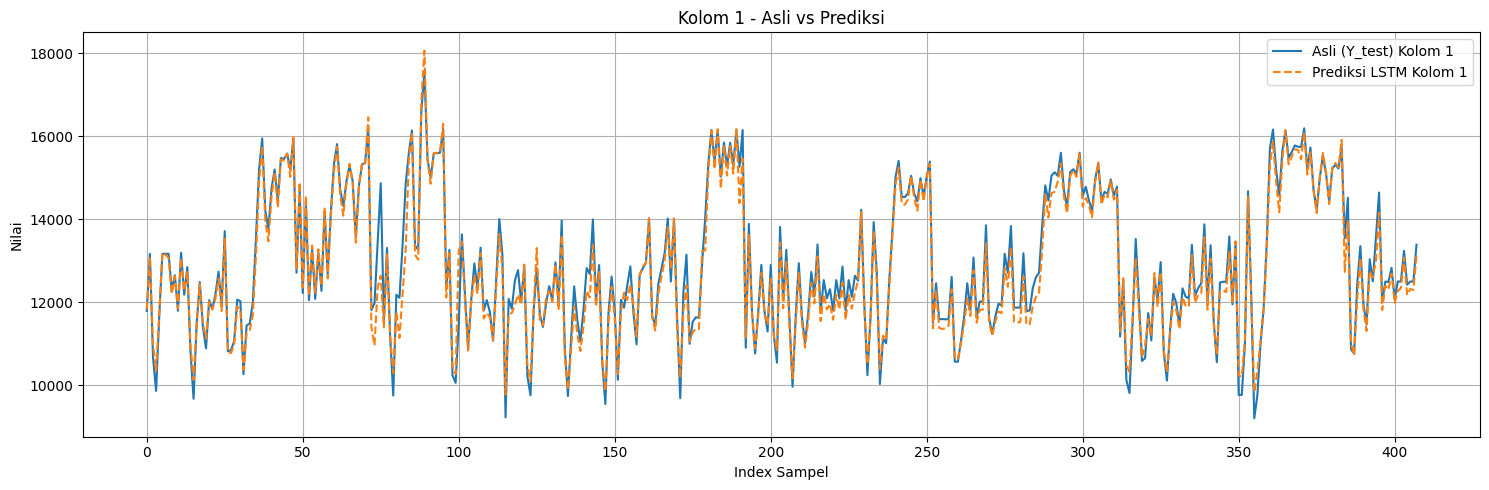

In [81]:
# Definisikan callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',      # Pantau validasi loss
    patience=15,              # Tunggu 5 epoch tanpa perbaikan
    restore_best_weights=True # Kembalikan bobot terbaik saat selesai training
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # Pantau validasi loss
    factor=0.5,              # Kurangi lr jadi setengahnya
    patience=5,              # Tunggu 3 epoch tanpa perbaikan

)

X_train_lstm = X_train.reshape(-1,1,X_train.shape[1])
X_test_lstm = X_test.reshape(-1,1,X_test.shape[1])
X_val_lstm = X_val.reshape(-1,1,X_val.shape[1])

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
mse_list_val, rmse_list_val, mae_list_val, mape_list_val, r2_list_val = [], [], [], [], []

input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])  # (lookback, num_features)
output_size = Y_train.shape[1]  # step

# Train LSTM
lstm_model = train_lstm_keras(X_train_lstm, Y_train, X_val_lstm, Y_val, input_shape, output_size, epochs=100, batch_size=32)
lstm_model_val = train_lstm_keras(X_train_lstm, Y_train, X_test_lstm, Y_test, input_shape, output_size, epochs=100, batch_size=32)
# Prediksi dengan LSTM
lstm_preds = lstm_model.predict(X_test_lstm)  # shape (n_samples, step)
lstm_preds_val = lstm_model_val.predict(X_val_lstm) 
# === Inverse transform sebelum evaluasi ===
scaler_target = scaler_y  # hanya pakai scaler_y dari provinsi pertama di fold ini
Y_test_orig = scaler_target.inverse_transform(Y_test)
lstm_preds_orig = scaler_target.inverse_transform(lstm_preds)
Y_val_orig = scaler_target.inverse_transform(Y_val)
lstm_preds_orig_val = scaler_target.inverse_transform(lstm_preds_val)

# Evaluasi hasil prediksi LSTM
mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, lstm_preds_orig)
r2 = r2_score(Y_test_orig.flatten(), lstm_preds_orig.flatten())

mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

mse_val, rmse_val, mae_val, mape_val = evaluate_forecast(Y_val_orig, lstm_preds_orig_val)
r2_val = r2_score(Y_val_orig.flatten(), lstm_preds_orig_val.flatten())

mse_list_val.append(mse_val)
rmse_list_val.append(rmse_val)
mae_list_val.append(mae_val)
mape_list_val.append(mape_val)
r2_list_val.append(r2_val)

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI TEST ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary_test = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI VAL ===")
print(f"Avg MSE: {np.mean(mse_list_val):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list_val):.4f}")
print(f"Avg MAE: {np.mean(mae_list_val):.4f}")
print(f"Avg MAPE: {np.mean(mape_list_val):.2f}%")
print(f"Avg R2: {np.mean(r2_list_val):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary_val = {
    'Avg MSE': [np.mean(mse_list_val)],
    'Avg RMSE': [np.mean(rmse_list_val)],
    'Avg MAE': [np.mean(mae_list_val)],
    'Avg MAPE (%)': [np.mean(mape_list_val)],
    'Avg R2': [np.mean(r2_list_val)]
}
# Buat DataFrame
df_lstm_test = pd.DataFrame(eval_summary_test)
# Buat DataFrame
df_lstm_val = pd.DataFrame(eval_summary_val)

Y_test_orig = pd.DataFrame(Y_test_orig)
lstm_preds_orig = pd.DataFrame(lstm_preds_orig)

num_cols = Y_test_orig.shape[1]

plt.figure(figsize=(15, 5 * num_cols))
for i in range(num_cols):
    plt.subplot(num_cols, 1, i + 1)
    plt.plot(Y_test_orig.iloc[:, i], label=f'Asli (Y_test) Kolom {i+1}')
    plt.plot(lstm_preds_orig.iloc[:, i], label=f'Prediksi LSTM Kolom {i+1}', linestyle='--')
    plt.title(f'Kolom {i+1} - Asli vs Prediksi')
    plt.xlabel('Index Sampel')
    plt.ylabel('Nilai')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# STANDALONE MODELS - DENGAN DATA HASIL GWPR

In [82]:
df_fix.columns

Index(['Province', 'Year', 'Month', 'Production', 'Importation', 'Demand',
       'Supply', 'Price', 'Population', 'Religious Holiday', 'intercept',
       'Production_coef', 'Importation_coef', 'Demand_coef', 'Supply_coef',
       'Population_coef', 'Religious Holiday_coef', 'Production_pvalue',
       'Importation_pvalue', 'Demand_pvalue', 'Supply_pvalue',
       'Population_pvalue', 'Religious Holiday_pvalue', 'Predicted',
       'Residual'],
      dtype='object')

In [83]:
# ========== CELL 2: Split 2 ==========

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Urutkan data
df_fix = df_fix.sort_values(by=['Province', 'Year', 'Month'])

# Split data per provinsi: train (80%), val (10%), test (10%)
train_list, val_list, test_list = [], [], []

for province, group in df_fix.groupby('Province'):
    assert len(group) == 120, f"{province} has {len(group)} rows instead of 120"
    
    train = group.iloc[:96]
    val = group.iloc[96:108]
    test = group.iloc[108:]
    
    train_list.append(train)
    val_list.append(val)
    test_list.append(test)

df_train = pd.concat(train_list)
df_val = pd.concat(val_list)
df_test = pd.concat(test_list)

print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

# Kolom yang dipakai
feature_cols = ['Production', 'Importation', 'Demand', 'Supply', 'Population', 'Religious Holiday', 
                'intercept', 'Production_coef', 'Importation_coef', 'Demand_coef', 'Supply_coef',
                'Population_coef', 'Religious Holiday_coef', 'Production_pvalue', 'Importation_pvalue',
                'Demand_pvalue', 'Supply_pvalue', 'Population_pvalue', 'Religious Holiday_pvalue', 
                'Predicted', 'Residual']
target_col = 'Price'

# Scaling per provinsi
scaled_train_list, scaled_val_list, scaled_test_list = [], [], []

for province in df_train['Province'].unique():
    train_group = df_train[df_train['Province'] == province].copy()
    val_group = df_val[df_val['Province'] == province].copy()
    test_group = df_test[df_test['Province'] == province].copy()

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaler_X.fit(train_group[feature_cols])
    scaler_y.fit(train_group[[target_col]])

    train_group[feature_cols] = scaler_X.transform(train_group[feature_cols])
    train_group[target_col] = scaler_y.transform(train_group[[target_col]])

    val_group[feature_cols] = scaler_X.transform(val_group[feature_cols])
    val_group[target_col] = scaler_y.transform(val_group[[target_col]])

    test_group[feature_cols] = scaler_X.transform(test_group[feature_cols])
    test_group[target_col] = scaler_y.transform(test_group[[target_col]])

    scaled_train_list.append(train_group)
    scaled_val_list.append(val_group)
    scaled_test_list.append(test_group)

# Gabungkan semua hasil scaling
df_train_scaled = pd.concat(scaled_train_list)
df_val_scaled = pd.concat(scaled_val_list)
df_test_scaled = pd.concat(scaled_test_list)

# Buat X dan y
X_train = df_train_scaled[feature_cols].values
Y_train = df_train_scaled[target_col].values

X_val = df_val_scaled[feature_cols].values
Y_val = df_val_scaled[target_col].values

X_test = df_test_scaled[feature_cols].values
Y_test = df_test_scaled[target_col].values

# Reshape target
Y_train = Y_train.reshape(-1, 1)
Y_val = Y_val.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

print("X_train shape:", X_train.shape)
print("y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", Y_test.shape)


Train shape: (3264, 25)
Validation shape: (408, 25)
Test shape: (408, 25)
X_train shape: (3264, 21)
y_train shape: (3264, 1)
X_val shape: (408, 21)
y_val shape: (408, 1)
X_test shape: (408, 21)
y_test shape: (408, 1)


## ARIMA - DENGAN GWPR


=== EVALUASI VALIDASI ===
VAL MSE: 64239.2357 | RMSE: 253.4546 | MAE: 167.7909 | MAPE: 1.36% | R2: 0.9800

=== EVALUASI TEST ===
TEST MSE: 207661.2692 | RMSE: 455.6987 | MAE: 365.7787 | MAPE: 2.92% | R2: 0.9268


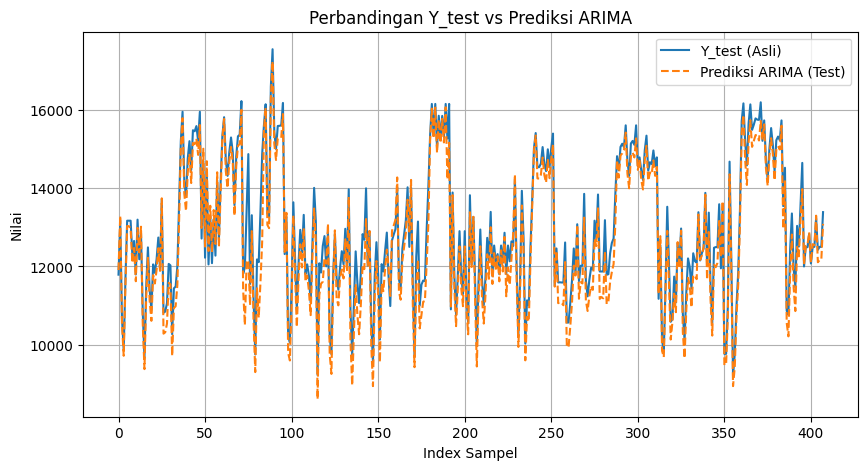

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm

# Misal ini sudah ada dari kamu:
# Y_train, Y_val, Y_test: shape (n_samples, 1), data target train/val/test (scaled)
# exog_train, exog_val, exog_test: shape (n_samples, n_features), exogenous features (scaled)
# scaler_y: scaler untuk inverse transform target y
# Ambil hanya 'Production' sebagai exogenous variable
exog_train = df_train_scaled[['Residual']].values
exog_val = df_val_scaled[['Residual']].values
exog_test = df_test_scaled[['Residual']].values

# =========== Fungsi evaluasi ============
def evaluate_forecast(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

# =========== VALIDATION FORECAST ============

step_val = len(Y_val)  # horizon prediksi validasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
mse_list_val, rmse_list_val, mae_list_val, mape_list_val, r2_list_val = [], [], [], [], []


# Fit model ARIMA sekali saja pakai data training lengkap
model_val = sm.tsa.ARIMA(endog=Y_train.flatten(), exog=exog_train, order=(1,1,1))
model_fit_val = model_val.fit()

# Forecast untuk horizon validasi sekaligus
val_preds_scaled = model_fit_val.forecast(steps=step_val, exog=exog_val)

# Bentuk array prediksi sesuai shape Y_val
val_preds_scaled = np.array(val_preds_scaled).reshape(-1, 1)

# Inverse transform
Y_val_orig = scaler_y.inverse_transform(Y_val)
val_preds_orig = scaler_y.inverse_transform(val_preds_scaled)

# Evaluasi
mse_val, rmse_val, mae_val, mape_val = evaluate_forecast(Y_val_orig, val_preds_orig)
r2_val = r2_score(Y_val_orig, val_preds_orig)

mse_list_val.append(mse_val) 
rmse_list_val.append(rmse_val) 
mae_list_val.append(mae_val) 
mape_list_val.append(mape_val) 
r2_list_val.append(r2_val)

eval_summary_val = {
    'Avg MSE': [np.mean(mse_list_val)],
    'Avg RMSE': [np.mean(rmse_list_val)],
    'Avg MAE': [np.mean(mae_list_val)],
    'Avg MAPE (%)': [np.mean(mape_list_val)],
    'Avg R2': [np.mean(r2_list_val)]
}

df_arima_val_gwpr = pd.DataFrame(eval_summary_val)

print("\n=== EVALUASI VALIDASI ===")
print(f"VAL MSE: {mse_val:.4f} | RMSE: {rmse_val:.4f} | MAE: {mae_val:.4f} | MAPE: {mape_val:.2f}% | R2: {r2_val:.4f}")

# =========== TEST FORECAST ============

step_test = len(Y_test)  # horizon prediksi test

# Fit model ARIMA sekali saja pakai data training lengkap
model_test = sm.tsa.ARIMA(endog=Y_train.flatten(), exog=exog_train, order=(1,1,1))
model_fit_test = model_test.fit()

# Forecast untuk horizon test sekaligus
test_preds_scaled = model_fit_test.forecast(steps=step_test, exog=exog_test)

test_preds_scaled = np.array(test_preds_scaled).reshape(-1, 1)

# Inverse transform
Y_test_orig = scaler_y.inverse_transform(Y_test)
test_preds_orig = scaler_y.inverse_transform(test_preds_scaled)

# Evaluasi
mse_test, rmse_test, mae_test, mape_test = evaluate_forecast(Y_test_orig, test_preds_orig)
r2_test = r2_score(Y_test_orig, test_preds_orig)

mse_list.append(mse_test) 
rmse_list.append(rmse_test) 
mae_list.append(mae_test) 
mape_list.append(mape_test) 
r2_list.append(r2_test)

eval_summary_test = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

df_arima_test_gwpr = pd.DataFrame(eval_summary_test)


print("\n=== EVALUASI TEST ===")
print(f"TEST MSE: {mse_test:.4f} | RMSE: {rmse_test:.4f} | MAE: {mae_test:.4f} | MAPE: {mape_test:.2f}% | R2: {r2_test:.4f}")

# =========== PLOT PERBANDINGAN TEST ============

plt.figure(figsize=(10, 5))
plt.plot(Y_test_orig, label='Y_test (Asli)')
plt.plot(test_preds_orig, label='Prediksi ARIMA (Test)', linestyle='--')
plt.title('Perbandingan Y_test vs Prediksi ARIMA')
plt.xlabel('Index Sampel')
plt.ylabel('Nilai')
plt.legend()
plt.grid(True)
plt.show()


## SARIMA - DENGAN GWPR


=== EVALUASI VALIDASI ===
VAL MSE: 64555.7562 | RMSE: 254.0782 | MAE: 167.0803 | MAPE: 1.35% | R2: 0.9799

=== EVALUASI TEST ===
TEST MSE: 202996.1617 | RMSE: 450.5510 | MAE: 361.2604 | MAPE: 2.87% | R2: 0.9284


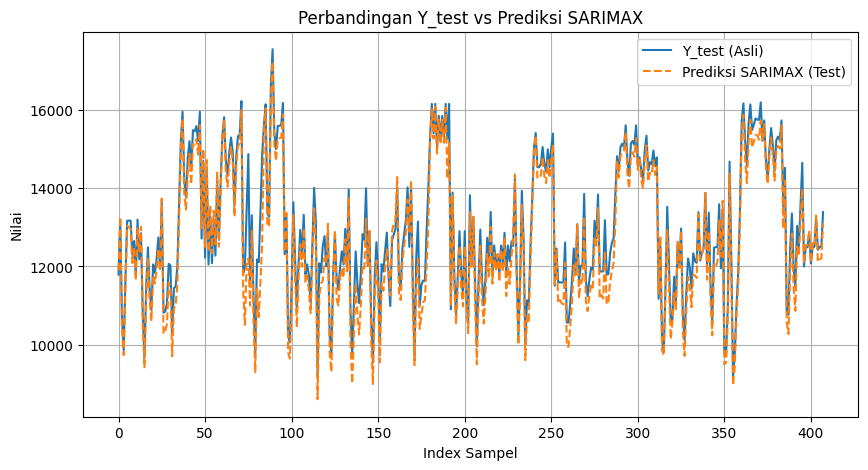

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm

# Contoh order SARIMAX (sesuaikan dengan data dan analisis kamu)
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)  # misal data bulanan, s=12
exog_train = df_train_scaled[['Residual']].values
exog_val = df_val_scaled[['Residual']].values
exog_test = df_test_scaled[['Residual']].values

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
mse_list_val, rmse_list_val, mae_list_val, mape_list_val, r2_list_val = [], [], [], [], []

# ====================
# ===== VALIDASI =====
# ====================

step_val = len(Y_val)  # horizon prediksi validasi

# Fit SARIMAX model sekali pakai data training lengkap dan exog training
model_val = sm.tsa.SARIMAX(endog=Y_train.flatten(), 
                           exog=exog_train, 
                           order=order, 
                           seasonal_order=seasonal_order,
                           enforce_stationarity=False,
                           enforce_invertibility=False)
model_fit_val = model_val.fit(disp=False)

# Forecast horizon validasi dengan exog validasi
val_preds_scaled = model_fit_val.forecast(steps=step_val, exog=exog_val)
val_preds_scaled = np.array(val_preds_scaled).reshape(-1, 1)

# Inverse transform target dan prediksi
Y_val_orig = scaler_y.inverse_transform(Y_val)
val_preds_orig = scaler_y.inverse_transform(val_preds_scaled)

# Evaluasi validasi
mse_val, rmse_val, mae_val, mape_val = evaluate_forecast(Y_val_orig, val_preds_orig)
r2_val = r2_score(Y_val_orig, val_preds_orig)

mse_list_val.append(mse_val) 
rmse_list_val.append(rmse_val) 
mae_list_val.append(mae_val) 
mape_list_val.append(mape_val) 
r2_list_val.append(r2_val)

eval_summary_val = {
    'Avg MSE': [np.mean(mse_list_val)],
    'Avg RMSE': [np.mean(rmse_list_val)],
    'Avg MAE': [np.mean(mae_list_val)],
    'Avg MAPE (%)': [np.mean(mape_list_val)],
    'Avg R2': [np.mean(r2_list_val)]
}

df_sarima_val_gwpr = pd.DataFrame(eval_summary_val)

print("\n=== EVALUASI VALIDASI ===")
print(f"VAL MSE: {mse_val:.4f} | RMSE: {rmse_val:.4f} | MAE: {mae_val:.4f} | MAPE: {mape_val:.2f}% | R2: {r2_val:.4f}")

# ====================
# ====== TESTING =====
# ====================

step_test = len(Y_test)

# Fit SARIMAX model sekali pakai data training lengkap dan exog training (bisa juga pakai model_val jika ingin efisien)
model_test = sm.tsa.SARIMAX(endog=Y_train.flatten(), 
                            exog=exog_train, 
                            order=order, 
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
model_fit_test = model_test.fit(disp=False)

# Forecast horizon test dengan exog test
test_preds_scaled = model_fit_test.forecast(steps=step_test, exog=exog_test)
test_preds_scaled = np.array(test_preds_scaled).reshape(-1, 1)

# Inverse transform target dan prediksi test
Y_test_orig = scaler_y.inverse_transform(Y_test)
test_preds_orig = scaler_y.inverse_transform(test_preds_scaled)

# Evaluasi test
mse_test, rmse_test, mae_test, mape_test = evaluate_forecast(Y_test_orig, test_preds_orig)
r2_test = r2_score(Y_test_orig, test_preds_orig)

mse_list.append(mse_test) 
rmse_list.append(rmse_test) 
mae_list.append(mae_test) 
mape_list.append(mape_test) 
r2_list.append(r2_test)

eval_summary_test = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

df_sarima_test_gwpr = pd.DataFrame(eval_summary_test)

print("\n=== EVALUASI TEST ===")
print(f"TEST MSE: {mse_test:.4f} | RMSE: {rmse_test:.4f} | MAE: {mae_test:.4f} | MAPE: {mape_test:.2f}% | R2: {r2_test:.4f}")

# ====================
# ====== PLOT ========
# ====================

plt.figure(figsize=(10, 5))
plt.plot(Y_test_orig, label='Y_test (Asli)')
plt.plot(test_preds_orig, label='Prediksi SARIMAX (Test)', linestyle='--')
plt.title('Perbandingan Y_test vs Prediksi SARIMAX')
plt.xlabel('Index Sampel')
plt.ylabel('Nilai')
plt.legend()
plt.grid(True)
plt.show()


## ADABOOST - DENGAN GWPR

In [86]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Tambahkan epsilon untuk hindari div 0
    return mse, rmse, mae, mape

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
mse_list_val, rmse_list_val, mae_list_val, mape_list_val, r2_list_val = [], [], [], [], []
# Reshape data untuk ExtraTrees: (samples, features)
X_train_reshaped = X_train
X_test_reshaped = X_test

# Karena ExtraTrees tidak support multivariate output langsung, buat model per langkah ke depan
preds_list = []
preds_list_val = []

model = AdaBoostRegressor(n_estimators=100, random_state=42)
model.fit(X_train_reshaped, Y_train)
preds = model.predict(X_test_reshaped)
preds_val = model.predict(X_val)
preds_list.append(preds)
preds_list_val.append(preds_val)

# Gabungkan prediksi ke array 2D: (n_samples, step)
adaboost_preds = np.column_stack(preds_list)
adaboost_preds_val = np.column_stack(preds_list_val)

# === Inverse transform sebelum evaluasi ===
scaler_target = scaler_y  # pakai scaler_y dari provinsi pertama fold ini
Y_test_orig = scaler_target.inverse_transform(Y_test)
Y_val_orig = scaler_target.inverse_transform(Y_val)
adaboost_preds_orig = scaler_target.inverse_transform(adaboost_preds)
adaboost_preds_orig_val = scaler_target.inverse_transform(adaboost_preds_val)

# Evaluasi hasil prediksi ExtraTrees
mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, adaboost_preds_orig)
r2 = r2_score(Y_test_orig.flatten(), adaboost_preds_orig.flatten())

mse_val, rmse_val, mae_val, mape_val = evaluate_forecast(Y_test_orig, adaboost_preds_orig)
r2_val = r2_score(Y_val_orig.flatten(), adaboost_preds_orig_val.flatten())

mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

mse_list_val.append(mse_val)
rmse_list_val.append(rmse_val)
mae_list_val.append(mae_val)
mape_list_val.append(mape_val)
r2_list_val.append(r2_val)

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI TEST ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary_test = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Buat DataFrame
df_adaboost_test_gwpr = pd.DataFrame(eval_summary_test)

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI VAL ===")
print(f"Avg MSE VAL: {np.mean(mse_list_val):.4f}")
print(f"Avg RMSE VAL: {np.mean(rmse_list_val):.4f}")
print(f"Avg MAE VAL: {np.mean(mae_list_val):.4f}")
print(f"Avg MAPE VAL: {np.mean(mape_list_val):.2f}%")
print(f"Avg R2 VAL: {np.mean(r2_list_val):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary_val = {
    'Avg MSE': [np.mean(mse_list_val)],
    'Avg RMSE': [np.mean(rmse_list_val)],
    'Avg MAE': [np.mean(mae_list_val)],
    'Avg MAPE (%)': [np.mean(mape_list_val)],
    'Avg R2': [np.mean(r2_list_val)]
}

# Buat DataFrame
df_adaboost_val_gwpr = pd.DataFrame(eval_summary_val)



=== RATA-RATA EVALUASI TEST ===
Avg MSE: 117839.6871
Avg RMSE: 343.2779
Avg MAE: 261.5184
Avg MAPE: 2.08%
Avg R2: 0.9585

=== RATA-RATA EVALUASI VAL ===
Avg MSE VAL: 117839.6871
Avg RMSE VAL: 343.2779
Avg MAE VAL: 261.5184
Avg MAPE VAL: 2.08%
Avg R2 VAL: 0.9171


## EXTRATRESS - DENGAN GWPR

In [87]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Tambahkan epsilon untuk hindari div 0
    return mse, rmse, mae, mape

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
mse_list_val, rmse_list_val, mae_list_val, mape_list_val, r2_list_val = [], [], [], [], []
# Reshape data untuk ExtraTrees: (samples, features)
X_train_reshaped = X_train
X_test_reshaped = X_test

# Karena ExtraTrees tidak support multivariate output langsung, buat model per langkah ke depan
preds_list = []
preds_list_val = []

model = ExtraTreesRegressor(n_estimators=100, random_state=42)
model.fit(X_train_reshaped, Y_train)
preds = model.predict(X_test_reshaped)
preds_val = model.predict(X_val)
preds_list.append(preds)
preds_list_val.append(preds_val)

# Gabungkan prediksi ke array 2D: (n_samples, step)
extratrees_preds = np.column_stack(preds_list)
extratrees_preds_val = np.column_stack(preds_list_val)

# === Inverse transform sebelum evaluasi ===
scaler_target = scaler_y  # pakai scaler_y dari provinsi pertama fold ini
Y_test_orig = scaler_target.inverse_transform(Y_test)
Y_val_orig = scaler_target.inverse_transform(Y_val)
extratrees_preds_orig = scaler_target.inverse_transform(extratrees_preds)
extratrees_preds_orig_val = scaler_target.inverse_transform(extratrees_preds_val)

# Evaluasi hasil prediksi ExtraTrees
mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, extratrees_preds_orig)
r2 = r2_score(Y_test_orig.flatten(), extratrees_preds_orig.flatten())

mse_val, rmse_val, mae_val, mape_val = evaluate_forecast(Y_test_orig, extratrees_preds_orig)
r2_val = r2_score(Y_val_orig.flatten(), extratrees_preds_orig_val.flatten())

mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

mse_list_val.append(mse_val)
rmse_list_val.append(rmse_val)
mae_list_val.append(mae_val)
mape_list_val.append(mape_val)
r2_list_val.append(r2_val)

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI TEST ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary_test = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Buat DataFrame
df_extratrees_test_gwpr = pd.DataFrame(eval_summary_test)

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI VAL ===")
print(f"Avg MSE VAL: {np.mean(mse_list_val):.4f}")
print(f"Avg RMSE VAL: {np.mean(rmse_list_val):.4f}")
print(f"Avg MAE VAL: {np.mean(mae_list_val):.4f}")
print(f"Avg MAPE VAL: {np.mean(mape_list_val):.2f}%")
print(f"Avg R2 VAL: {np.mean(r2_list_val):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary_val = {
    'Avg MSE': [np.mean(mse_list_val)],
    'Avg RMSE': [np.mean(rmse_list_val)],
    'Avg MAE': [np.mean(mae_list_val)],
    'Avg MAPE (%)': [np.mean(mape_list_val)],
    'Avg R2': [np.mean(r2_list_val)]
}

# Buat DataFrame
df_extratrees_val_gwpr = pd.DataFrame(eval_summary_val)



=== RATA-RATA EVALUASI TEST ===
Avg MSE: 69464.6251
Avg RMSE: 263.5614
Avg MAE: 163.6546
Avg MAPE: 1.29%
Avg R2: 0.9755

=== RATA-RATA EVALUASI VAL ===
Avg MSE VAL: 69464.6251
Avg RMSE VAL: 263.5614
Avg MAE VAL: 163.6546
Avg MAPE VAL: 1.29%
Avg R2 VAL: 0.9355


## GRADIENT BOOSTING - DENGAN GWPR

In [88]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Tambahkan epsilon untuk hindari div 0
    return mse, rmse, mae, mape

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
mse_list_val, rmse_list_val, mae_list_val, mape_list_val, r2_list_val = [], [], [], [], []
# Reshape data untuk ExtraTrees: (samples, features)
X_train_reshaped = X_train
X_test_reshaped = X_test

# Karena ExtraTrees tidak support multivariate output langsung, buat model per langkah ke depan
preds_list = []
preds_list_val = []

model = GradientBoostingRegressor(n_estimators=100, random_state=42)
model.fit(X_train_reshaped, Y_train)
preds = model.predict(X_test_reshaped)
preds_val = model.predict(X_val)
preds_list.append(preds)
preds_list_val.append(preds_val)

# Gabungkan prediksi ke array 2D: (n_samples, step)
gbr_preds = np.column_stack(preds_list)
gbr_preds_val = np.column_stack(preds_list_val)

# === Inverse transform sebelum evaluasi ===
scaler_target = scaler_y  # pakai scaler_y dari provinsi pertama fold ini
Y_test_orig = scaler_target.inverse_transform(Y_test)
Y_val_orig = scaler_target.inverse_transform(Y_val)
gbr_preds_orig = scaler_target.inverse_transform(gbr_preds)
gbr_preds_orig_val = scaler_target.inverse_transform(gbr_preds_val)

# Evaluasi hasil prediksi ExtraTrees
mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, gbr_preds_orig)
r2 = r2_score(Y_test_orig.flatten(), gbr_preds_orig.flatten())

mse_val, rmse_val, mae_val, mape_val = evaluate_forecast(Y_test_orig, gbr_preds_orig)
r2_val = r2_score(Y_val_orig.flatten(), gbr_preds_orig_val.flatten())

mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

mse_list_val.append(mse_val)
rmse_list_val.append(rmse_val)
mae_list_val.append(mae_val)
mape_list_val.append(mape_val)
r2_list_val.append(r2_val)

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI TEST ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary_test = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Buat DataFrame
df_gbr_test_gwpr = pd.DataFrame(eval_summary_test)

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI VAL ===")
print(f"Avg MSE VAL: {np.mean(mse_list_val):.4f}")
print(f"Avg RMSE VAL: {np.mean(rmse_list_val):.4f}")
print(f"Avg MAE VAL: {np.mean(mae_list_val):.4f}")
print(f"Avg MAPE VAL: {np.mean(mape_list_val):.2f}%")
print(f"Avg R2 VAL: {np.mean(r2_list_val):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary_val = {
    'Avg MSE': [np.mean(mse_list_val)],
    'Avg RMSE': [np.mean(rmse_list_val)],
    'Avg MAE': [np.mean(mae_list_val)],
    'Avg MAPE (%)': [np.mean(mape_list_val)],
    'Avg R2': [np.mean(r2_list_val)]
}

# Buat DataFrame
df_gbr_val_gwpr = pd.DataFrame(eval_summary_val)



=== RATA-RATA EVALUASI TEST ===
Avg MSE: 42439.7361
Avg RMSE: 206.0091
Avg MAE: 150.4737
Avg MAPE: 1.19%
Avg R2: 0.9850

=== RATA-RATA EVALUASI VAL ===
Avg MSE VAL: 42439.7361
Avg RMSE VAL: 206.0091
Avg MAE VAL: 150.4737
Avg MAPE VAL: 1.19%
Avg R2 VAL: 0.9392


## RANDOM FOREST - DENGAN GWPR

In [89]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Tambahkan epsilon untuk hindari div 0
    return mse, rmse, mae, mape

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
mse_list_val, rmse_list_val, mae_list_val, mape_list_val, r2_list_val = [], [], [], [], []
# Reshape data untuk ExtraTrees: (samples, features)
X_train_reshaped = X_train
X_test_reshaped = X_test

# Karena ExtraTrees tidak support multivariate output langsung, buat model per langkah ke depan
preds_list = []
preds_list_val = []

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_reshaped, Y_train)
preds = model.predict(X_test_reshaped)
preds_val = model.predict(X_val)
preds_list.append(preds)
preds_list_val.append(preds_val)

# Gabungkan prediksi ke array 2D: (n_samples, step)
rf_preds = np.column_stack(preds_list)
rf_preds_val = np.column_stack(preds_list_val)

# === Inverse transform sebelum evaluasi ===
scaler_target = scaler_y  # pakai scaler_y dari provinsi pertama fold ini
Y_test_orig = scaler_target.inverse_transform(Y_test)
Y_val_orig = scaler_target.inverse_transform(Y_val)
rf_preds_orig = scaler_target.inverse_transform(rf_preds)
rf_preds_orig_val = scaler_target.inverse_transform(rf_preds_val)

# Evaluasi hasil prediksi ExtraTrees
mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, rf_preds_orig)
r2 = r2_score(Y_test_orig.flatten(), rf_preds_orig.flatten())

mse_val, rmse_val, mae_val, mape_val = evaluate_forecast(Y_test_orig, rf_preds_orig)
r2_val = r2_score(Y_val_orig.flatten(), rf_preds_orig_val.flatten())

mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

mse_list_val.append(mse_val)
rmse_list_val.append(rmse_val)
mae_list_val.append(mae_val)
mape_list_val.append(mape_val)
r2_list_val.append(r2_val)

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI TEST ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary_test = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Buat DataFrame
df_rf_test_gwpr = pd.DataFrame(eval_summary_test)

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI VAL ===")
print(f"Avg MSE VAL: {np.mean(mse_list_val):.4f}")
print(f"Avg RMSE VAL: {np.mean(rmse_list_val):.4f}")
print(f"Avg MAE VAL: {np.mean(mae_list_val):.4f}")
print(f"Avg MAPE VAL: {np.mean(mape_list_val):.2f}%")
print(f"Avg R2 VAL: {np.mean(r2_list_val):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary_val = {
    'Avg MSE': [np.mean(mse_list_val)],
    'Avg RMSE': [np.mean(rmse_list_val)],
    'Avg MAE': [np.mean(mae_list_val)],
    'Avg MAPE (%)': [np.mean(mape_list_val)],
    'Avg R2': [np.mean(r2_list_val)]
}

# Buat DataFrame
df_rf_val_gwpr = pd.DataFrame(eval_summary_val)



=== RATA-RATA EVALUASI TEST ===
Avg MSE: 74678.1796
Avg RMSE: 273.2731
Avg MAE: 164.8529
Avg MAPE: 1.30%
Avg R2: 0.9737

=== RATA-RATA EVALUASI VAL ===
Avg MSE VAL: 74678.1796
Avg RMSE VAL: 273.2731
Avg MAE VAL: 164.8529
Avg MAPE VAL: 1.30%
Avg R2 VAL: 0.9355


## LSTM - DENGAN GWPR

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.2187 - val_loss: 0.1697 - learning_rate: 1.0000e-04
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1619 - val_loss: 0.0804 - learning_rate: 1.0000e-04
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0731 - val_loss: 0.0350 - learning_rate: 1.0000e-04
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0442 - val_loss: 0.0293 - learning_rate: 1.0000e-04
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0370 - val_loss: 0.0237 - learning_rate: 1.0000e-04
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0299 - val_loss: 0.0180 - learning_rate: 1.0000e-04
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0224 - val_loss: 0.0129 - learning_rate: 1.0000e-04
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0173 - val_loss: 0.0086 - learning_rate: 1.0000e-04
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0122 - val_loss:

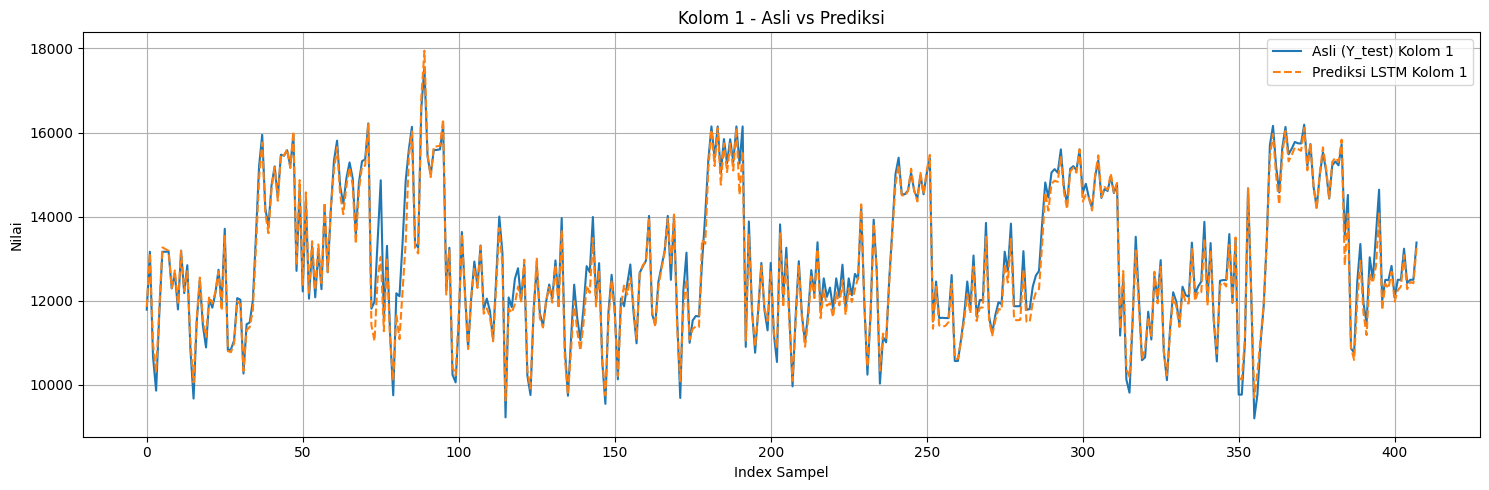

In [90]:
# Definisikan callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',      # Pantau validasi loss
    patience=15,              # Tunggu 5 epoch tanpa perbaikan
    restore_best_weights=True # Kembalikan bobot terbaik saat selesai training
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # Pantau validasi loss
    factor=0.5,              # Kurangi lr jadi setengahnya
    patience=5,              # Tunggu 3 epoch tanpa perbaikan

)

X_train_lstm = X_train.reshape(-1,1,X_train.shape[1])
X_test_lstm = X_test.reshape(-1,1,X_test.shape[1])
X_val_lstm = X_val.reshape(-1,1,X_val.shape[1])

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
mse_list_val, rmse_list_val, mae_list_val, mape_list_val, r2_list_val = [], [], [], [], []

input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])  # (lookback, num_features)
output_size = Y_train.shape[1]  # step

# Train LSTM
lstm_model = train_lstm_keras(X_train_lstm, Y_train, X_val_lstm, Y_val, input_shape, output_size, epochs=100, batch_size=32)
lstm_model_val = train_lstm_keras(X_train_lstm, Y_train, X_test_lstm, Y_test, input_shape, output_size, epochs=100, batch_size=32)
# Prediksi dengan LSTM
lstm_preds = lstm_model.predict(X_test_lstm)  # shape (n_samples, step)
lstm_preds_val = lstm_model_val.predict(X_val_lstm) 
# === Inverse transform sebelum evaluasi ===
scaler_target = scaler_y  # hanya pakai scaler_y dari provinsi pertama di fold ini
Y_test_orig = scaler_target.inverse_transform(Y_test)
lstm_preds_orig = scaler_target.inverse_transform(lstm_preds)
Y_val_orig = scaler_target.inverse_transform(Y_val)
lstm_preds_orig_val = scaler_target.inverse_transform(lstm_preds_val)

# Evaluasi hasil prediksi LSTM
mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, lstm_preds_orig)
r2 = r2_score(Y_test_orig.flatten(), lstm_preds_orig.flatten())

mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

mse_val, rmse_val, mae_val, mape_val = evaluate_forecast(Y_val_orig, lstm_preds_orig_val)
r2_val = r2_score(Y_val_orig.flatten(), lstm_preds_orig_val.flatten())

mse_list_val.append(mse_val)
rmse_list_val.append(rmse_val)
mae_list_val.append(mae_val)
mape_list_val.append(mape_val)
r2_list_val.append(r2_val)

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI TEST ===")
print(f"Avg MSE: {np.mean(mse_list):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list):.4f}")
print(f"Avg MAE: {np.mean(mae_list):.4f}")
print(f"Avg MAPE: {np.mean(mape_list):.2f}%")
print(f"Avg R2: {np.mean(r2_list):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary_test = {
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
}

# Rata-rata hasil evaluasi
print("\n=== RATA-RATA EVALUASI VAL ===")
print(f"Avg MSE: {np.mean(mse_list_val):.4f}")
print(f"Avg RMSE: {np.mean(rmse_list_val):.4f}")
print(f"Avg MAE: {np.mean(mae_list_val):.4f}")
print(f"Avg MAPE: {np.mean(mape_list_val):.2f}%")
print(f"Avg R2: {np.mean(r2_list_val):.4f}")

# Buat dictionary dengan rata-rata metrik evaluasi
eval_summary_val = {
    'Avg MSE': [np.mean(mse_list_val)],
    'Avg RMSE': [np.mean(rmse_list_val)],
    'Avg MAE': [np.mean(mae_list_val)],
    'Avg MAPE (%)': [np.mean(mape_list_val)],
    'Avg R2': [np.mean(r2_list_val)]
}
# Buat DataFrame
df_lstm_test_gwpr = pd.DataFrame(eval_summary_test)
# Buat DataFrame
df_lstm_val_gwpr = pd.DataFrame(eval_summary_val)

Y_test_orig = pd.DataFrame(Y_test_orig)
lstm_preds_orig = pd.DataFrame(lstm_preds_orig)

num_cols = Y_test_orig.shape[1]

plt.figure(figsize=(15, 5 * num_cols))
for i in range(num_cols):
    plt.subplot(num_cols, 1, i + 1)
    plt.plot(Y_test_orig.iloc[:, i], label=f'Asli (Y_test) Kolom {i+1}')
    plt.plot(lstm_preds_orig.iloc[:, i], label=f'Prediksi LSTM Kolom {i+1}', linestyle='--')
    plt.title(f'Kolom {i+1} - Asli vs Prediksi')
    plt.xlabel('Index Sampel')
    plt.ylabel('Nilai')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# EVALUASI MODEL STANDALONE (NON GWPR VS GWPR)

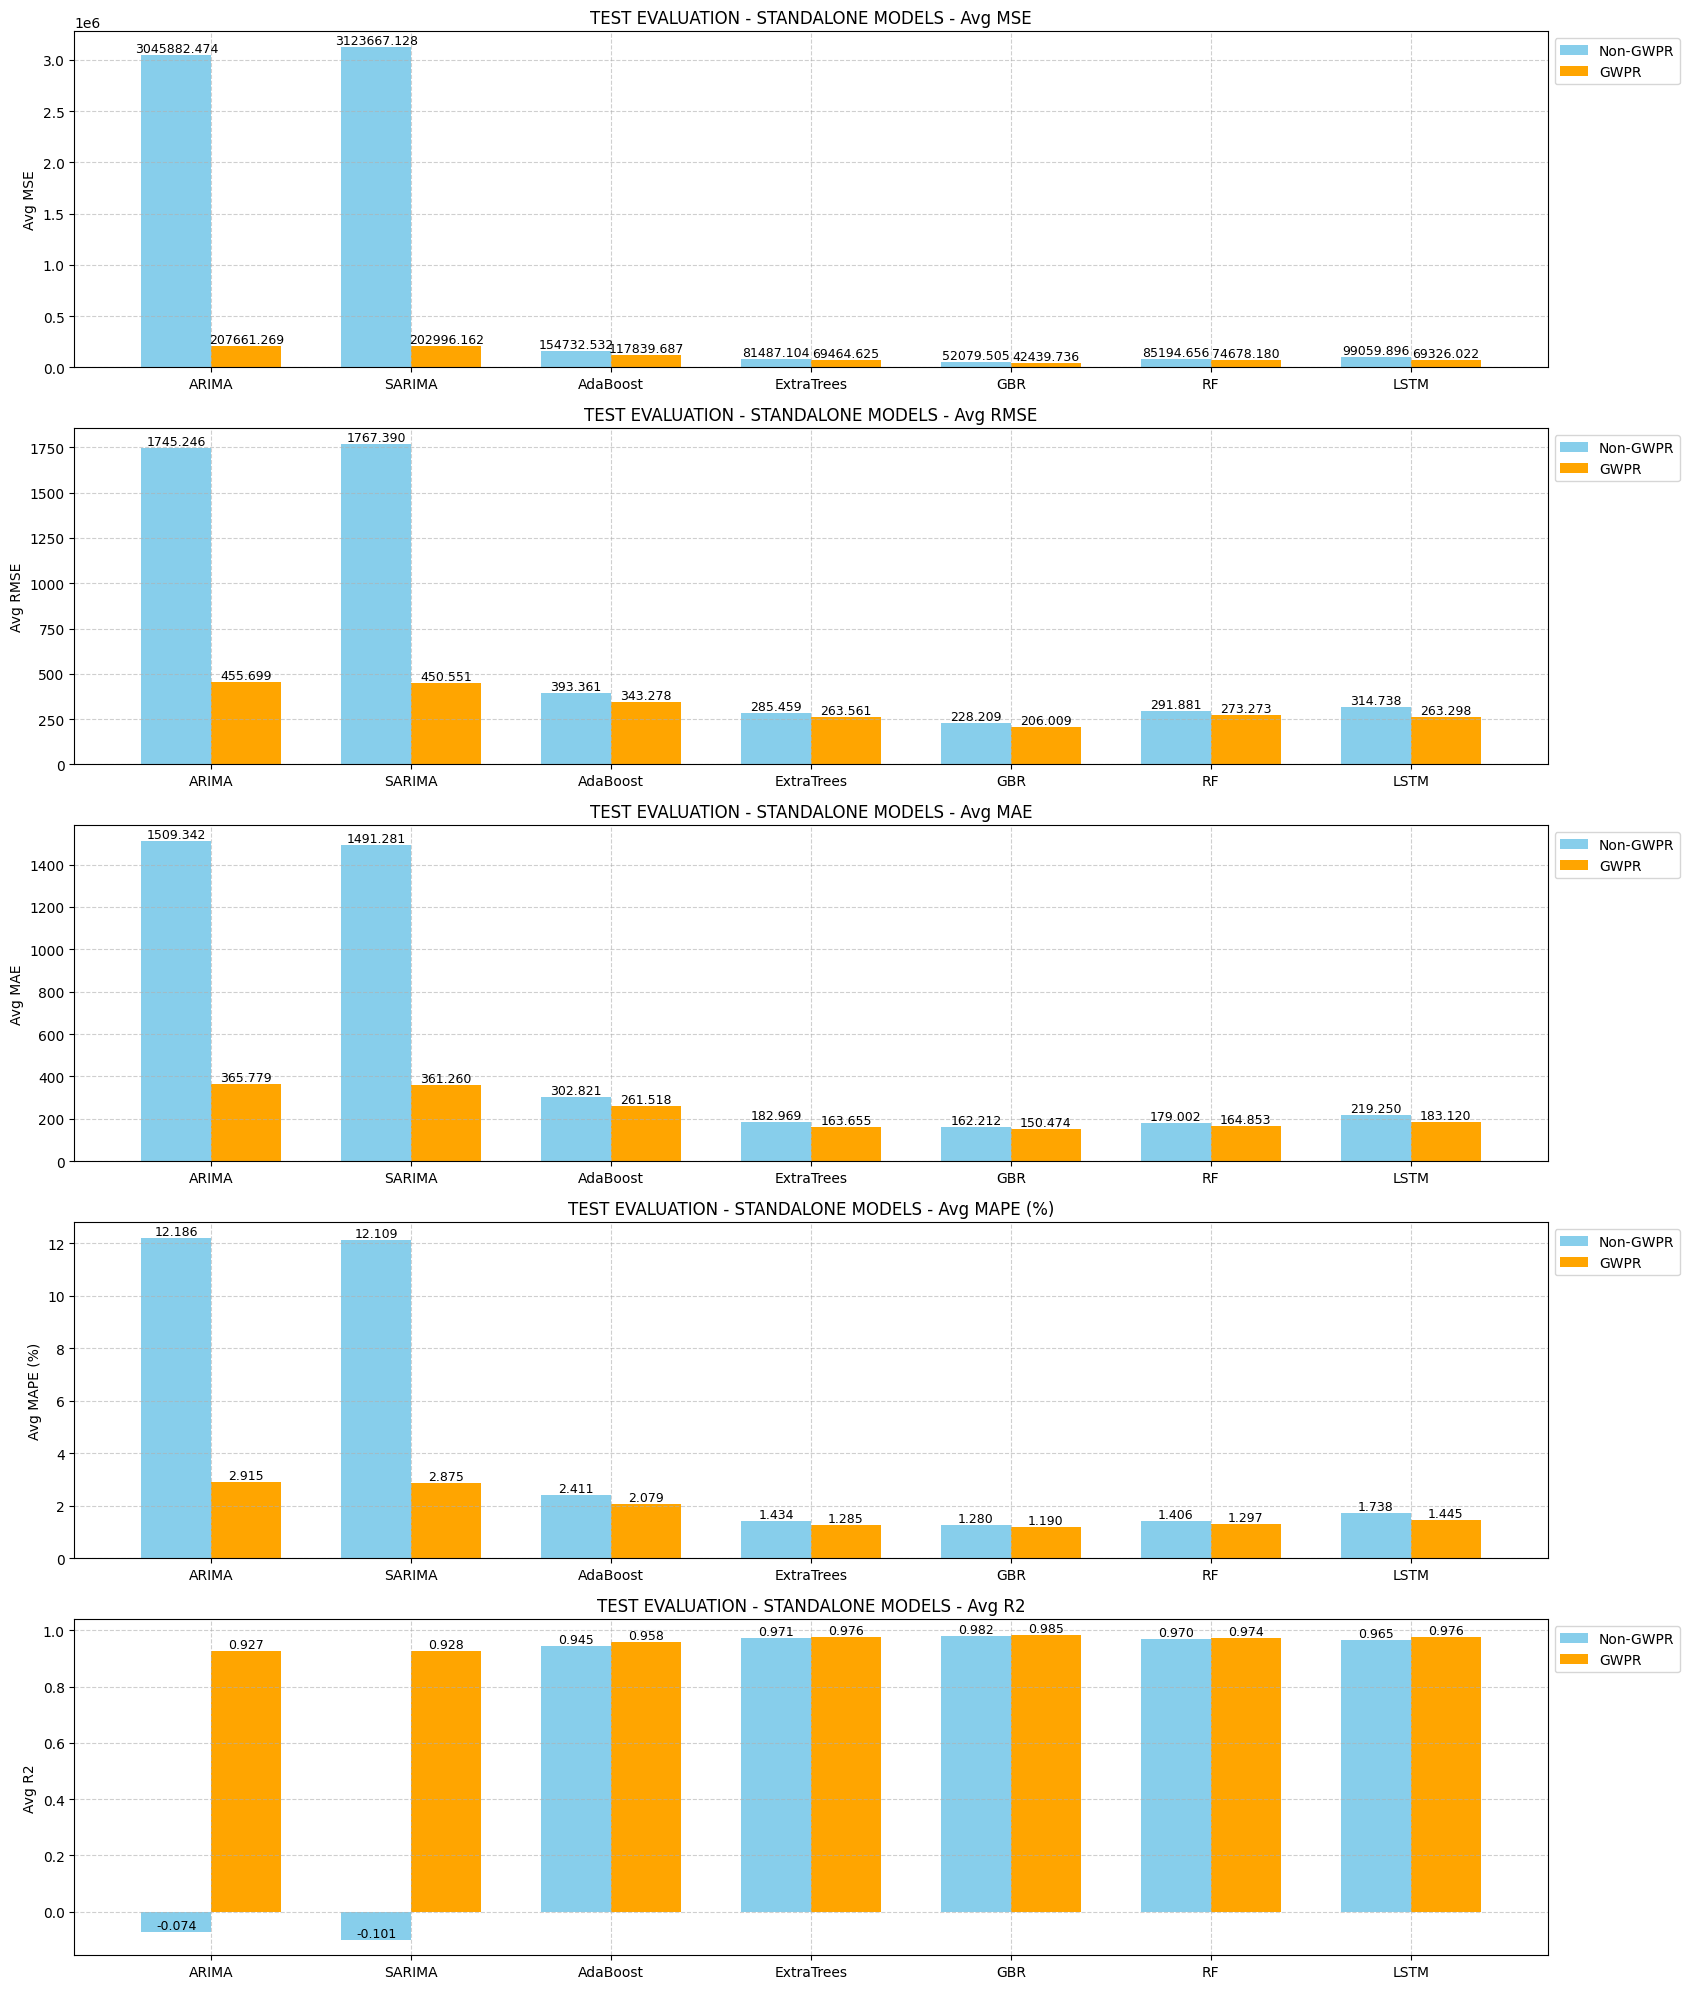

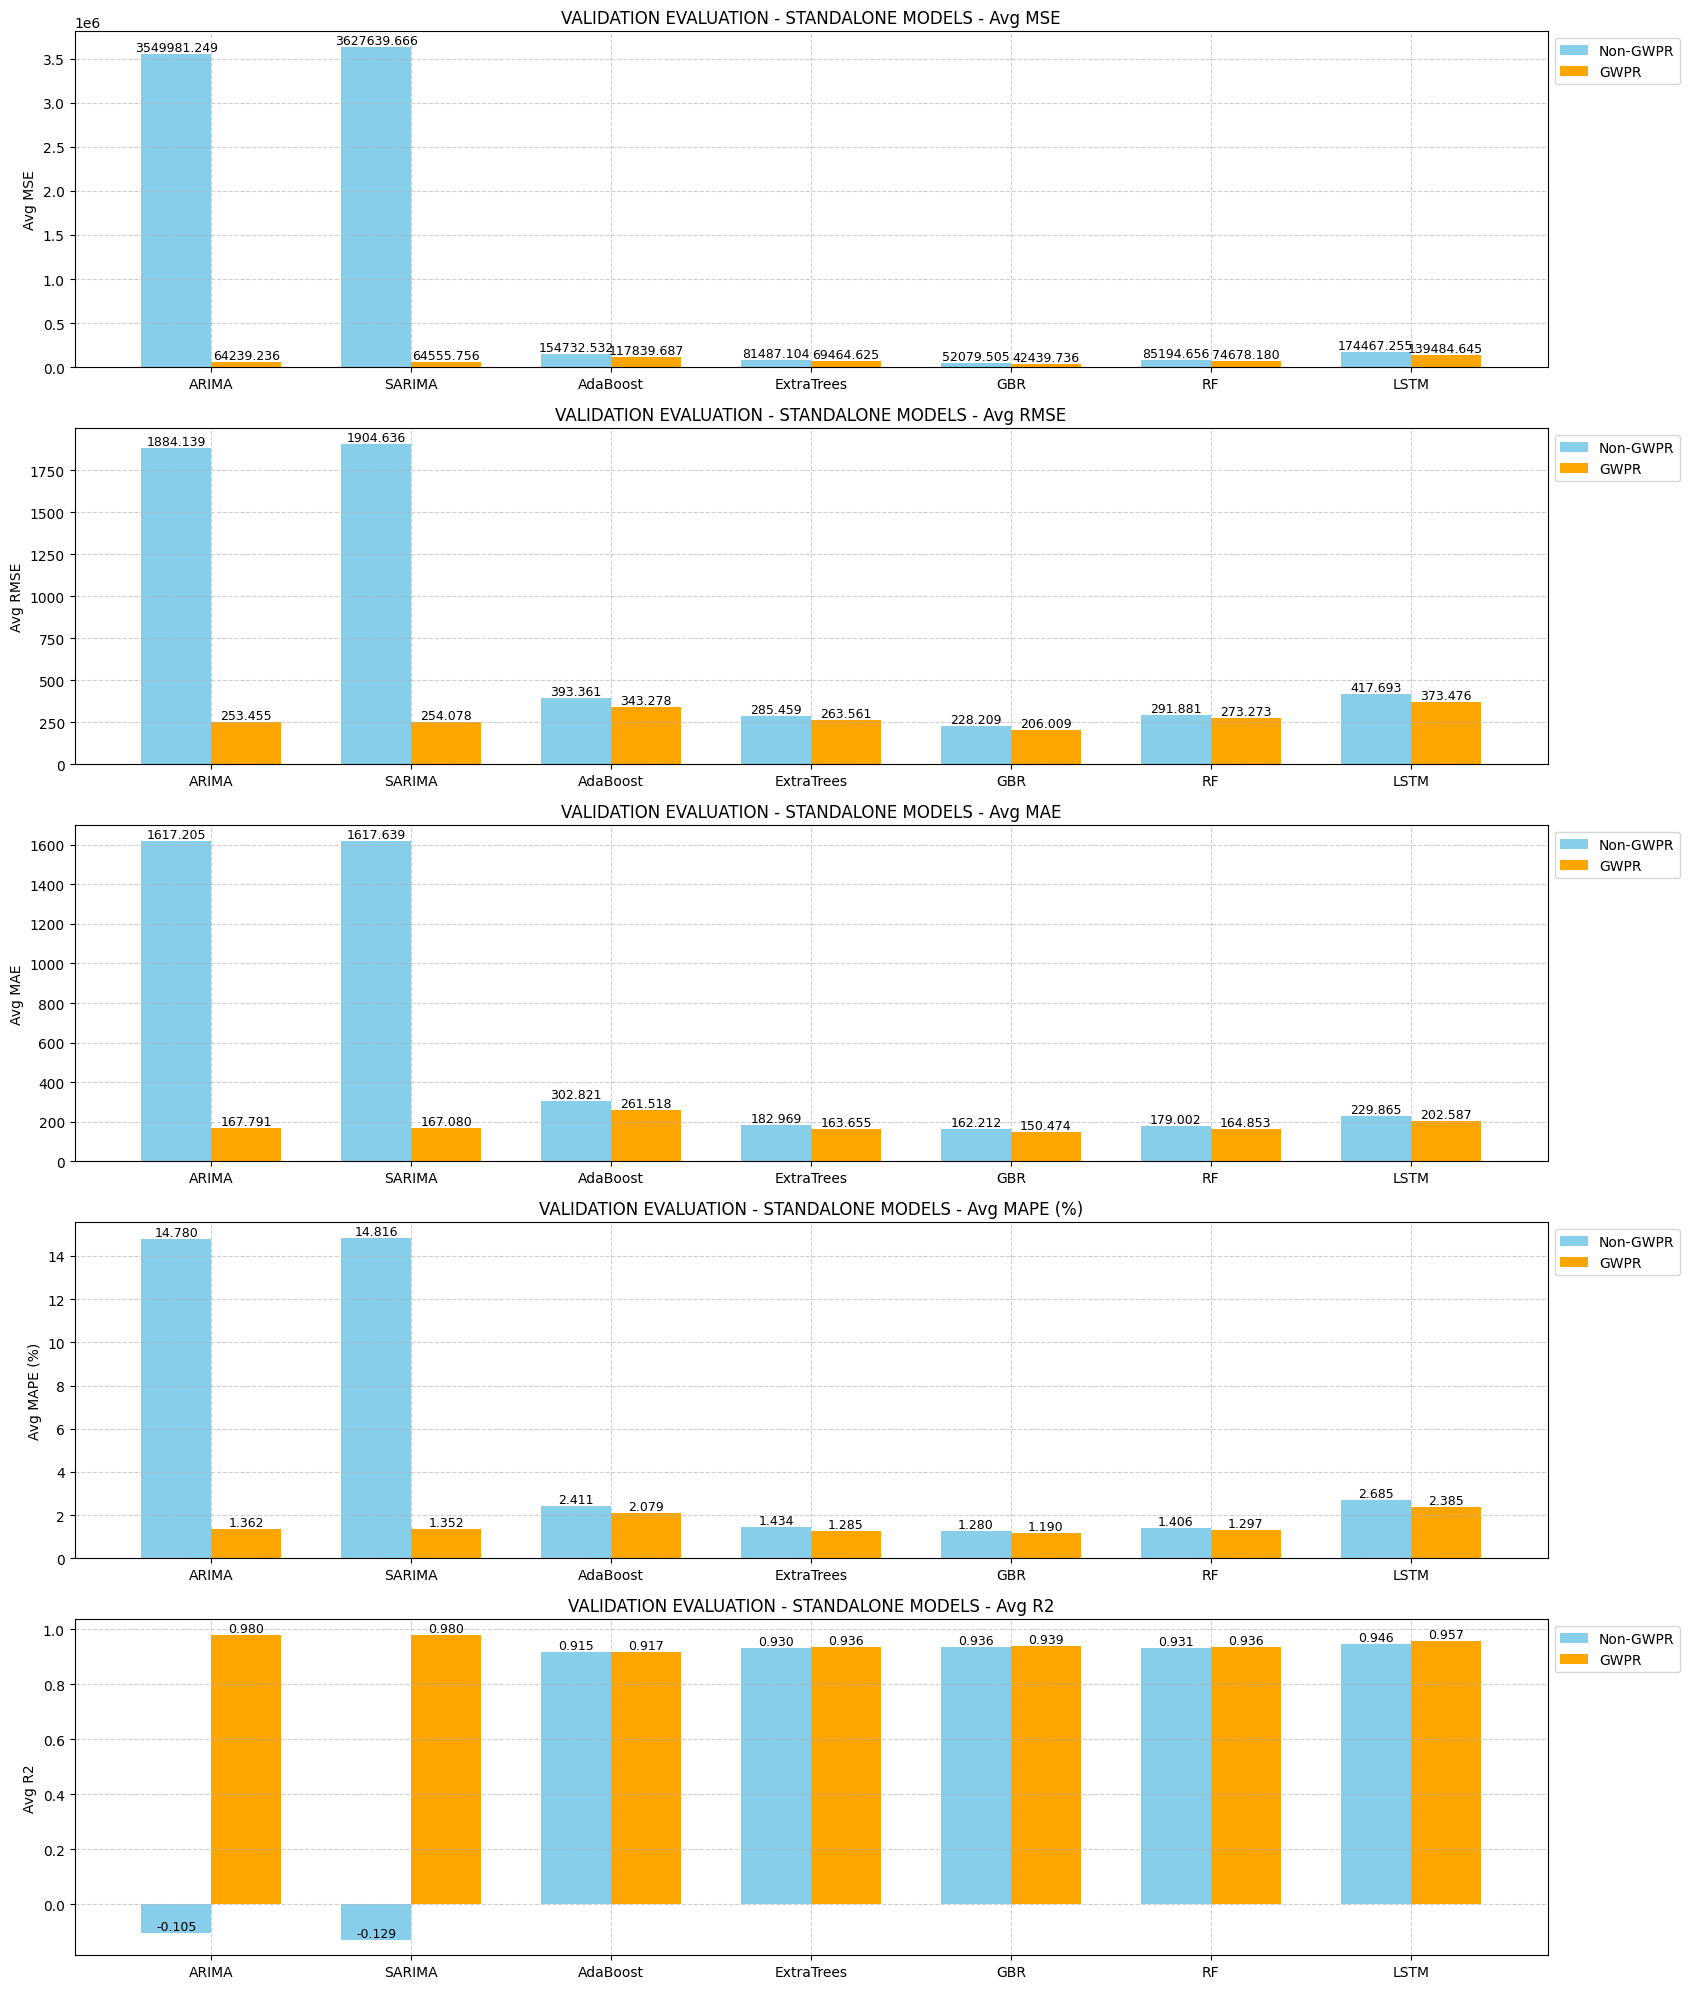

In [91]:
import matplotlib.pyplot as plt
import numpy as np

# Daftar nama model dan dataframe untuk TEST dan VALIDATION
model_names = ['ARIMA', 'SARIMA', 'AdaBoost', 'ExtraTrees', 'GBR', 'RF', 'LSTM']
df_test_non_gwpr = [df_arima_test, df_sarima_test, df_adaboost_test, df_extratrees_test, df_gbr_test, df_rf_test, df_lstm_test]
df_test_gwpr    = [df_arima_test_gwpr, df_sarima_test_gwpr, df_adaboost_test_gwpr, df_extratrees_test_gwpr, df_gbr_test_gwpr, df_rf_test_gwpr, df_lstm_test_gwpr]

df_val_non_gwpr = [df_arima_val, df_sarima_val, df_adaboost_val, df_extratrees_val, df_gbr_val, df_rf_val, df_lstm_val]
df_val_gwpr     = [df_arima_val_gwpr, df_sarima_val_gwpr, df_adaboost_val_gwpr, df_extratrees_val_gwpr, df_gbr_val_gwpr, df_rf_val_gwpr, df_lstm_val_gwpr]

# Pilih metrik yang ingin diplot
metrics = ['Avg MSE', 'Avg RMSE', 'Avg MAE', 'Avg MAPE (%)', 'Avg R2']

def plot_evaluation(non_gwpr_list, gwpr_list, model_names, title):
    x = np.arange(len(model_names))
    width = 0.35

    fig, axs = plt.subplots(len(metrics), 1, figsize=(17, 4 * len(metrics)))

    if len(metrics) == 1:
        axs = [axs]

    for i, metric in enumerate(metrics):
        non_gwpr_values = [df[metric].values[0] for df in non_gwpr_list]
        gwpr_values = [df[metric].values[0] for df in gwpr_list]

        bars1 = axs[i].bar(x - width/2, non_gwpr_values, width, label='Non-GWPR', color='skyblue')
        bars2 = axs[i].bar(x + width/2, gwpr_values, width, label='GWPR', color='orange')

        axs[i].set_ylabel(metric)
        axs[i].set_title(f'{title} - {metric}')
        axs[i].set_xticks(x)
        axs[i].set_xticklabels(model_names)
        axs[i].legend(loc='upper left', bbox_to_anchor=(1,1))
        axs[i].grid(True, linestyle='--', alpha=0.6)

        # Tambahkan label angka di atas batang
        for bar in bars1:
            height = bar.get_height()
            axs[i].text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom', fontsize=9)

        for bar in bars2:
            height = bar.get_height()
            axs[i].text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()
   


# Plot Figure 1: Test Evaluation
plot_evaluation(df_test_non_gwpr, df_test_gwpr, model_names, "TEST EVALUATION - STANDALONE MODELS")

# Plot Figure 2: Validation Evaluation
plot_evaluation(df_val_non_gwpr, df_val_gwpr, model_names, "VALIDATION EVALUATION - STANDALONE MODELS")


# AEM - MODELS - TANPA GWPR

In [92]:
# ========== CELL 2: Split 2 ==========

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Urutkan data
df_fix = df_fix.sort_values(by=['Province', 'Year', 'Month'])

# Split data per provinsi: train (80%), val (10%), test (10%)
train_list, val_list, test_list = [], [], []

for province, group in df_fix.groupby('Province'):
    assert len(group) == 120, f"{province} has {len(group)} rows instead of 120"
    
    train = group.iloc[:96]
    val = group.iloc[96:108]
    test = group.iloc[108:]
    
    train_list.append(train)
    val_list.append(val)
    test_list.append(test)

df_train = pd.concat(train_list)
df_val = pd.concat(val_list)
df_test = pd.concat(test_list)

print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

# Kolom yang dipakai
feature_cols = ['Production', 'Importation', 'Demand', 'Supply', 'Population', 'Religious Holiday']
target_col = 'Price'

# Scaling per provinsi
scaled_train_list, scaled_val_list, scaled_test_list = [], [], []

for province in df_train['Province'].unique():
    train_group = df_train[df_train['Province'] == province].copy()
    val_group = df_val[df_val['Province'] == province].copy()
    test_group = df_test[df_test['Province'] == province].copy()

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaler_X.fit(train_group[feature_cols])
    scaler_y.fit(train_group[[target_col]])

    train_group[feature_cols] = scaler_X.transform(train_group[feature_cols])
    train_group[target_col] = scaler_y.transform(train_group[[target_col]])

    val_group[feature_cols] = scaler_X.transform(val_group[feature_cols])
    val_group[target_col] = scaler_y.transform(val_group[[target_col]])

    test_group[feature_cols] = scaler_X.transform(test_group[feature_cols])
    test_group[target_col] = scaler_y.transform(test_group[[target_col]])

    scaled_train_list.append(train_group)
    scaled_val_list.append(val_group)
    scaled_test_list.append(test_group)

# Gabungkan semua hasil scaling
df_train_scaled = pd.concat(scaled_train_list)
df_val_scaled = pd.concat(scaled_val_list)
df_test_scaled = pd.concat(scaled_test_list)

# Buat X dan y
X_train = df_train_scaled[feature_cols].values
Y_train = df_train_scaled[target_col].values

X_val = df_val_scaled[feature_cols].values
Y_val = df_val_scaled[target_col].values

X_test = df_test_scaled[feature_cols].values
Y_test = df_test_scaled[target_col].values

# Reshape target
Y_train = Y_train.reshape(-1, 1)
Y_val = Y_val.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

print("X_train shape:", X_train.shape)
print("y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", Y_test.shape)


Train shape: (3264, 25)
Validation shape: (408, 25)
Test shape: (408, 25)
X_train shape: (3264, 6)
y_train shape: (3264, 1)
X_val shape: (408, 6)
y_val shape: (408, 1)
X_test shape: (408, 6)
y_test shape: (408, 1)


## ARIMA SARIMA

In [93]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Dummy placeholders (ganti ini dengan data aslimu)
# df_train_scaled, df_val_scaled, df_test_scaled, Y_train, Y_val, Y_test, scaler_y harus disiapkan sebelumnya

# === Ekstraksi variabel eksogen ===
exog_train = df_train_scaled[['Production']].values
exog_val = df_val_scaled[['Production']].values
exog_test = df_test_scaled[['Production']].values

# Ambil jumlah langkah prediksi untuk val dan test
step_val = len(Y_val)
step_test = len(Y_test)


# === Model ARIMA ===
model_arima = sm.tsa.ARIMA(endog=Y_train.flatten(), exog=exog_train, order=(1, 1, 1))
model_arima_fit = model_arima.fit()

# === Model SARIMAX ===
order = (1, 1, 1)
seasonal_order = (1,1,1,12)
model_sarimax = sm.tsa.SARIMAX(endog=Y_train.flatten(),
                               exog=exog_train,
                               order=order,
                               seasonal_order=seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
model_sarimax_fit = model_sarimax.fit(disp=False)

# === Prediksi untuk Validasi ===
arima_pred_val = model_arima_fit.forecast(steps=step_val, exog=exog_val)
sarimax_pred_val = model_sarimax_fit.forecast(steps=step_val, exog=exog_val)
final_pred_val = (arima_pred_val + sarimax_pred_val) / 2

# === Prediksi untuk Test ===
arima_pred_test = model_arima_fit.forecast(steps=step_test, exog=exog_test)
sarimax_pred_test = model_sarimax_fit.forecast(steps=step_test, exog=exog_test)
final_pred_test = (arima_pred_test + sarimax_pred_test) / 2

# === Inverse transform ===
scaler_target = scaler_y
Y_val_orig = scaler_target.inverse_transform(Y_val[:step_val])
Y_test_orig = scaler_target.inverse_transform(Y_test[:step_test])
final_pred_val_orig = scaler_target.inverse_transform(final_pred_val.reshape(-1, 1))
final_pred_test_orig = scaler_target.inverse_transform(final_pred_test.reshape(-1, 1))

# === Evaluasi ===
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    return mse, rmse, mae, mape, r2

# === Simpan dan cetak hasil ===
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []

# Evaluasi Test
mse, rmse, mae, mape, r2 = evaluate_forecast(Y_test_orig, final_pred_test_orig)
mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

# Evaluasi Validation
val_mse, val_rmse, val_mae, val_mape, val_r2 = evaluate_forecast(Y_val_orig, final_pred_val_orig)
val_mse_list.append(val_mse)
val_rmse_list.append(val_rmse)
val_mae_list.append(val_mae)
val_mape_list.append(val_mape)
val_r2_list.append(val_r2)

# Cetak Hasil
print("\n=== EVALUASI TEST ===")
print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

print("\n=== EVALUASI VALIDASI ===")
print(f"MSE: {val_mse:.4f} | RMSE: {val_rmse:.4f} | MAE: {val_mae:.4f} | MAPE: {val_mape:.2f}% | R2: {val_r2:.4f}")

# Buat DataFrame
df_AEM_arima_sarima_test = pd.DataFrame({
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
})

df_AEM_arima_sarima_val = pd.DataFrame({
    'Avg MSE': [np.mean(val_mse_list)],
    'Avg RMSE': [np.mean(val_rmse_list)],
    'Avg MAE': [np.mean(val_mae_list)],
    'Avg MAPE (%)': [np.mean(val_mape_list)],
    'Avg R2': [np.mean(val_r2_list)]
})

print("\n=== RATA-RATA EVALUASI TEST DALAM DATAFRAME ===")
print(df_AEM_arima_sarima_test)

print("\n=== RATA-RATA EVALUASI VALIDASI DALAM DATAFRAME ===")
print(df_AEM_arima_sarima_val)

print("Variance Y_test_orig:", np.var(Y_test_orig))
print("Variance Y_val_orig:", np.var(Y_val_orig))



=== EVALUASI TEST ===
MSE: 3055064.2055 | RMSE: 1747.8742 | MAE: 1496.9345 | MAPE: 12.12% | R2: -0.0770

=== EVALUASI VALIDASI ===
MSE: 3558907.5338 | RMSE: 1886.5067 | MAE: 1615.5467 | MAPE: 14.78% | R2: -0.1078

=== RATA-RATA EVALUASI TEST DALAM DATAFRAME ===
        Avg MSE     Avg RMSE      Avg MAE  Avg MAPE (%)    Avg R2
0  3.055064e+06  1747.874196  1496.934529     12.122416 -0.077033

=== RATA-RATA EVALUASI VALIDASI DALAM DATAFRAME ===
        Avg MSE     Avg RMSE      Avg MAE  Avg MAPE (%)    Avg R2
0  3.558908e+06  1886.506701  1615.546731     14.783977 -0.107799
Variance Y_test_orig: 2836555.9105742844
Variance Y_val_orig: 3212591.8889441164


## LSTM + ARIMA

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.2240 - val_loss: 0.1762 - learning_rate: 1.0000e-04
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1747 - val_loss: 0.1065 - learning_rate: 1.0000e-04
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1025 - val_loss: 0.0586 - learning_rate: 1.0000e-04
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0679 - val_loss: 0.0566 - learning_rate: 1.0000e-04
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0679 - val_loss: 0.0557 - learning_rate: 1.0000e-04
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0698 - val_loss: 0.0548 - learning_rate: 1.0000e-04
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0689 - val_loss: 0.0543 - learning_rate: 1.0000e-04
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0673 - val_loss: 0.0537 - learning_rate: 1.0000e-04
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0641 - val_loss:

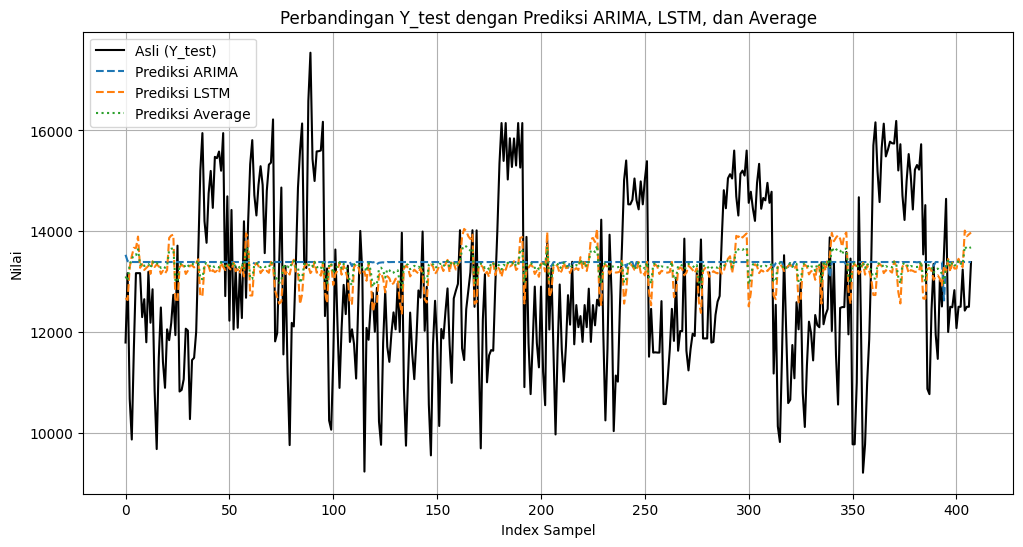

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

exog_train = df_train_scaled[['Production']].values
exog_val = df_val_scaled[['Production']].values
exog_test = df_test_scaled[['Production']].values

val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

# Build model LSTM
def build_lstm_model(input_shape, output_size):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=32))
    model.add(Dropout(0.3))
    model.add(Dense(output_size))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model

# Fungsi train model LSTM menggunakan Keras
def train_lstm_keras(X_train, Y_train, X_val, Y_val, input_shape, output_size, epochs=100, batch_size=32):
    model = build_lstm_model(input_shape, output_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )
    return model, history


# Reshape input untuk LSTM (samples, timesteps=1, features)
X_train_lstm = X_train.reshape(-1, 1, X_train.shape[1])
X_val_lstm = X_val.reshape(-1, 1, X_val.shape[1])
X_test_lstm = X_test.reshape(-1, 1, X_test.shape[1])

input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
output_size = Y_train.shape[1]

# Training LSTM
lstm_model, history = train_lstm_keras(X_train_lstm, Y_train, X_val_lstm, Y_val, input_shape, output_size,
                                       epochs=100, batch_size=32)

# Fit ARIMA model
model_arima = sm.tsa.ARIMA(endog=Y_train.flatten(), exog=exog_train, order=(1,1,1))
model_fit_arima = model_arima.fit()

# =============== Prediksi Validation ===============
step_val = len(Y_val)

val_preds_arima_scaled = model_fit_arima.forecast(steps=step_val, exog=exog_val).reshape(-1,1)
lstm_preds_val = lstm_model.predict(X_val_lstm)
avg_preds_val_scaled = (val_preds_arima_scaled + lstm_preds_val) / 2

Y_val_orig = scaler_y.inverse_transform(Y_val)
val_preds_arima_orig = scaler_y.inverse_transform(val_preds_arima_scaled)
lstm_preds_val_orig = scaler_y.inverse_transform(lstm_preds_val)
avg_preds_val_orig = scaler_y.inverse_transform(avg_preds_val_scaled)

print("\n=== EVALUASI VALIDASI ===")
for name, preds_orig in zip(['ARIMA', 'LSTM', 'AVERAGE'], 
                            [val_preds_arima_orig, lstm_preds_val_orig, avg_preds_val_orig]):
    mse, rmse, mae, mape = evaluate_forecast(Y_val_orig, preds_orig)
    r2 = r2_score(Y_val_orig.flatten(), preds_orig.flatten())
    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

# Simpan metric validasi rata-rata dari average prediction
val_mse, val_rmse, val_mae, val_mape = evaluate_forecast(Y_val_orig, avg_preds_val_orig)
val_r2 = r2_score(Y_val_orig.flatten(), avg_preds_val_orig.flatten())

val_mse_list.append(val_mse)
val_rmse_list.append(val_rmse)
val_mae_list.append(val_mae)
val_mape_list.append(val_mape)
val_r2_list.append(val_r2)

# =============== Prediksi Test ===============
step_test = len(Y_test)

test_preds_arima_scaled = model_fit_arima.forecast(steps=step_test, exog=exog_test).reshape(-1,1)
lstm_preds_test = lstm_model.predict(X_test_lstm)
avg_preds_test_scaled = (test_preds_arima_scaled + lstm_preds_test) / 2

Y_test_orig = scaler_y.inverse_transform(Y_test)
test_preds_arima_orig = scaler_y.inverse_transform(test_preds_arima_scaled)
lstm_preds_test_orig = scaler_y.inverse_transform(lstm_preds_test)
avg_preds_test_orig = scaler_y.inverse_transform(avg_preds_test_scaled)

print("\n=== EVALUASI TEST ===")
for name, preds_orig in zip(['ARIMA', 'LSTM', 'AVERAGE'], 
                            [test_preds_arima_orig, lstm_preds_test_orig, avg_preds_test_orig]):
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), preds_orig.flatten())
    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

# Simpan metric test rata-rata dari average prediction
mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, avg_preds_test_orig)
r2 = r2_score(Y_test_orig.flatten(), avg_preds_test_orig.flatten())

mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

# =============== Buat DataFrame hasil evaluasi ===============
df_AEM_lstm_arima_val = pd.DataFrame({
    'Avg MSE': [np.mean(val_mse_list)],
    'Avg RMSE': [np.mean(val_rmse_list)],
    'Avg MAE': [np.mean(val_mae_list)],
    'Avg MAPE (%)': [np.mean(val_mape_list)],
    'Avg R2': [np.mean(val_r2_list)]
})

df_AEM_lstm_arima_test = pd.DataFrame({
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
})

print("\n=== DataFrame Evaluasi Validasi ===")
print(df_AEM_lstm_arima_val)

print("\n=== DataFrame Evaluasi Test ===")
print(df_AEM_lstm_arima_test)

# =============== Plot hasil prediksi test ===============
plt.figure(figsize=(12,6))
plt.plot(Y_test_orig, label='Asli (Y_test)', color='black')
plt.plot(test_preds_arima_orig, label='Prediksi ARIMA', linestyle='--')
plt.plot(lstm_preds_test_orig, label='Prediksi LSTM', linestyle='--')
plt.plot(avg_preds_test_orig, label='Prediksi Average', linestyle=':')
plt.title('Perbandingan Y_test dengan Prediksi ARIMA, LSTM, dan Average')
plt.xlabel('Index Sampel')
plt.ylabel('Nilai')
plt.legend()
plt.grid(True)
plt.show()


## LSTM + SARIMA

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.2251 - val_loss: 0.1779 - learning_rate: 1.0000e-04
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1797 - val_loss: 0.1081 - learning_rate: 1.0000e-04
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1041 - val_loss: 0.0580 - learning_rate: 1.0000e-04
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0669 - val_loss: 0.0557 - learning_rate: 1.0000e-04
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0709 - val_loss: 0.0549 - learning_rate: 1.0000e-04
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0688 - val_loss: 0.0542 - learning_rate: 1.0000e-04
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0655 - val_loss: 0.0537 - learning_rate: 1.0000e-04
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0671 - val_loss: 0.0534 - learning_rate: 1.0000e-04
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0649 - val_loss

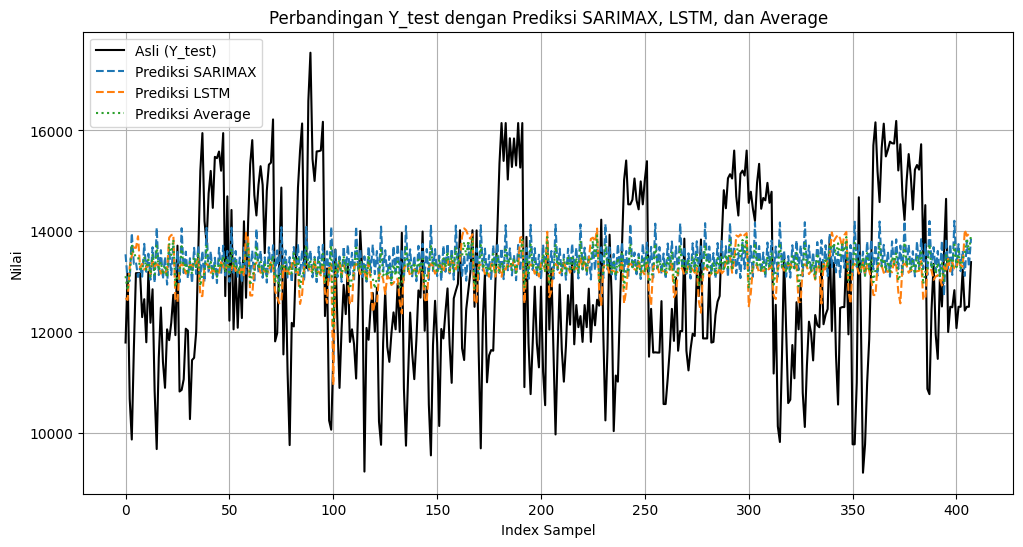

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Asumsi variabel-variabel ini sudah tersedia:
# df_train_scaled, df_val_scaled, df_test_scaled, X_train, Y_train, X_val, Y_val, X_test, Y_test
# scaler_y, dan list kosong untuk metric:
# val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list
# mse_list, rmse_list, mae_list, mape_list, r2_list

exog_train = df_train_scaled[['Production']].values
exog_val = df_val_scaled[['Production']].values
exog_test = df_test_scaled[['Production']].values

val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []


# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

# Build model LSTM
def build_lstm_model(input_shape, output_size):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=32))
    model.add(Dropout(0.3))
    model.add(Dense(output_size))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model

# Fungsi train model LSTM menggunakan Keras
def train_lstm_keras(X_train, Y_train, X_val, Y_val, input_shape, output_size, epochs=100, batch_size=32):
    model = build_lstm_model(input_shape, output_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )
    return model, history

# Reshape input untuk LSTM (samples, timesteps=1, features)
X_train_lstm = X_train.reshape(-1, 1, X_train.shape[1])
X_val_lstm = X_val.reshape(-1, 1, X_val.shape[1])
X_test_lstm = X_test.reshape(-1, 1, X_test.shape[1])

input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
output_size = Y_train.shape[1]

# Training LSTM
lstm_model, history = train_lstm_keras(X_train_lstm, Y_train, X_val_lstm, Y_val, input_shape, output_size,
                                       epochs=100, batch_size=32)

# Definisikan order SARIMA
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# Fit SARIMAX model
model_sarimax = sm.tsa.SARIMAX(endog=Y_train.flatten(),
                               exog=exog_train,
                               order=order,
                               seasonal_order=seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
model_sarimax_fit = model_sarimax.fit(disp=False)

# =============== Prediksi Validation ===============
step_val = len(Y_val)

val_preds_sarimax_scaled = model_sarimax_fit.forecast(steps=step_val, exog=exog_val).reshape(-1,1)
lstm_preds_val = lstm_model.predict(X_val_lstm)
avg_preds_val_scaled = (val_preds_sarimax_scaled + lstm_preds_val) / 2

Y_val_orig = scaler_y.inverse_transform(Y_val)
val_preds_sarimax_orig = scaler_y.inverse_transform(val_preds_sarimax_scaled)
lstm_preds_val_orig = scaler_y.inverse_transform(lstm_preds_val)
avg_preds_val_orig = scaler_y.inverse_transform(avg_preds_val_scaled)

print("\n=== EVALUASI VALIDASI ===")
for name, preds_orig in zip(['SARIMAX', 'LSTM', 'AVERAGE'], 
                            [val_preds_sarimax_orig, lstm_preds_val_orig, avg_preds_val_orig]):
    mse, rmse, mae, mape = evaluate_forecast(Y_val_orig, preds_orig)
    r2 = r2_score(Y_val_orig.flatten(), preds_orig.flatten())
    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

val_mse_list.append(mse)
val_rmse_list.append(rmse)
val_mae_list.append(mae)
val_mape_list.append(mape)
val_r2_list.append(r2)

# =============== Prediksi Test ===============
step_test = len(Y_test)

test_preds_sarimax_scaled = model_sarimax_fit.forecast(steps=step_test, exog=exog_test).reshape(-1,1)
lstm_preds_test = lstm_model.predict(X_test_lstm)
avg_preds_test_scaled = (test_preds_sarimax_scaled + lstm_preds_test) / 2

Y_test_orig = scaler_y.inverse_transform(Y_test)
test_preds_sarimax_orig = scaler_y.inverse_transform(test_preds_sarimax_scaled)
lstm_preds_test_orig = scaler_y.inverse_transform(lstm_preds_test)
avg_preds_test_orig = scaler_y.inverse_transform(avg_preds_test_scaled)

print("\n=== EVALUASI TEST ===")
for name, preds_orig in zip(['SARIMAX', 'LSTM', 'AVERAGE'], 
                            [test_preds_sarimax_orig, lstm_preds_test_orig, avg_preds_test_orig]):
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), preds_orig.flatten())
    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

# =============== Buat DataFrame hasil evaluasi ===============
df_AEM_lstm_sarima_val = pd.DataFrame({
    'Avg MSE': [np.mean(val_mse_list)],
    'Avg RMSE': [np.mean(val_rmse_list)],
    'Avg MAE': [np.mean(val_mae_list)],
    'Avg MAPE (%)': [np.mean(val_mape_list)],
    'Avg R2': [np.mean(val_r2_list)]
})

df_AEM_lstm_sarima_test = pd.DataFrame({
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
})

print("\n=== DataFrame Evaluasi Validasi ===")
print(df_AEM_lstm_sarima_val)

print("\n=== DataFrame Evaluasi Test ===")
print(df_AEM_lstm_sarima_test)

# =============== Plot hasil prediksi test ===============
plt.figure(figsize=(12,6))
plt.plot(Y_test_orig, label='Asli (Y_test)', color='black')
plt.plot(test_preds_sarimax_orig, label='Prediksi SARIMAX', linestyle='--')
plt.plot(lstm_preds_test_orig, label='Prediksi LSTM', linestyle='--')
plt.plot(avg_preds_test_orig, label='Prediksi Average', linestyle=':')
plt.title('Perbandingan Y_test dengan Prediksi SARIMAX, LSTM, dan Average')
plt.xlabel('Index Sampel')
plt.ylabel('Nilai')
plt.legend()
plt.grid(True)
plt.show()


## LSTM + ARIMA + SARIMA

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.2149 - val_loss: 0.1719 - learning_rate: 1.0000e-04
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1743 - val_loss: 0.0980 - learning_rate: 1.0000e-04
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0910 - val_loss: 0.0568 - learning_rate: 1.0000e-04
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0679 - val_loss: 0.0556 - learning_rate: 1.0000e-04
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0669 - val_loss: 0.0548 - learning_rate: 1.0000e-04
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0665 - val_loss: 0.0542 - learning_rate: 1.0000e-04
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0667 - val_loss: 0.0538 - learning_rate: 1.0000e-04
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0677 - val_loss: 0.0535 - learning_rate: 1.0000e-04
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0664 - val_los

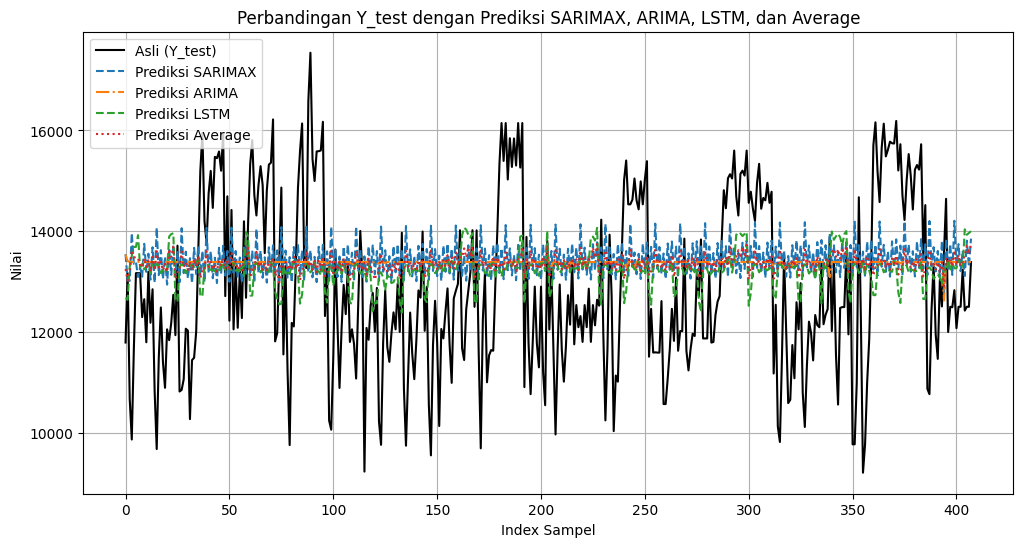

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Asumsi variabel-variabel ini sudah tersedia:
# df_train_scaled, df_val_scaled, df_test_scaled, X_train, Y_train, X_val, Y_val, X_test, Y_test
# scaler_y, dan list kosong untuk metric:
# val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list
# mse_list, rmse_list, mae_list, mape_list, r2_list

exog_train = df_train_scaled[['Production']].values
exog_val = df_val_scaled[['Production']].values
exog_test = df_test_scaled[['Production']].values
val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

# Build model LSTM
def build_lstm_model(input_shape, output_size):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=32))
    model.add(Dropout(0.3))
    model.add(Dense(output_size))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model

# Fungsi train model LSTM menggunakan Keras
def train_lstm_keras(X_train, Y_train, X_val, Y_val, input_shape, output_size, epochs=100, batch_size=32):
    model = build_lstm_model(input_shape, output_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )
    return model, history

# Reshape input untuk LSTM (samples, timesteps=1, features)
X_train_lstm = X_train.reshape(-1, 1, X_train.shape[1])
X_val_lstm = X_val.reshape(-1, 1, X_val.shape[1])
X_test_lstm = X_test.reshape(-1, 1, X_test.shape[1])

input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
output_size = Y_train.shape[1]

# Training LSTM
lstm_model, history = train_lstm_keras(X_train_lstm, Y_train, X_val_lstm, Y_val, input_shape, output_size,
                                       epochs=100, batch_size=32)

# Definisikan order SARIMA
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# Fit SARIMAX model
model_sarimax = sm.tsa.SARIMAX(endog=Y_train.flatten(),
                               exog=exog_train,
                               order=order,
                               seasonal_order=seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
model_sarimax_fit = model_sarimax.fit(disp=False)


# Fit ARIMA model
model_arima = ARIMA(endog=Y_train.flatten(), exog=exog_train, order=order)
model_arima_fit = model_arima.fit()

# =============== Prediksi Validation ===============
step_val = len(Y_val)

val_preds_sarimax_scaled = model_sarimax_fit.forecast(steps=step_val, exog=exog_val).reshape(-1,1)
val_preds_arima_scaled = model_arima_fit.forecast(steps=step_val, exog=exog_val).reshape(-1,1)
lstm_preds_val = lstm_model.predict(X_val_lstm)

# Rata-rata prediksi ketiga model
avg_preds_val_scaled = (val_preds_sarimax_scaled + val_preds_arima_scaled + lstm_preds_val) / 3

Y_val_orig = scaler_y.inverse_transform(Y_val)
val_preds_sarimax_orig = scaler_y.inverse_transform(val_preds_sarimax_scaled)
val_preds_arima_orig = scaler_y.inverse_transform(val_preds_arima_scaled)
lstm_preds_val_orig = scaler_y.inverse_transform(lstm_preds_val)
avg_preds_val_orig = scaler_y.inverse_transform(avg_preds_val_scaled)

print("\n=== EVALUASI VALIDASI ===")
for name, preds_orig in zip(['SARIMAX', 'ARIMA', 'LSTM', 'AVERAGE'], 
                            [val_preds_sarimax_orig, val_preds_arima_orig, lstm_preds_val_orig, avg_preds_val_orig]):
    mse, rmse, mae, mape = evaluate_forecast(Y_val_orig, preds_orig)
    r2 = r2_score(Y_val_orig.flatten(), preds_orig.flatten())
    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

val_mse_list.append(mse)
val_rmse_list.append(rmse)
val_mae_list.append(mae)
val_mape_list.append(mape)
val_r2_list.append(r2)

# =============== Prediksi Test ===============
step_test = len(Y_test)

test_preds_sarimax_scaled = model_sarimax_fit.forecast(steps=step_test, exog=exog_test).reshape(-1,1)
test_preds_arima_scaled = model_arima_fit.forecast(steps=step_test,exog=exog_test).reshape(-1,1)
lstm_preds_test = lstm_model.predict(X_test_lstm)

avg_preds_test_scaled = (test_preds_sarimax_scaled + test_preds_arima_scaled + lstm_preds_test) / 3

Y_test_orig = scaler_y.inverse_transform(Y_test)
test_preds_sarimax_orig = scaler_y.inverse_transform(test_preds_sarimax_scaled)
test_preds_arima_orig = scaler_y.inverse_transform(test_preds_arima_scaled)
lstm_preds_test_orig = scaler_y.inverse_transform(lstm_preds_test)
avg_preds_test_orig = scaler_y.inverse_transform(avg_preds_test_scaled)

print("\n=== EVALUASI TEST ===")
for name, preds_orig in zip(['SARIMAX', 'ARIMA', 'LSTM', 'AVERAGE'], 
                            [test_preds_sarimax_orig, test_preds_arima_orig, lstm_preds_test_orig, avg_preds_test_orig]):
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), preds_orig.flatten())
    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

# =============== Buat DataFrame hasil evaluasi ===============
df_AEM_lstm_arima_sarima_val = pd.DataFrame({
    'Avg MSE': [np.mean(val_mse_list)],
    'Avg RMSE': [np.mean(val_rmse_list)],
    'Avg MAE': [np.mean(val_mae_list)],
    'Avg MAPE (%)': [np.mean(val_mape_list)],
    'Avg R2': [np.mean(val_r2_list)]
})

df_AEM_lstm_arima_sarima_test = pd.DataFrame({
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
})

print("\n=== DataFrame Evaluasi Validasi ===")
print(df_AEM_lstm_arima_sarima_val)

print("\n=== DataFrame Evaluasi Test ===")
print(df_AEM_lstm_arima_sarima_test)

# =============== Plot hasil prediksi test ===============
plt.figure(figsize=(12,6))
plt.plot(Y_test_orig, label='Asli (Y_test)', color='black')
plt.plot(test_preds_sarimax_orig, label='Prediksi SARIMAX', linestyle='--')
plt.plot(test_preds_arima_orig, label='Prediksi ARIMA', linestyle='-.')
plt.plot(lstm_preds_test_orig, label='Prediksi LSTM', linestyle='--')
plt.plot(avg_preds_test_orig, label='Prediksi Average', linestyle=':')
plt.title('Perbandingan Y_test dengan Prediksi SARIMAX, ARIMA, LSTM, dan Average')
plt.xlabel('Index Sampel')
plt.ylabel('Nilai')
plt.legend()
plt.grid(True)
plt.show()


# MLP - MODELS - TANPA GWPR

## ARIMA SARIMA (MLP)

In [98]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam


# Dummy placeholders (ganti dengan datamu)
# df_train_scaled, df_val_scaled, df_test_scaled, Y_train, Y_val, Y_test, scaler_y harus sudah tersedia

# === Ekstraksi variabel eksogen ===
exog_train = df_train_scaled[['Production']].values
exog_val = df_val_scaled[['Production']].values
exog_test = df_test_scaled[['Production']].values

step_val = len(Y_val)
step_test = len(Y_test)

# === Model ARIMA ===
model_arima = sm.tsa.ARIMA(endog=Y_train.flatten(), exog=exog_train, order=(1, 1, 1))
model_arima_fit = model_arima.fit()

# === Model SARIMAX ===
model_sarimax = sm.tsa.SARIMAX(endog=Y_train.flatten(),
                               exog=exog_train,
                               order=(1, 1, 1),
                               seasonal_order=(1,1,1,12),
                               enforce_stationarity=False,
                               enforce_invertibility=False)
model_sarimax_fit = model_sarimax.fit(disp=False)

# === Prediksi untuk Validasi ===
arima_pred_val = model_arima_fit.forecast(steps=step_val, exog=exog_val)
sarimax_pred_val = model_sarimax_fit.forecast(steps=step_val, exog=exog_val)

# === Prediksi untuk Test ===
arima_pred_test = model_arima_fit.forecast(steps=step_test, exog=exog_test)
sarimax_pred_test = model_sarimax_fit.forecast(steps=step_test, exog=exog_test)

# === Gabungkan prediksi untuk Meta-Learner ===
X_meta_val = np.column_stack([arima_pred_val, sarimax_pred_val])
X_meta_test = np.column_stack([arima_pred_test, sarimax_pred_test])

# Target aslinya
y_meta_val = Y_val.reshape(-1,1)
y_meta_test = Y_test.reshape(-1,1)

# === MLP Meta-Learner ===
def train_mlp_meta_learner(X_meta_train, y_meta_train, X_meta_test, epochs=50, batch_size=32):
    input_dim = X_meta_train.shape[1]

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(y_meta_train.shape[1])  # output shape sesuai target dimensi (steps)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    model.fit(X_meta_train, y_meta_train, epochs=epochs, batch_size=batch_size, verbose=0)
    preds = model.predict(X_meta_test)
    return model, preds

mlp_test, pred_test = train_mlp_meta_learner(X_meta_val, y_meta_val, X_meta_test)
mlp_val, pred_val = train_mlp_meta_learner(X_meta_test, y_meta_test, X_meta_val)

# Inverse transform hasil prediksi dan target
Y_val_orig = scaler_y.inverse_transform(Y_val.reshape(-1, 1))
Y_test_orig = scaler_y.inverse_transform(Y_test.reshape(-1, 1))
meta_pred_val_orig = scaler_y.inverse_transform(pred_val.reshape(-1, 1))
meta_pred_test_orig = scaler_y.inverse_transform(pred_test.reshape(-1, 1))

# === Evaluasi ===
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    return mse, rmse, mae, mape, r2

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []

# Evaluasi Test
mse, rmse, mae, mape, r2 = evaluate_forecast(Y_test_orig, meta_pred_test_orig)
mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

# Evaluasi Validation
val_mse, val_rmse, val_mae, val_mape, val_r2 = evaluate_forecast(Y_val_orig, meta_pred_val_orig)
val_mse_list.append(val_mse)
val_rmse_list.append(val_rmse)
val_mae_list.append(val_mae)
val_mape_list.append(val_mape)
val_r2_list.append(val_r2)

# === Output Hasil Evaluasi ===
print("\n=== EVALUASI TEST ===")
print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

print("\n=== EVALUASI VALIDASI ===")
print(f"MSE: {val_mse:.4f} | RMSE: {val_rmse:.4f} | MAE: {val_mae:.4f} | MAPE: {val_mape:.2f}% | R2: {val_r2:.4f}")

# DataFrame hasil
df_MLP_arima_sarima_test = pd.DataFrame({
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
})

df_MLP_arima_sarima_val = pd.DataFrame({
    'Avg MSE': [np.mean(val_mse_list)],
    'Avg RMSE': [np.mean(val_rmse_list)],
    'Avg MAE': [np.mean(val_mae_list)],
    'Avg MAPE (%)': [np.mean(val_mape_list)],
    'Avg R2': [np.mean(val_r2_list)]
})

print("\n=== RATA-RATA EVALUASI TEST (MLP) ===")
print(df_MLP_arima_sarima_test)

print("\n=== RATA-RATA EVALUASI VALIDASI (MLP) ===")
print(df_MLP_arima_sarima_val)

# Variansi untuk tambahan info
print("Variance Y_test_orig:", np.var(Y_test_orig))
print("Variance Y_val_orig:", np.var(Y_val_orig))



13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

=== EVALUASI TEST ===
MSE: 2852285.8926 | RMSE: 1688.8712 | MAE: 1393.3638 | MAPE: 10.81% | R2: -0.0055

=== EVALUASI VALIDASI ===
MSE: 3218974.5585 | RMSE: 1794.1501 | MAE: 1483.8323 | MAPE: 13.32% | R2: -0.0020

=== RATA-RATA EVALUASI TEST (MLP) ===
        Avg MSE     Avg RMSE      Avg MAE  Avg MAPE (%)    Avg R2
0  2.852286e+06  1688.871189  1393.363842     10.808329 -0.005545

=== RATA-RATA EVALUASI VALIDASI (MLP) ===
        Avg MSE     Avg RMSE     Avg MAE  Avg MAPE (%)    Avg R2
0  3.218975e+06  1794.150094  1483.83225     13.316923 -0.001987
Variance Y_test_orig: 2836555.9105742844
Variance Y_val_orig: 3212591.8889441164


## LSTM + ARIMA (MLP)

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

exog_train = df_train_scaled[['Production']].values
exog_val = df_val_scaled[['Production']].values
exog_test = df_test_scaled[['Production']].values

val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

# Build model LSTM
def build_lstm_model(input_shape, output_size):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=32))
    model.add(Dropout(0.3))
    model.add(Dense(output_size))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model

# Fungsi train model LSTM menggunakan Keras
def train_lstm_keras(X_train, Y_train, X_val, Y_val, input_shape, output_size, epochs=100, batch_size=32):
    model = build_lstm_model(input_shape, output_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )
    return model, history


# Reshape input untuk LSTM (samples, timesteps=1, features)
X_train_lstm = X_train.reshape(-1, 1, X_train.shape[1])
X_val_lstm = X_val.reshape(-1, 1, X_val.shape[1])
X_test_lstm = X_test.reshape(-1, 1, X_test.shape[1])

input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
output_size = Y_train.shape[1]



# Fit ARIMA model
model_arima = sm.tsa.ARIMA(endog=Y_train.flatten(), exog=exog_train, order=(1,1,1))
model_fit_arima = model_arima.fit()

# =============== Prediksi Testing ===============
# Training LSTM
lstm_model, history = train_lstm_keras(X_train_lstm, Y_train, X_val_lstm, Y_val, input_shape, output_size,
                                       epochs=100, batch_size=32)

step_test = len(Y_test)
arima_pred_test = model_fit_arima.forecast(steps=step_test, exog=exog_test).reshape(-1,1)
lstm_pred_test = lstm_model.predict(X_test_lstm)

# =============== Prediksi Validation ===============
lstm_model, history = train_lstm_keras(X_train_lstm, Y_train, X_test_lstm, Y_test, input_shape, output_size,
                                       epochs=100, batch_size=32)
step_val = len(Y_val)
arima_pred_val = model_fit_arima.forecast(steps=step_val, exog=exog_val).reshape(-1,1)
lstm_pred_val = lstm_model.predict(X_val_lstm)


# === Gabungkan prediksi untuk Meta-Learner ===
X_meta_val = np.column_stack([arima_pred_val, lstm_pred_val])
X_meta_test = np.column_stack([arima_pred_test, lstm_pred_test])

# Target aslinya
y_meta_val = Y_val.reshape(-1,1)
y_meta_test = Y_test.reshape(-1,1)

# === MLP Meta-Learner ===
def train_mlp_meta_learner(X_meta_train, y_meta_train, X_meta_test, epochs=50, batch_size=32):
    input_dim = X_meta_train.shape[1]

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(y_meta_train.shape[1])  # output shape sesuai target dimensi (steps)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    model.fit(X_meta_train, y_meta_train, epochs=epochs, batch_size=batch_size, verbose=0)
    preds = model.predict(X_meta_test)
    return model, preds

mlp_test, pred_test = train_mlp_meta_learner(X_meta_val, y_meta_val, X_meta_test)
mlp_val, pred_val = train_mlp_meta_learner(X_meta_test, y_meta_test, X_meta_val)

# Inverse transform hasil prediksi dan target
Y_val_orig = scaler_y.inverse_transform(Y_val.reshape(-1, 1))
Y_test_orig = scaler_y.inverse_transform(Y_test.reshape(-1, 1))
meta_pred_val_orig = scaler_y.inverse_transform(pred_val.reshape(-1, 1))
meta_pred_test_orig = scaler_y.inverse_transform(pred_test.reshape(-1, 1))

# === Evaluasi ===
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    return mse, rmse, mae, mape, r2

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []

# Evaluasi Test
mse, rmse, mae, mape, r2 = evaluate_forecast(Y_test_orig, meta_pred_test_orig)
mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

# Evaluasi Validation
val_mse, val_rmse, val_mae, val_mape, val_r2 = evaluate_forecast(Y_val_orig, meta_pred_val_orig)
val_mse_list.append(val_mse)
val_rmse_list.append(val_rmse)
val_mae_list.append(val_mae)
val_mape_list.append(val_mape)
val_r2_list.append(val_r2)

# === Output Hasil Evaluasi ===
print("\n=== EVALUASI TEST ===")
print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

print("\n=== EVALUASI VALIDASI ===")
print(f"MSE: {val_mse:.4f} | RMSE: {val_rmse:.4f} | MAE: {val_mae:.4f} | MAPE: {val_mape:.2f}% | R2: {val_r2:.4f}")

# DataFrame hasil
df_MLP_lstm_arima_test = pd.DataFrame({
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
})

df_MLP_lstm_arima_val = pd.DataFrame({
    'Avg MSE': [np.mean(val_mse_list)],
    'Avg RMSE': [np.mean(val_rmse_list)],
    'Avg MAE': [np.mean(val_mae_list)],
    'Avg MAPE (%)': [np.mean(val_mape_list)],
    'Avg R2': [np.mean(val_r2_list)]
})

print("\n=== RATA-RATA EVALUASI TEST (MLP) ===")
print(df_MLP_lstm_arima_test)

print("\n=== RATA-RATA EVALUASI VALIDASI (MLP) ===")
print(df_MLP_lstm_arima_val)

# Variansi untuk tambahan info
print("Variance Y_test_orig:", np.var(Y_test_orig))
print("Variance Y_val_orig:", np.var(Y_val_orig))




Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 0.2210 - val_loss: 0.1768 - learning_rate: 1.0000e-04
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1840 - val_loss: 0.1086 - learning_rate: 1.0000e-04
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1000 - val_loss: 0.0590 - learning_rate: 1.0000e-04
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0692 - val_loss: 0.0566 - learning_rate: 1.0000e-04
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0718 - val_loss: 0.0558 - learning_rate: 1.0000e-04
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0685 - val_loss: 0.0548 - learning_rate: 1.0000e-04
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0667 - val_loss: 0.0543 - learning_rate: 1.0000e-04
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0653 - val_loss: 0.0538 - learning_rate: 1.0000e-04
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0690 - val_loss:

## LSTM + SARIMA (MLP)

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

exog_train = df_train_scaled[['Production']].values
exog_val = df_val_scaled[['Production']].values
exog_test = df_test_scaled[['Production']].values

val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

# Build model LSTM
def build_lstm_model(input_shape, output_size):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=32))
    model.add(Dropout(0.3))
    model.add(Dense(output_size))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model

# Fungsi train model LSTM menggunakan Keras
def train_lstm_keras(X_train, Y_train, X_val, Y_val, input_shape, output_size, epochs=100, batch_size=32):
    model = build_lstm_model(input_shape, output_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )
    return model, history


# Reshape input untuk LSTM (samples, timesteps=1, features)
X_train_lstm = X_train.reshape(-1, 1, X_train.shape[1])
X_val_lstm = X_val.reshape(-1, 1, X_val.shape[1])
X_test_lstm = X_test.reshape(-1, 1, X_test.shape[1])

input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
output_size = Y_train.shape[1]

# Fit ARIMA model
seasonal_order = (1,1,1,12)
model_sarima = sm.tsa.SARIMAX(endog=Y_train.flatten(),
                               exog=exog_train,
                               order=order,
                               seasonal_order=seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
model_sarima_fit = model_sarima.fit(disp=False)
# =============== Prediksi Testing ===============
# Training LSTM
lstm_model, history = train_lstm_keras(X_train_lstm, Y_train, X_val_lstm, Y_val, input_shape, output_size,
                                       epochs=100, batch_size=32)

step_test = len(Y_test)
sarima_pred_test = model_sarima_fit.forecast(steps=step_test, exog=exog_test).reshape(-1,1)
lstm_pred_test = lstm_model.predict(X_test_lstm)

# =============== Prediksi Validation ===============
lstm_model, history = train_lstm_keras(X_train_lstm, Y_train, X_test_lstm, Y_test, input_shape, output_size,
                                       epochs=100, batch_size=32)
step_val = len(Y_val)
sarima_pred_val = model_sarima_fit.forecast(steps=step_val, exog=exog_val).reshape(-1,1)
lstm_pred_val = lstm_model.predict(X_val_lstm)


# === Gabungkan prediksi untuk Meta-Learner ===
X_meta_val = np.column_stack([sarima_pred_val, lstm_pred_val])
X_meta_test = np.column_stack([sarima_pred_test, lstm_pred_test])

# Target aslinya
y_meta_val = Y_val.reshape(-1,1)
y_meta_test = Y_test.reshape(-1,1)

# === MLP Meta-Learner ===
def train_mlp_meta_learner(X_meta_train, y_meta_train, X_meta_test, epochs=50, batch_size=32):
    input_dim = X_meta_train.shape[1]

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(y_meta_train.shape[1])  # output shape sesuai target dimensi (steps)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    model.fit(X_meta_train, y_meta_train, epochs=epochs, batch_size=batch_size, verbose=0)
    preds = model.predict(X_meta_test)
    return model, preds

mlp_test, pred_test = train_mlp_meta_learner(X_meta_val, y_meta_val, X_meta_test)
mlp_val, pred_val = train_mlp_meta_learner(X_meta_test, y_meta_test, X_meta_val)

# Inverse transform hasil prediksi dan target
Y_val_orig = scaler_y.inverse_transform(Y_val.reshape(-1, 1))
Y_test_orig = scaler_y.inverse_transform(Y_test.reshape(-1, 1))
meta_pred_val_orig = scaler_y.inverse_transform(pred_val.reshape(-1, 1))
meta_pred_test_orig = scaler_y.inverse_transform(pred_test.reshape(-1, 1))

# === Evaluasi ===
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    return mse, rmse, mae, mape, r2

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []

# Evaluasi Test
mse, rmse, mae, mape, r2 = evaluate_forecast(Y_test_orig, meta_pred_test_orig)
mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

# Evaluasi Validation
val_mse, val_rmse, val_mae, val_mape, val_r2 = evaluate_forecast(Y_val_orig, meta_pred_val_orig)
val_mse_list.append(val_mse)
val_rmse_list.append(val_rmse)
val_mae_list.append(val_mae)
val_mape_list.append(val_mape)
val_r2_list.append(val_r2)

# === Output Hasil Evaluasi ===
print("\n=== EVALUASI TEST ===")
print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

print("\n=== EVALUASI VALIDASI ===")
print(f"MSE: {val_mse:.4f} | RMSE: {val_rmse:.4f} | MAE: {val_mae:.4f} | MAPE: {val_mape:.2f}% | R2: {val_r2:.4f}")

# DataFrame hasil
df_MLP_lstm_sarima_test = pd.DataFrame({
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
})

df_MLP_lstm_sarima_val = pd.DataFrame({
    'Avg MSE': [np.mean(val_mse_list)],
    'Avg RMSE': [np.mean(val_rmse_list)],
    'Avg MAE': [np.mean(val_mae_list)],
    'Avg MAPE (%)': [np.mean(val_mape_list)],
    'Avg R2': [np.mean(val_r2_list)]
})

print("\n=== RATA-RATA EVALUASI TEST (MLP) ===")
print(df_MLP_lstm_sarima_test)

print("\n=== RATA-RATA EVALUASI VALIDASI (MLP) ===")
print(df_MLP_lstm_sarima_val)

# Variansi untuk tambahan info
print("Variance Y_test_orig:", np.var(Y_test_orig))
print("Variance Y_val_orig:", np.var(Y_val_orig))




Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.2181 - val_loss: 0.1704 - learning_rate: 1.0000e-04
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1629 - val_loss: 0.0802 - learning_rate: 1.0000e-04
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0667 - val_loss: 0.0309 - learning_rate: 1.0000e-04
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0371 - val_loss: 0.0251 - learning_rate: 1.0000e-04
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0320 - val_loss: 0.0198 - learning_rate: 1.0000e-04
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0260 - val_loss: 0.0143 - learning_rate: 1.0000e-04
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0196 - val_loss: 0.0098 - learning_rate: 1.0000e-04
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0147 - val_loss: 0.0065 - learning_rate: 1.0000e-04
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0113 - val_loss:

## LSTM + ARIMA + SARIMA (MLP)

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

exog_train = df_train_scaled[['Production']].values
exog_val = df_val_scaled[['Production']].values
exog_test = df_test_scaled[['Production']].values

val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

# Build model LSTM
def build_lstm_model(input_shape, output_size):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=32))
    model.add(Dropout(0.3))
    model.add(Dense(output_size))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model

# Fungsi train model LSTM menggunakan Keras
def train_lstm_keras(X_train, Y_train, X_val, Y_val, input_shape, output_size, epochs=100, batch_size=32):
    model = build_lstm_model(input_shape, output_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )
    return model, history


# Reshape input untuk LSTM (samples, timesteps=1, features)
X_train_lstm = X_train.reshape(-1, 1, X_train.shape[1])
X_val_lstm = X_val.reshape(-1, 1, X_val.shape[1])
X_test_lstm = X_test.reshape(-1, 1, X_test.shape[1])

input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
output_size = Y_train.shape[1]

# Fit ARIMA model
model_arima = sm.tsa.ARIMA(endog=Y_train.flatten(), exog=exog_train, order=(1, 1, 1))
model_arima_fit = model_arima.fit()

#FIT SARIMA model
seasonal_order = (1,1,1,12)
model_sarima = sm.tsa.SARIMAX(endog=Y_train.flatten(),
                               exog=exog_train,
                               order=order,
                               seasonal_order=seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
model_sarima_fit = model_sarima.fit(disp=False)
# =============== Prediksi Testing ===============
# Training LSTM
lstm_model, history = train_lstm_keras(X_train_lstm, Y_train, X_val_lstm, Y_val, input_shape, output_size,
                                       epochs=100, batch_size=32)

step_test = len(Y_test)
arima_pred_test = model_arima_fit.forecast(steps=step_test, exog=exog_test).reshape(-1,1)
sarima_pred_test = model_sarima_fit.forecast(steps=step_test, exog=exog_test).reshape(-1,1)
lstm_pred_test = lstm_model.predict(X_test_lstm)

# =============== Prediksi Validation ===============
lstm_model, history = train_lstm_keras(X_train_lstm, Y_train, X_test_lstm, Y_test, input_shape, output_size,
                                       epochs=100, batch_size=32)
step_val = len(Y_val)
arima_pred_val = model_arima_fit.forecast(steps=step_val, exog=exog_val).reshape(-1,1)
sarima_pred_val = model_sarima_fit.forecast(steps=step_val, exog=exog_val).reshape(-1,1)
lstm_pred_val = lstm_model.predict(X_val_lstm)


# === Gabungkan prediksi untuk Meta-Learner ===
X_meta_val = np.column_stack([arima_pred_val, sarima_pred_val, lstm_pred_val])
X_meta_test = np.column_stack([arima_pred_test, sarima_pred_test, lstm_pred_test])

# Target aslinya
y_meta_val = Y_val.reshape(-1,1)
y_meta_test = Y_test.reshape(-1,1)

# === MLP Meta-Learner ===
def train_mlp_meta_learner(X_meta_train, y_meta_train, X_meta_test, epochs=50, batch_size=32):
    input_dim = X_meta_train.shape[1]

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(y_meta_train.shape[1])  # output shape sesuai target dimensi (steps)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    model.fit(X_meta_train, y_meta_train, epochs=epochs, batch_size=batch_size, verbose=0)
    preds = model.predict(X_meta_test)
    return model, preds

mlp_test, pred_test = train_mlp_meta_learner(X_meta_val, y_meta_val, X_meta_test)
mlp_val, pred_val = train_mlp_meta_learner(X_meta_test, y_meta_test, X_meta_val)

# Inverse transform hasil prediksi dan target
Y_val_orig = scaler_y.inverse_transform(Y_val.reshape(-1, 1))
Y_test_orig = scaler_y.inverse_transform(Y_test.reshape(-1, 1))
meta_pred_val_orig = scaler_y.inverse_transform(pred_val.reshape(-1, 1))
meta_pred_test_orig = scaler_y.inverse_transform(pred_test.reshape(-1, 1))

# === Evaluasi ===
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    return mse, rmse, mae, mape, r2

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []

# Evaluasi Test
mse, rmse, mae, mape, r2 = evaluate_forecast(Y_test_orig, meta_pred_test_orig)
mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

# Evaluasi Validation
val_mse, val_rmse, val_mae, val_mape, val_r2 = evaluate_forecast(Y_val_orig, meta_pred_val_orig)
val_mse_list.append(val_mse)
val_rmse_list.append(val_rmse)
val_mae_list.append(val_mae)
val_mape_list.append(val_mape)
val_r2_list.append(val_r2)

# === Output Hasil Evaluasi ===
print("\n=== EVALUASI TEST ===")
print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

print("\n=== EVALUASI VALIDASI ===")
print(f"MSE: {val_mse:.4f} | RMSE: {val_rmse:.4f} | MAE: {val_mae:.4f} | MAPE: {val_mape:.2f}% | R2: {val_r2:.4f}")

# DataFrame hasil
df_MLP_lstm_arima_sarima_test = pd.DataFrame({
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
})

df_MLP_lstm_arima_sarima_val = pd.DataFrame({
    'Avg MSE': [np.mean(val_mse_list)],
    'Avg RMSE': [np.mean(val_rmse_list)],
    'Avg MAE': [np.mean(val_mae_list)],
    'Avg MAPE (%)': [np.mean(val_mape_list)],
    'Avg R2': [np.mean(val_r2_list)]
})

print("\n=== RATA-RATA EVALUASI TEST (MLP) ===")
print(df_MLP_lstm_arima_sarima_test)

print("\n=== RATA-RATA EVALUASI VALIDASI (MLP) ===")
print(df_MLP_lstm_arima_sarima_val)

# Variansi untuk tambahan info
print("Variance Y_test_orig:", np.var(Y_test_orig))
print("Variance Y_val_orig:", np.var(Y_val_orig))




Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.2272 - val_loss: 0.1747 - learning_rate: 1.0000e-04
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1686 - val_loss: 0.0888 - learning_rate: 1.0000e-04
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0728 - val_loss: 0.0373 - learning_rate: 1.0000e-04
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0461 - val_loss: 0.0315 - learning_rate: 1.0000e-04
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0377 - val_loss: 0.0263 - learning_rate: 1.0000e-04
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0316 - val_loss: 0.0206 - learning_rate: 1.0000e-04
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0251 - val_loss: 0.0150 - learning_rate: 1.0000e-04
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0185 - val_loss: 0.0104 - learning_rate: 1.0000e-04
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0154 - val_loss:

# AEM - MODELS - DENGAN GWPR

In [102]:
df_fix.columns

Index(['Province', 'Year', 'Month', 'Production', 'Importation', 'Demand',
       'Supply', 'Price', 'Population', 'Religious Holiday', 'intercept',
       'Production_coef', 'Importation_coef', 'Demand_coef', 'Supply_coef',
       'Population_coef', 'Religious Holiday_coef', 'Production_pvalue',
       'Importation_pvalue', 'Demand_pvalue', 'Supply_pvalue',
       'Population_pvalue', 'Religious Holiday_pvalue', 'Predicted',
       'Residual'],
      dtype='object')

In [103]:
# ========== CELL 2: Split 2 ==========

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Urutkan data
df_fix = df_fix.sort_values(by=['Province', 'Year', 'Month'])

# Split data per provinsi: train (80%), val (10%), test (10%)
train_list, val_list, test_list = [], [], []

for province, group in df_fix.groupby('Province'):
    assert len(group) == 120, f"{province} has {len(group)} rows instead of 120"
    
    train = group.iloc[:96]
    val = group.iloc[96:108]
    test = group.iloc[108:]
    
    train_list.append(train)
    val_list.append(val)
    test_list.append(test)

df_train = pd.concat(train_list)
df_val = pd.concat(val_list)
df_test = pd.concat(test_list)

print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")
print(f"Test shape: {df_test.shape}")

# Kolom yang dipakai
feature_cols = ['Production', 'Importation', 'Demand',
       'Supply', 'Population', 'Religious Holiday', 'intercept',
       'Production_coef', 'Importation_coef', 'Demand_coef', 'Supply_coef',
       'Population_coef', 'Religious Holiday_coef', 'Production_pvalue',
       'Importation_pvalue', 'Demand_pvalue', 'Supply_pvalue',
       'Population_pvalue', 'Religious Holiday_pvalue', 'Predicted',
       'Residual']
target_col = 'Price'

# Scaling per provinsi
scaled_train_list, scaled_val_list, scaled_test_list = [], [], []

for province in df_train['Province'].unique():
    train_group = df_train[df_train['Province'] == province].copy()
    val_group = df_val[df_val['Province'] == province].copy()
    test_group = df_test[df_test['Province'] == province].copy()

    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    scaler_X.fit(train_group[feature_cols])
    scaler_y.fit(train_group[[target_col]])

    train_group[feature_cols] = scaler_X.transform(train_group[feature_cols])
    train_group[target_col] = scaler_y.transform(train_group[[target_col]])

    val_group[feature_cols] = scaler_X.transform(val_group[feature_cols])
    val_group[target_col] = scaler_y.transform(val_group[[target_col]])

    test_group[feature_cols] = scaler_X.transform(test_group[feature_cols])
    test_group[target_col] = scaler_y.transform(test_group[[target_col]])

    scaled_train_list.append(train_group)
    scaled_val_list.append(val_group)
    scaled_test_list.append(test_group)

# Gabungkan semua hasil scaling
df_train_scaled = pd.concat(scaled_train_list)
df_val_scaled = pd.concat(scaled_val_list)
df_test_scaled = pd.concat(scaled_test_list)

# Buat X dan y
X_train = df_train_scaled[feature_cols].values
Y_train = df_train_scaled[target_col].values

X_val = df_val_scaled[feature_cols].values
Y_val = df_val_scaled[target_col].values

X_test = df_test_scaled[feature_cols].values
Y_test = df_test_scaled[target_col].values

# Reshape target
Y_train = Y_train.reshape(-1, 1)
Y_val = Y_val.reshape(-1, 1)
Y_test = Y_test.reshape(-1, 1)

print("X_train shape:", X_train.shape)
print("y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", Y_test.shape)


Train shape: (3264, 25)
Validation shape: (408, 25)
Test shape: (408, 25)
X_train shape: (3264, 21)
y_train shape: (3264, 1)
X_val shape: (408, 21)
y_val shape: (408, 1)
X_test shape: (408, 21)
y_test shape: (408, 1)


## ARIMA SARIMA - GWPR

In [104]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Dummy placeholders (ganti ini dengan data aslimu)
# df_train_scaled, df_val_scaled, df_test_scaled, Y_train, Y_val, Y_test, scaler_y harus disiapkan sebelumnya

# === Ekstraksi variabel eksogen ===
exog_train = df_train_scaled[['Residual']].values
exog_val = df_val_scaled[['Residual']].values
exog_test = df_test_scaled[['Residual']].values

# Ambil jumlah langkah prediksi untuk val dan test
step_val = len(Y_val)
step_test = len(Y_test)


# === Model ARIMA ===
model_arima = sm.tsa.ARIMA(endog=Y_train.flatten(), exog=exog_train, order=(1, 1, 1))
model_arima_fit = model_arima.fit()

# === Model SARIMAX ===
order = (1, 1, 1)
seasonal_order = (1,1,1,12)
model_sarimax = sm.tsa.SARIMAX(endog=Y_train.flatten(),
                               exog=exog_train,
                               order=order,
                               seasonal_order=seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
model_sarimax_fit = model_sarimax.fit(disp=False)

# === Prediksi untuk Validasi ===
arima_pred_val = model_arima_fit.forecast(steps=step_val, exog=exog_val)
sarimax_pred_val = model_sarimax_fit.forecast(steps=step_val, exog=exog_val)
final_pred_val = (arima_pred_val + sarimax_pred_val) / 2

# === Prediksi untuk Test ===
arima_pred_test = model_arima_fit.forecast(steps=step_test, exog=exog_test)
sarimax_pred_test = model_sarimax_fit.forecast(steps=step_test, exog=exog_test)
final_pred_test = (arima_pred_test + sarimax_pred_test) / 2

# === Inverse transform ===
scaler_target = scaler_y
Y_val_orig = scaler_target.inverse_transform(Y_val[:step_val])
Y_test_orig = scaler_target.inverse_transform(Y_test[:step_test])
final_pred_val_orig = scaler_target.inverse_transform(final_pred_val.reshape(-1, 1))
final_pred_test_orig = scaler_target.inverse_transform(final_pred_test.reshape(-1, 1))

# === Evaluasi ===
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    return mse, rmse, mae, mape, r2

# === Simpan dan cetak hasil ===
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []

# Evaluasi Test
mse, rmse, mae, mape, r2 = evaluate_forecast(Y_test_orig, final_pred_test_orig)
mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

# Evaluasi Validation
val_mse, val_rmse, val_mae, val_mape, val_r2 = evaluate_forecast(Y_val_orig, final_pred_val_orig)
val_mse_list.append(val_mse)
val_rmse_list.append(val_rmse)
val_mae_list.append(val_mae)
val_mape_list.append(val_mape)
val_r2_list.append(val_r2)

# Cetak Hasil
print("\n=== EVALUASI TEST ===")
print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

print("\n=== EVALUASI VALIDASI ===")
print(f"MSE: {val_mse:.4f} | RMSE: {val_rmse:.4f} | MAE: {val_mae:.4f} | MAPE: {val_mape:.2f}% | R2: {val_r2:.4f}")

# Buat DataFrame
df_AEM_arima_sarima_test_gwpr = pd.DataFrame({
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
})

df_AEM_arima_sarima_val_gwpr = pd.DataFrame({
    'Avg MSE': [np.mean(val_mse_list)],
    'Avg RMSE': [np.mean(val_rmse_list)],
    'Avg MAE': [np.mean(val_mae_list)],
    'Avg MAPE (%)': [np.mean(val_mape_list)],
    'Avg R2': [np.mean(val_r2_list)]
})

print("\n=== RATA-RATA EVALUASI TEST DALAM DATAFRAME ===")
print(df_AEM_arima_sarima_test_gwpr)

print("\n=== RATA-RATA EVALUASI VALIDASI DALAM DATAFRAME ===")
print(df_AEM_arima_sarima_val_gwpr)

print("Variance Y_test_orig:", np.var(Y_test_orig))
print("Variance Y_val_orig:", np.var(Y_val_orig))



=== EVALUASI TEST ===
MSE: 205241.3233 | RMSE: 453.0357 | MAE: 363.5195 | MAPE: 2.89% | R2: 0.9276

=== EVALUASI VALIDASI ===
MSE: 64312.9554 | RMSE: 253.6000 | MAE: 167.3683 | MAPE: 1.36% | R2: 0.9800

=== RATA-RATA EVALUASI TEST DALAM DATAFRAME ===
         Avg MSE    Avg RMSE     Avg MAE  Avg MAPE (%)    Avg R2
0  205241.323271  453.035675  363.519532      2.894933  0.927644

=== RATA-RATA EVALUASI VALIDASI DALAM DATAFRAME ===
        Avg MSE    Avg RMSE     Avg MAE  Avg MAPE (%)    Avg R2
0  64312.955397  253.599991  167.368339      1.356127  0.979981
Variance Y_test_orig: 2836555.9105742844
Variance Y_val_orig: 3212591.8889441164


## LSTM + ARIMA - GWPR

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.2319 - val_loss: 0.1805 - learning_rate: 1.0000e-04
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1816 - val_loss: 0.1035 - learning_rate: 1.0000e-04
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0874 - val_loss: 0.0375 - learning_rate: 1.0000e-04
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0475 - val_loss: 0.0314 - learning_rate: 1.0000e-04
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0381 - val_loss: 0.0259 - learning_rate: 1.0000e-04
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0327 - val_loss: 0.0206 - learning_rate: 1.0000e-04
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0253 - val_loss: 0.0151 - learning_rate: 1.0000e-04
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0199 - val_loss: 0.0102 - learning_rate: 1.0000e-04
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0149 - val_loss:

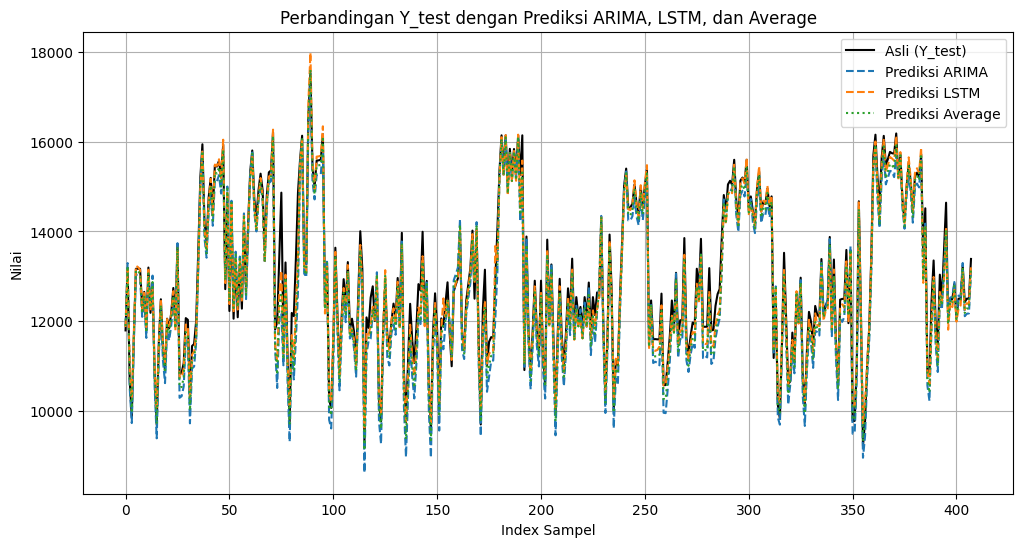

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

exog_train = df_train_scaled[['Residual']].values
exog_val = df_val_scaled[['Residual']].values
exog_test = df_test_scaled[['Residual']].values

val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

# Build model LSTM
def build_lstm_model(input_shape, output_size):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=32))
    model.add(Dropout(0.3))
    model.add(Dense(output_size))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model

# Fungsi train model LSTM menggunakan Keras
def train_lstm_keras(X_train, Y_train, X_val, Y_val, input_shape, output_size, epochs=100, batch_size=32):
    model = build_lstm_model(input_shape, output_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )
    return model, history


# Reshape input untuk LSTM (samples, timesteps=1, features)
X_train_lstm = X_train.reshape(-1, 1, X_train.shape[1])
X_val_lstm = X_val.reshape(-1, 1, X_val.shape[1])
X_test_lstm = X_test.reshape(-1, 1, X_test.shape[1])

input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
output_size = Y_train.shape[1]

# Training LSTM
lstm_model, history = train_lstm_keras(X_train_lstm, Y_train, X_val_lstm, Y_val, input_shape, output_size,
                                       epochs=100, batch_size=32)

# Fit ARIMA model
model_arima = sm.tsa.ARIMA(endog=Y_train.flatten(), exog=exog_train, order=(1,1,1))
model_fit_arima = model_arima.fit()

# =============== Prediksi Validation ===============
step_val = len(Y_val)

val_preds_arima_scaled = model_fit_arima.forecast(steps=step_val, exog=exog_val).reshape(-1,1)
lstm_preds_val = lstm_model.predict(X_val_lstm)
avg_preds_val_scaled = (val_preds_arima_scaled + lstm_preds_val) / 2

Y_val_orig = scaler_y.inverse_transform(Y_val)
val_preds_arima_orig = scaler_y.inverse_transform(val_preds_arima_scaled)
lstm_preds_val_orig = scaler_y.inverse_transform(lstm_preds_val)
avg_preds_val_orig = scaler_y.inverse_transform(avg_preds_val_scaled)

print("\n=== EVALUASI VALIDASI ===")
for name, preds_orig in zip(['ARIMA', 'LSTM', 'AVERAGE'], 
                            [val_preds_arima_orig, lstm_preds_val_orig, avg_preds_val_orig]):
    mse, rmse, mae, mape = evaluate_forecast(Y_val_orig, preds_orig)
    r2 = r2_score(Y_val_orig.flatten(), preds_orig.flatten())
    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

# Simpan metric validasi rata-rata dari average prediction
val_mse, val_rmse, val_mae, val_mape = evaluate_forecast(Y_val_orig, avg_preds_val_orig)
val_r2 = r2_score(Y_val_orig.flatten(), avg_preds_val_orig.flatten())

val_mse_list.append(val_mse)
val_rmse_list.append(val_rmse)
val_mae_list.append(val_mae)
val_mape_list.append(val_mape)
val_r2_list.append(val_r2)

# =============== Prediksi Test ===============
step_test = len(Y_test)

test_preds_arima_scaled = model_fit_arima.forecast(steps=step_test, exog=exog_test).reshape(-1,1)
lstm_preds_test = lstm_model.predict(X_test_lstm)
avg_preds_test_scaled = (test_preds_arima_scaled + lstm_preds_test) / 2

Y_test_orig = scaler_y.inverse_transform(Y_test)
test_preds_arima_orig = scaler_y.inverse_transform(test_preds_arima_scaled)
lstm_preds_test_orig = scaler_y.inverse_transform(lstm_preds_test)
avg_preds_test_orig = scaler_y.inverse_transform(avg_preds_test_scaled)

print("\n=== EVALUASI TEST ===")
for name, preds_orig in zip(['ARIMA', 'LSTM', 'AVERAGE'], 
                            [test_preds_arima_orig, lstm_preds_test_orig, avg_preds_test_orig]):
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), preds_orig.flatten())
    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

# Simpan metric test rata-rata dari average prediction
mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, avg_preds_test_orig)
r2 = r2_score(Y_test_orig.flatten(), avg_preds_test_orig.flatten())

mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

# =============== Buat DataFrame hasil evaluasi ===============
df_AEM_lstm_arima_val_gwpr = pd.DataFrame({
    'Avg MSE': [np.mean(val_mse_list)],
    'Avg RMSE': [np.mean(val_rmse_list)],
    'Avg MAE': [np.mean(val_mae_list)],
    'Avg MAPE (%)': [np.mean(val_mape_list)],
    'Avg R2': [np.mean(val_r2_list)]
})

df_AEM_lstm_arima_test_gwpr = pd.DataFrame({
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
})

print("\n=== DataFrame Evaluasi Validasi ===")
print(df_AEM_lstm_arima_val_gwpr)

print("\n=== DataFrame Evaluasi Test ===")
print(df_AEM_lstm_arima_test_gwpr)

# =============== Plot hasil prediksi test ===============
plt.figure(figsize=(12,6))
plt.plot(Y_test_orig, label='Asli (Y_test)', color='black')
plt.plot(test_preds_arima_orig, label='Prediksi ARIMA', linestyle='--')
plt.plot(lstm_preds_test_orig, label='Prediksi LSTM', linestyle='--')
plt.plot(avg_preds_test_orig, label='Prediksi Average', linestyle=':')
plt.title('Perbandingan Y_test dengan Prediksi ARIMA, LSTM, dan Average')
plt.xlabel('Index Sampel')
plt.ylabel('Nilai')
plt.legend()
plt.grid(True)
plt.show()


## LSTM + SARIMA - GWPR

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.2206 - val_loss: 0.1682 - learning_rate: 1.0000e-04
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1630 - val_loss: 0.0767 - learning_rate: 1.0000e-04
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0649 - val_loss: 0.0337 - learning_rate: 1.0000e-04
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0411 - val_loss: 0.0273 - learning_rate: 1.0000e-04
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0337 - val_loss: 0.0213 - learning_rate: 1.0000e-04
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0277 - val_loss: 0.0154 - learning_rate: 1.0000e-04
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0198 - val_loss: 0.0105 - learning_rate: 1.0000e-04
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0144 - val_loss: 0.0067 - learning_rate: 1.0000e-04
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0112 - val_loss:

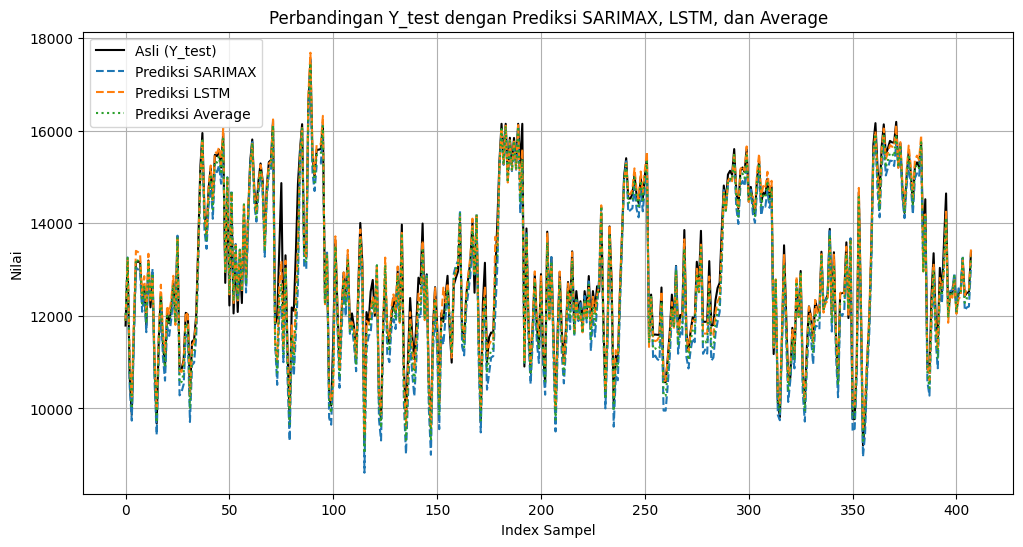

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Asumsi variabel-variabel ini sudah tersedia:
# df_train_scaled, df_val_scaled, df_test_scaled, X_train, Y_train, X_val, Y_val, X_test, Y_test
# scaler_y, dan list kosong untuk metric:
# val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list
# mse_list, rmse_list, mae_list, mape_list, r2_list

exog_train = df_train_scaled[['Residual']].values
exog_val = df_val_scaled[['Residual']].values
exog_test = df_test_scaled[['Residual']].values

val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []


# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

# Build model LSTM
def build_lstm_model(input_shape, output_size):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=32))
    model.add(Dropout(0.3))
    model.add(Dense(output_size))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model

# Fungsi train model LSTM menggunakan Keras
def train_lstm_keras(X_train, Y_train, X_val, Y_val, input_shape, output_size, epochs=100, batch_size=32):
    model = build_lstm_model(input_shape, output_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )
    return model, history

# Reshape input untuk LSTM (samples, timesteps=1, features)
X_train_lstm = X_train.reshape(-1, 1, X_train.shape[1])
X_val_lstm = X_val.reshape(-1, 1, X_val.shape[1])
X_test_lstm = X_test.reshape(-1, 1, X_test.shape[1])

input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
output_size = Y_train.shape[1]

# Training LSTM
lstm_model, history = train_lstm_keras(X_train_lstm, Y_train, X_val_lstm, Y_val, input_shape, output_size,
                                       epochs=100, batch_size=32)

# Definisikan order SARIMA
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# Fit SARIMAX model
model_sarimax = sm.tsa.SARIMAX(endog=Y_train.flatten(),
                               exog=exog_train,
                               order=order,
                               seasonal_order=seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
model_sarimax_fit = model_sarimax.fit(disp=False)

# =============== Prediksi Validation ===============
step_val = len(Y_val)

val_preds_sarimax_scaled = model_sarimax_fit.forecast(steps=step_val, exog=exog_val).reshape(-1,1)
lstm_preds_val = lstm_model.predict(X_val_lstm)
avg_preds_val_scaled = (val_preds_sarimax_scaled + lstm_preds_val) / 2

Y_val_orig = scaler_y.inverse_transform(Y_val)
val_preds_sarimax_orig = scaler_y.inverse_transform(val_preds_sarimax_scaled)
lstm_preds_val_orig = scaler_y.inverse_transform(lstm_preds_val)
avg_preds_val_orig = scaler_y.inverse_transform(avg_preds_val_scaled)

print("\n=== EVALUASI VALIDASI ===")
for name, preds_orig in zip(['SARIMAX', 'LSTM', 'AVERAGE'], 
                            [val_preds_sarimax_orig, lstm_preds_val_orig, avg_preds_val_orig]):
    mse, rmse, mae, mape = evaluate_forecast(Y_val_orig, preds_orig)
    r2 = r2_score(Y_val_orig.flatten(), preds_orig.flatten())
    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

val_mse_list.append(mse)
val_rmse_list.append(rmse)
val_mae_list.append(mae)
val_mape_list.append(mape)
val_r2_list.append(r2)

# =============== Prediksi Test ===============
step_test = len(Y_test)

test_preds_sarimax_scaled = model_sarimax_fit.forecast(steps=step_test, exog=exog_test).reshape(-1,1)
lstm_preds_test = lstm_model.predict(X_test_lstm)
avg_preds_test_scaled = (test_preds_sarimax_scaled + lstm_preds_test) / 2

Y_test_orig = scaler_y.inverse_transform(Y_test)
test_preds_sarimax_orig = scaler_y.inverse_transform(test_preds_sarimax_scaled)
lstm_preds_test_orig = scaler_y.inverse_transform(lstm_preds_test)
avg_preds_test_orig = scaler_y.inverse_transform(avg_preds_test_scaled)

print("\n=== EVALUASI TEST ===")
for name, preds_orig in zip(['SARIMAX', 'LSTM', 'AVERAGE'], 
                            [test_preds_sarimax_orig, lstm_preds_test_orig, avg_preds_test_orig]):
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), preds_orig.flatten())
    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

# =============== Buat DataFrame hasil evaluasi ===============
df_AEM_lstm_sarima_val_gwpr = pd.DataFrame({
    'Avg MSE': [np.mean(val_mse_list)],
    'Avg RMSE': [np.mean(val_rmse_list)],
    'Avg MAE': [np.mean(val_mae_list)],
    'Avg MAPE (%)': [np.mean(val_mape_list)],
    'Avg R2': [np.mean(val_r2_list)]
})

df_AEM_lstm_sarima_test_gwpr = pd.DataFrame({
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
})

print("\n=== DataFrame Evaluasi Validasi ===")
print(df_AEM_lstm_sarima_val_gwpr)

print("\n=== DataFrame Evaluasi Test ===")
print(df_AEM_lstm_sarima_test_gwpr)

# =============== Plot hasil prediksi test ===============
plt.figure(figsize=(12,6))
plt.plot(Y_test_orig, label='Asli (Y_test)', color='black')
plt.plot(test_preds_sarimax_orig, label='Prediksi SARIMAX', linestyle='--')
plt.plot(lstm_preds_test_orig, label='Prediksi LSTM', linestyle='--')
plt.plot(avg_preds_test_orig, label='Prediksi Average', linestyle=':')
plt.title('Perbandingan Y_test dengan Prediksi SARIMAX, LSTM, dan Average')
plt.xlabel('Index Sampel')
plt.ylabel('Nilai')
plt.legend()
plt.grid(True)
plt.show()


## LSTM + ARIMA + SARIMA - GWPR

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.2155 - val_loss: 0.1710 - learning_rate: 1.0000e-04
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1702 - val_loss: 0.0847 - learning_rate: 1.0000e-04
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0701 - val_loss: 0.0340 - learning_rate: 1.0000e-04
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0428 - val_loss: 0.0284 - learning_rate: 1.0000e-04
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0354 - val_loss: 0.0232 - learning_rate: 1.0000e-04
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0294 - val_loss: 0.0181 - learning_rate: 1.0000e-04
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0240 - val_loss: 0.0130 - learning_rate: 1.0000e-04
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0182 - val_loss: 0.0090 - learning_rate: 1.0000e-04
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0143 - val_loss:

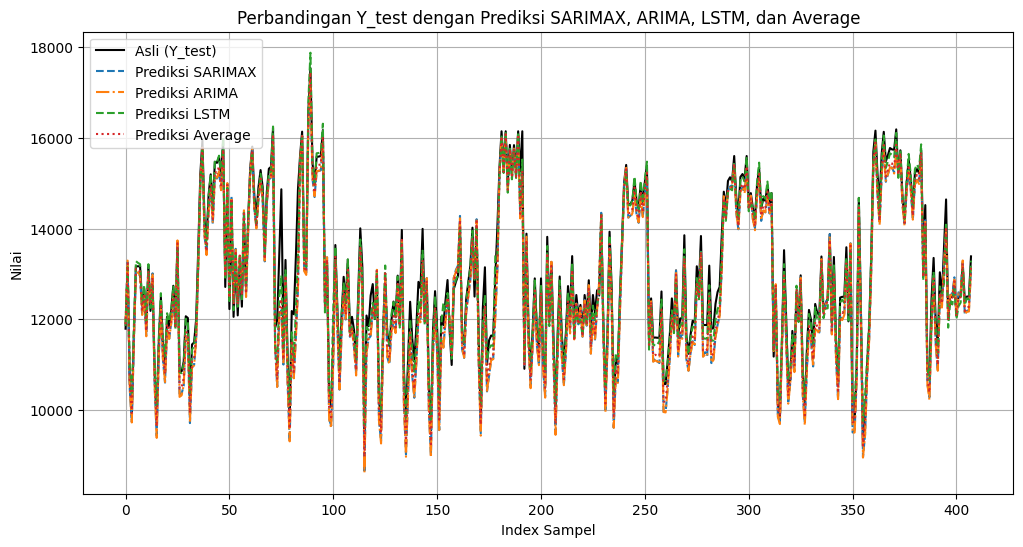

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Asumsi variabel-variabel ini sudah tersedia:
# df_train_scaled, df_val_scaled, df_test_scaled, X_train, Y_train, X_val, Y_val, X_test, Y_test
# scaler_y, dan list kosong untuk metric:
# val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list
# mse_list, rmse_list, mae_list, mape_list, r2_list

exog_train = df_train_scaled[['Residual']].values
exog_val = df_val_scaled[['Residual']].values
exog_test = df_test_scaled[['Residual']].values
val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

# Build model LSTM
def build_lstm_model(input_shape, output_size):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=32))
    model.add(Dropout(0.3))
    model.add(Dense(output_size))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model

# Fungsi train model LSTM menggunakan Keras
def train_lstm_keras(X_train, Y_train, X_val, Y_val, input_shape, output_size, epochs=100, batch_size=32):
    model = build_lstm_model(input_shape, output_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )
    return model, history

# Reshape input untuk LSTM (samples, timesteps=1, features)
X_train_lstm = X_train.reshape(-1, 1, X_train.shape[1])
X_val_lstm = X_val.reshape(-1, 1, X_val.shape[1])
X_test_lstm = X_test.reshape(-1, 1, X_test.shape[1])

input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
output_size = Y_train.shape[1]

# Training LSTM
lstm_model, history = train_lstm_keras(X_train_lstm, Y_train, X_val_lstm, Y_val, input_shape, output_size,
                                       epochs=100, batch_size=32)

# Definisikan order SARIMA
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

# Fit SARIMAX model
model_sarimax = sm.tsa.SARIMAX(endog=Y_train.flatten(),
                               exog=exog_train,
                               order=order,
                               seasonal_order=seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
model_sarimax_fit = model_sarimax.fit(disp=False)


# Fit ARIMA model
model_arima = ARIMA(endog=Y_train.flatten(), exog=exog_train, order=order)
model_arima_fit = model_arima.fit()

# =============== Prediksi Validation ===============
step_val = len(Y_val)

val_preds_sarimax_scaled = model_sarimax_fit.forecast(steps=step_val, exog=exog_val).reshape(-1,1)
val_preds_arima_scaled = model_arima_fit.forecast(steps=step_val, exog=exog_val).reshape(-1,1)
lstm_preds_val = lstm_model.predict(X_val_lstm)

# Rata-rata prediksi ketiga model
avg_preds_val_scaled = (val_preds_sarimax_scaled + val_preds_arima_scaled + lstm_preds_val) / 3

Y_val_orig = scaler_y.inverse_transform(Y_val)
val_preds_sarimax_orig = scaler_y.inverse_transform(val_preds_sarimax_scaled)
val_preds_arima_orig = scaler_y.inverse_transform(val_preds_arima_scaled)
lstm_preds_val_orig = scaler_y.inverse_transform(lstm_preds_val)
avg_preds_val_orig = scaler_y.inverse_transform(avg_preds_val_scaled)

print("\n=== EVALUASI VALIDASI ===")
for name, preds_orig in zip(['SARIMAX', 'ARIMA', 'LSTM', 'AVERAGE'], 
                            [val_preds_sarimax_orig, val_preds_arima_orig, lstm_preds_val_orig, avg_preds_val_orig]):
    mse, rmse, mae, mape = evaluate_forecast(Y_val_orig, preds_orig)
    r2 = r2_score(Y_val_orig.flatten(), preds_orig.flatten())
    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

val_mse_list.append(mse)
val_rmse_list.append(rmse)
val_mae_list.append(mae)
val_mape_list.append(mape)
val_r2_list.append(r2)

# =============== Prediksi Test ===============
step_test = len(Y_test)

test_preds_sarimax_scaled = model_sarimax_fit.forecast(steps=step_test, exog=exog_test).reshape(-1,1)
test_preds_arima_scaled = model_arima_fit.forecast(steps=step_test,exog=exog_test).reshape(-1,1)
lstm_preds_test = lstm_model.predict(X_test_lstm)

avg_preds_test_scaled = (test_preds_sarimax_scaled + test_preds_arima_scaled + lstm_preds_test) / 3

Y_test_orig = scaler_y.inverse_transform(Y_test)
test_preds_sarimax_orig = scaler_y.inverse_transform(test_preds_sarimax_scaled)
test_preds_arima_orig = scaler_y.inverse_transform(test_preds_arima_scaled)
lstm_preds_test_orig = scaler_y.inverse_transform(lstm_preds_test)
avg_preds_test_orig = scaler_y.inverse_transform(avg_preds_test_scaled)

print("\n=== EVALUASI TEST ===")
for name, preds_orig in zip(['SARIMAX', 'ARIMA', 'LSTM', 'AVERAGE'], 
                            [test_preds_sarimax_orig, test_preds_arima_orig, lstm_preds_test_orig, avg_preds_test_orig]):
    mse, rmse, mae, mape = evaluate_forecast(Y_test_orig, preds_orig)
    r2 = r2_score(Y_test_orig.flatten(), preds_orig.flatten())
    print(f"{name} - MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

# =============== Buat DataFrame hasil evaluasi ===============
df_AEM_lstm_arima_sarima_val_gwpr = pd.DataFrame({
    'Avg MSE': [np.mean(val_mse_list)],
    'Avg RMSE': [np.mean(val_rmse_list)],
    'Avg MAE': [np.mean(val_mae_list)],
    'Avg MAPE (%)': [np.mean(val_mape_list)],
    'Avg R2': [np.mean(val_r2_list)]
})

df_AEM_lstm_arima_sarima_test_gwpr = pd.DataFrame({
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
})

print("\n=== DataFrame Evaluasi Validasi ===")
print(df_AEM_lstm_arima_sarima_val_gwpr)

print("\n=== DataFrame Evaluasi Test ===")
print(df_AEM_lstm_arima_sarima_test_gwpr)

# =============== Plot hasil prediksi test ===============
plt.figure(figsize=(12,6))
plt.plot(Y_test_orig, label='Asli (Y_test)', color='black')
plt.plot(test_preds_sarimax_orig, label='Prediksi SARIMAX', linestyle='--')
plt.plot(test_preds_arima_orig, label='Prediksi ARIMA', linestyle='-.')
plt.plot(lstm_preds_test_orig, label='Prediksi LSTM', linestyle='--')
plt.plot(avg_preds_test_orig, label='Prediksi Average', linestyle=':')
plt.title('Perbandingan Y_test dengan Prediksi SARIMAX, ARIMA, LSTM, dan Average')
plt.xlabel('Index Sampel')
plt.ylabel('Nilai')
plt.legend()
plt.grid(True)
plt.show()


# MLP - MODELS - DENGAN GWPR

## ARIMA SARIMA (MLP - GWPR)

In [108]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

# Dummy placeholders (ganti dengan datamu)
# df_train_scaled, df_val_scaled, df_test_scaled, Y_train, Y_val, Y_test, scaler_y harus sudah tersedia

# === Ekstraksi variabel eksogen ===
exog_train = df_train_scaled[['Residual']].values
exog_val = df_val_scaled[['Residual']].values
exog_test = df_test_scaled[['Residual']].values

step_val = len(Y_val)
step_test = len(Y_test)

# === Model ARIMA ===
model_arima = sm.tsa.ARIMA(endog=Y_train.flatten(), exog=exog_train, order=(1, 1, 1))
model_arima_fit = model_arima.fit()

# === Model SARIMAX ===
model_sarimax = sm.tsa.SARIMAX(endog=Y_train.flatten(),
                               exog=exog_train,
                               order=(1, 1, 1),
                               seasonal_order=(1,1,1,12),
                               enforce_stationarity=False,
                               enforce_invertibility=False)
model_sarimax_fit = model_sarimax.fit(disp=False)

# === Prediksi untuk Validasi ===
arima_pred_val = model_arima_fit.forecast(steps=step_val, exog=exog_val)
sarimax_pred_val = model_sarimax_fit.forecast(steps=step_val, exog=exog_val)

# === Prediksi untuk Test ===
arima_pred_test = model_arima_fit.forecast(steps=step_test, exog=exog_test)
sarimax_pred_test = model_sarimax_fit.forecast(steps=step_test, exog=exog_test)

# === Gabungkan prediksi untuk Meta-Learner ===
X_meta_val = np.column_stack([arima_pred_val, sarimax_pred_val])
X_meta_test = np.column_stack([arima_pred_test, sarimax_pred_test])

# Target aslinya
y_meta_val = Y_val.reshape(-1,1)
y_meta_test = Y_test.reshape(-1,1)

# === MLP Meta-Learner ===
def train_mlp_meta_learner(X_meta_train, y_meta_train, X_meta_test, epochs=50, batch_size=32):
    input_dim = X_meta_train.shape[1]

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(y_meta_train.shape[1])  # output shape sesuai target dimensi (steps)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    model.fit(X_meta_train, y_meta_train, epochs=epochs, batch_size=batch_size, verbose=0)
    preds = model.predict(X_meta_test)
    return model, preds

mlp_test, pred_test = train_mlp_meta_learner(X_meta_val, y_meta_val, X_meta_test)
mlp_val, pred_val = train_mlp_meta_learner(X_meta_test, y_meta_test, X_meta_val)

# Inverse transform hasil prediksi dan target
Y_val_orig = scaler_y.inverse_transform(Y_val.reshape(-1, 1))
Y_test_orig = scaler_y.inverse_transform(Y_test.reshape(-1, 1))
meta_pred_val_orig = scaler_y.inverse_transform(pred_val.reshape(-1, 1))
meta_pred_test_orig = scaler_y.inverse_transform(pred_test.reshape(-1, 1))

# === Evaluasi ===
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    return mse, rmse, mae, mape, r2

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []

# Evaluasi Test
mse, rmse, mae, mape, r2 = evaluate_forecast(Y_test_orig, meta_pred_test_orig)
mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

# Evaluasi Validation
val_mse, val_rmse, val_mae, val_mape, val_r2 = evaluate_forecast(Y_val_orig, meta_pred_val_orig)
val_mse_list.append(val_mse)
val_rmse_list.append(val_rmse)
val_mae_list.append(val_mae)
val_mape_list.append(val_mape)
val_r2_list.append(val_r2)

# === Output Hasil Evaluasi ===
print("\n=== EVALUASI TEST ===")
print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

print("\n=== EVALUASI VALIDASI ===")
print(f"MSE: {val_mse:.4f} | RMSE: {val_rmse:.4f} | MAE: {val_mae:.4f} | MAPE: {val_mape:.2f}% | R2: {val_r2:.4f}")

# DataFrame hasil
df_MLP_arima_sarima_test_gwpr = pd.DataFrame({
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
})

df_MLP_arima_sarima_val_gwpr = pd.DataFrame({
    'Avg MSE': [np.mean(val_mse_list)],
    'Avg RMSE': [np.mean(val_rmse_list)],
    'Avg MAE': [np.mean(val_mae_list)],
    'Avg MAPE (%)': [np.mean(val_mape_list)],
    'Avg R2': [np.mean(val_r2_list)]
})

print("\n=== RATA-RATA EVALUASI TEST (MLP) ===")
print(df_MLP_arima_sarima_test_gwpr)

print("\n=== RATA-RATA EVALUASI VALIDASI (MLP) ===")
print(df_MLP_arima_sarima_val_gwpr)

# Variansi untuk tambahan info
print("Variance Y_test_orig:", np.var(Y_test_orig))
print("Variance Y_val_orig:", np.var(Y_val_orig))



13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

=== EVALUASI TEST ===
MSE: 210116.4150 | RMSE: 458.3846 | MAE: 359.0853 | MAPE: 2.91% | R2: 0.9259

=== EVALUASI VALIDASI ===
MSE: 235037.7549 | RMSE: 484.8069 | MAE: 341.6929 | MAPE: 3.57% | R2: 0.9268

=== RATA-RATA EVALUASI TEST (MLP) ===
         Avg MSE    Avg RMSE     Avg MAE  Avg MAPE (%)    Avg R2
0  210116.414961  458.384571  359.085292      2.906578  0.925926

=== RATA-RATA EVALUASI VALIDASI (MLP) ===
         Avg MSE    Avg RMSE     Avg MAE  Avg MAPE (%)    Avg R2
0  235037.754863  484.806925  341.692877      3.572394  0.926839
Variance Y_test_orig: 2836555.9105742844
Variance Y_val_orig: 3212591.8889441164


## LSTM + ARIMA (MLP - GWPR)

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

exog_train = df_train_scaled[['Residual']].values
exog_val = df_val_scaled[['Residual']].values
exog_test = df_test_scaled[['Residual']].values

val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

# Build model LSTM
def build_lstm_model(input_shape, output_size):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=32))
    model.add(Dropout(0.3))
    model.add(Dense(output_size))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model

# Fungsi train model LSTM menggunakan Keras
def train_lstm_keras(X_train, Y_train, X_val, Y_val, input_shape, output_size, epochs=100, batch_size=32):
    model = build_lstm_model(input_shape, output_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )
    return model, history


# Reshape input untuk LSTM (samples, timesteps=1, features)
X_train_lstm = X_train.reshape(-1, 1, X_train.shape[1])
X_val_lstm = X_val.reshape(-1, 1, X_val.shape[1])
X_test_lstm = X_test.reshape(-1, 1, X_test.shape[1])

input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
output_size = Y_train.shape[1]



# Fit ARIMA model
model_arima = sm.tsa.ARIMA(endog=Y_train.flatten(), exog=exog_train, order=(1,1,1))
model_fit_arima = model_arima.fit()

# =============== Prediksi Testing ===============
# Training LSTM
lstm_model, history = train_lstm_keras(X_train_lstm, Y_train, X_val_lstm, Y_val, input_shape, output_size,
                                       epochs=100, batch_size=32)

step_test = len(Y_test)
arima_pred_test = model_fit_arima.forecast(steps=step_test, exog=exog_test).reshape(-1,1)
lstm_pred_test = lstm_model.predict(X_test_lstm)

# =============== Prediksi Validation ===============
lstm_model, history = train_lstm_keras(X_train_lstm, Y_train, X_test_lstm, Y_test, input_shape, output_size,
                                       epochs=100, batch_size=32)
step_val = len(Y_val)
arima_pred_val = model_fit_arima.forecast(steps=step_val, exog=exog_val).reshape(-1,1)
lstm_pred_val = lstm_model.predict(X_val_lstm)


# === Gabungkan prediksi untuk Meta-Learner ===
X_meta_val = np.column_stack([arima_pred_val, lstm_pred_val])
X_meta_test = np.column_stack([arima_pred_test, lstm_pred_test])

# Target aslinya
y_meta_val = Y_val.reshape(-1,1)
y_meta_test = Y_test.reshape(-1,1)

# === MLP Meta-Learner ===
def train_mlp_meta_learner(X_meta_train, y_meta_train, X_meta_test, epochs=50, batch_size=32):
    input_dim = X_meta_train.shape[1]

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(y_meta_train.shape[1])  # output shape sesuai target dimensi (steps)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    model.fit(X_meta_train, y_meta_train, epochs=epochs, batch_size=batch_size, verbose=0)
    preds = model.predict(X_meta_test)
    return model, preds

mlp_test, pred_test = train_mlp_meta_learner(X_meta_val, y_meta_val, X_meta_test)
mlp_val, pred_val = train_mlp_meta_learner(X_meta_test, y_meta_test, X_meta_val)

# Inverse transform hasil prediksi dan target
Y_val_orig = scaler_y.inverse_transform(Y_val.reshape(-1, 1))
Y_test_orig = scaler_y.inverse_transform(Y_test.reshape(-1, 1))
meta_pred_val_orig = scaler_y.inverse_transform(pred_val.reshape(-1, 1))
meta_pred_test_orig = scaler_y.inverse_transform(pred_test.reshape(-1, 1))

# === Evaluasi ===
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    return mse, rmse, mae, mape, r2

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []

# Evaluasi Test
mse, rmse, mae, mape, r2 = evaluate_forecast(Y_test_orig, meta_pred_test_orig)
mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

# Evaluasi Validation
val_mse, val_rmse, val_mae, val_mape, val_r2 = evaluate_forecast(Y_val_orig, meta_pred_val_orig)
val_mse_list.append(val_mse)
val_rmse_list.append(val_rmse)
val_mae_list.append(val_mae)
val_mape_list.append(val_mape)
val_r2_list.append(val_r2)

# === Output Hasil Evaluasi ===
print("\n=== EVALUASI TEST ===")
print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

print("\n=== EVALUASI VALIDASI ===")
print(f"MSE: {val_mse:.4f} | RMSE: {val_rmse:.4f} | MAE: {val_mae:.4f} | MAPE: {val_mape:.2f}% | R2: {val_r2:.4f}")

# DataFrame hasil
df_MLP_lstm_arima_test_gwpr = pd.DataFrame({
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
})

df_MLP_lstm_arima_val_gwpr = pd.DataFrame({
    'Avg MSE': [np.mean(val_mse_list)],
    'Avg RMSE': [np.mean(val_rmse_list)],
    'Avg MAE': [np.mean(val_mae_list)],
    'Avg MAPE (%)': [np.mean(val_mape_list)],
    'Avg R2': [np.mean(val_r2_list)]
})

print("\n=== RATA-RATA EVALUASI TEST (MLP) ===")
print(df_MLP_lstm_arima_test_gwpr)

print("\n=== RATA-RATA EVALUASI VALIDASI (MLP) ===")
print(df_MLP_lstm_arima_val_gwpr)

# Variansi untuk tambahan info
print("Variance Y_test_orig:", np.var(Y_test_orig))
print("Variance Y_val_orig:", np.var(Y_val_orig))




Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.2257 - val_loss: 0.1704 - learning_rate: 1.0000e-04
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1650 - val_loss: 0.0798 - learning_rate: 1.0000e-04
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0692 - val_loss: 0.0347 - learning_rate: 1.0000e-04
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0413 - val_loss: 0.0288 - learning_rate: 1.0000e-04
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0353 - val_loss: 0.0228 - learning_rate: 1.0000e-04
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0287 - val_loss: 0.0170 - learning_rate: 1.0000e-04
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0207 - val_loss: 0.0118 - learning_rate: 1.0000e-04
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0166 - val_loss: 0.0076 - learning_rate: 1.0000e-04
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0126 - val_loss

## LSTM + SARIMA (MLP - GWPR)

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

exog_train = df_train_scaled[['Residual']].values
exog_val = df_val_scaled[['Residual']].values
exog_test = df_test_scaled[['Residual']].values

val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

# Build model LSTM
def build_lstm_model(input_shape, output_size):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=32))
    model.add(Dropout(0.3))
    model.add(Dense(output_size))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model

# Fungsi train model LSTM menggunakan Keras
def train_lstm_keras(X_train, Y_train, X_val, Y_val, input_shape, output_size, epochs=100, batch_size=32):
    model = build_lstm_model(input_shape, output_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )
    return model, history


# Reshape input untuk LSTM (samples, timesteps=1, features)
X_train_lstm = X_train.reshape(-1, 1, X_train.shape[1])
X_val_lstm = X_val.reshape(-1, 1, X_val.shape[1])
X_test_lstm = X_test.reshape(-1, 1, X_test.shape[1])

input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
output_size = Y_train.shape[1]

# Fit ARIMA model
seasonal_order = (1,1,1,12)
model_sarima = sm.tsa.SARIMAX(endog=Y_train.flatten(),
                               exog=exog_train,
                               order=order,
                               seasonal_order=seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
model_sarima_fit = model_sarima.fit(disp=False)
# =============== Prediksi Testing ===============
# Training LSTM
lstm_model, history = train_lstm_keras(X_train_lstm, Y_train, X_val_lstm, Y_val, input_shape, output_size,
                                       epochs=100, batch_size=32)

step_test = len(Y_test)
sarima_pred_test = model_sarima_fit.forecast(steps=step_test, exog=exog_test).reshape(-1,1)
lstm_pred_test = lstm_model.predict(X_test_lstm)

# =============== Prediksi Validation ===============
lstm_model, history = train_lstm_keras(X_train_lstm, Y_train, X_test_lstm, Y_test, input_shape, output_size,
                                       epochs=100, batch_size=32)
step_val = len(Y_val)
sarima_pred_val = model_sarima_fit.forecast(steps=step_val, exog=exog_val).reshape(-1,1)
lstm_pred_val = lstm_model.predict(X_val_lstm)


# === Gabungkan prediksi untuk Meta-Learner ===
X_meta_val = np.column_stack([sarima_pred_val, lstm_pred_val])
X_meta_test = np.column_stack([sarima_pred_test, lstm_pred_test])

# Target aslinya
y_meta_val = Y_val.reshape(-1,1)
y_meta_test = Y_test.reshape(-1,1)

# === MLP Meta-Learner ===
def train_mlp_meta_learner(X_meta_train, y_meta_train, X_meta_test, epochs=50, batch_size=32):
    input_dim = X_meta_train.shape[1]

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(y_meta_train.shape[1])  # output shape sesuai target dimensi (steps)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    model.fit(X_meta_train, y_meta_train, epochs=epochs, batch_size=batch_size, verbose=0)
    preds = model.predict(X_meta_test)
    return model, preds

mlp_test, pred_test = train_mlp_meta_learner(X_meta_val, y_meta_val, X_meta_test)
mlp_val, pred_val = train_mlp_meta_learner(X_meta_test, y_meta_test, X_meta_val)

# Inverse transform hasil prediksi dan target
Y_val_orig = scaler_y.inverse_transform(Y_val.reshape(-1, 1))
Y_test_orig = scaler_y.inverse_transform(Y_test.reshape(-1, 1))
meta_pred_val_orig = scaler_y.inverse_transform(pred_val.reshape(-1, 1))
meta_pred_test_orig = scaler_y.inverse_transform(pred_test.reshape(-1, 1))

# === Evaluasi ===
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    return mse, rmse, mae, mape, r2

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []

# Evaluasi Test
mse, rmse, mae, mape, r2 = evaluate_forecast(Y_test_orig, meta_pred_test_orig)
mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

# Evaluasi Validation
val_mse, val_rmse, val_mae, val_mape, val_r2 = evaluate_forecast(Y_val_orig, meta_pred_val_orig)
val_mse_list.append(val_mse)
val_rmse_list.append(val_rmse)
val_mae_list.append(val_mae)
val_mape_list.append(val_mape)
val_r2_list.append(val_r2)

# === Output Hasil Evaluasi ===
print("\n=== EVALUASI TEST ===")
print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

print("\n=== EVALUASI VALIDASI ===")
print(f"MSE: {val_mse:.4f} | RMSE: {val_rmse:.4f} | MAE: {val_mae:.4f} | MAPE: {val_mape:.2f}% | R2: {val_r2:.4f}")

# DataFrame hasil
df_MLP_lstm_sarima_test_gwpr = pd.DataFrame({
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
})

df_MLP_lstm_sarima_val_gwpr = pd.DataFrame({
    'Avg MSE': [np.mean(val_mse_list)],
    'Avg RMSE': [np.mean(val_rmse_list)],
    'Avg MAE': [np.mean(val_mae_list)],
    'Avg MAPE (%)': [np.mean(val_mape_list)],
    'Avg R2': [np.mean(val_r2_list)]
})

print("\n=== RATA-RATA EVALUASI TEST (MLP) ===")
print(df_MLP_lstm_sarima_test_gwpr)

print("\n=== RATA-RATA EVALUASI VALIDASI (MLP) ===")
print(df_MLP_lstm_sarima_val_gwpr)

# Variansi untuk tambahan info
print("Variance Y_test_orig:", np.var(Y_test_orig))
print("Variance Y_val_orig:", np.var(Y_val_orig))




Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.2138 - val_loss: 0.1673 - learning_rate: 1.0000e-04
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1651 - val_loss: 0.0764 - learning_rate: 1.0000e-04
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0666 - val_loss: 0.0334 - learning_rate: 1.0000e-04
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0399 - val_loss: 0.0272 - learning_rate: 1.0000e-04
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0335 - val_loss: 0.0210 - learning_rate: 1.0000e-04
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0258 - val_loss: 0.0150 - learning_rate: 1.0000e-04
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0190 - val_loss: 0.0098 - learning_rate: 1.0000e-04
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0137 - val_loss: 0.0064 - learning_rate: 1.0000e-04
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0104 - val_loss

## LSTM + ARIMA + SARIMA (MLP- GWPR)

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

exog_train = df_train_scaled[['Residual']].values
exog_val = df_val_scaled[['Residual']].values
exog_test = df_test_scaled[['Residual']].values

val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []

# Fungsi evaluasi
def evaluate_forecast(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mse, rmse, mae, mape

# Build model LSTM
def build_lstm_model(input_shape, output_size):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=32))
    model.add(Dropout(0.3))
    model.add(Dense(output_size))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
    return model

# Fungsi train model LSTM menggunakan Keras
def train_lstm_keras(X_train, Y_train, X_val, Y_val, input_shape, output_size, epochs=100, batch_size=32):
    model = build_lstm_model(input_shape, output_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )
    return model, history


# Reshape input untuk LSTM (samples, timesteps=1, features)
X_train_lstm = X_train.reshape(-1, 1, X_train.shape[1])
X_val_lstm = X_val.reshape(-1, 1, X_val.shape[1])
X_test_lstm = X_test.reshape(-1, 1, X_test.shape[1])

input_shape = (X_train_lstm.shape[1], X_train_lstm.shape[2])
output_size = Y_train.shape[1]

# Fit ARIMA model
model_arima = sm.tsa.ARIMA(endog=Y_train.flatten(), exog=exog_train, order=(1, 1, 1))
model_arima_fit = model_arima.fit()

#FIT SARIMA model
seasonal_order = (1,1,1,12)
model_sarima = sm.tsa.SARIMAX(endog=Y_train.flatten(),
                               exog=exog_train,
                               order=order,
                               seasonal_order=seasonal_order,
                               enforce_stationarity=False,
                               enforce_invertibility=False)
model_sarima_fit = model_sarima.fit(disp=False)
# =============== Prediksi Testing ===============
# Training LSTM
lstm_model, history = train_lstm_keras(X_train_lstm, Y_train, X_val_lstm, Y_val, input_shape, output_size,
                                       epochs=100, batch_size=32)

step_test = len(Y_test)
arima_pred_test = model_arima_fit.forecast(steps=step_test, exog=exog_test).reshape(-1,1)
sarima_pred_test = model_sarima_fit.forecast(steps=step_test, exog=exog_test).reshape(-1,1)
lstm_pred_test = lstm_model.predict(X_test_lstm)

# =============== Prediksi Validation ===============
lstm_model, history = train_lstm_keras(X_train_lstm, Y_train, X_test_lstm, Y_test, input_shape, output_size,
                                       epochs=100, batch_size=32)
step_val = len(Y_val)
arima_pred_val = model_arima_fit.forecast(steps=step_val, exog=exog_val).reshape(-1,1)
sarima_pred_val = model_sarima_fit.forecast(steps=step_val, exog=exog_val).reshape(-1,1)
lstm_pred_val = lstm_model.predict(X_val_lstm)


# === Gabungkan prediksi untuk Meta-Learner ===
X_meta_val = np.column_stack([arima_pred_val, sarima_pred_val, lstm_pred_val])
X_meta_test = np.column_stack([arima_pred_test, sarima_pred_test, lstm_pred_test])

# Target aslinya
y_meta_val = Y_val.reshape(-1,1)
y_meta_test = Y_test.reshape(-1,1)

# === MLP Meta-Learner ===
def train_mlp_meta_learner(X_meta_train, y_meta_train, X_meta_test, epochs=50, batch_size=32):
    input_dim = X_meta_train.shape[1]

    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(y_meta_train.shape[1])  # output shape sesuai target dimensi (steps)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    model.fit(X_meta_train, y_meta_train, epochs=epochs, batch_size=batch_size, verbose=0)
    preds = model.predict(X_meta_test)
    return model, preds

mlp_test, pred_test = train_mlp_meta_learner(X_meta_val, y_meta_val, X_meta_test)
mlp_val, pred_val = train_mlp_meta_learner(X_meta_test, y_meta_test, X_meta_val)

# Inverse transform hasil prediksi dan target
Y_val_orig = scaler_y.inverse_transform(Y_val.reshape(-1, 1))
Y_test_orig = scaler_y.inverse_transform(Y_test.reshape(-1, 1))
meta_pred_val_orig = scaler_y.inverse_transform(pred_val.reshape(-1, 1))
meta_pred_test_orig = scaler_y.inverse_transform(pred_test.reshape(-1, 1))

# === Evaluasi ===
def evaluate_forecast(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true.flatten(), y_pred.flatten())
    return mse, rmse, mae, mape, r2

# Simpan hasil evaluasi
mse_list, rmse_list, mae_list, mape_list, r2_list = [], [], [], [], []
val_mse_list, val_rmse_list, val_mae_list, val_mape_list, val_r2_list = [], [], [], [], []

# Evaluasi Test
mse, rmse, mae, mape, r2 = evaluate_forecast(Y_test_orig, meta_pred_test_orig)
mse_list.append(mse)
rmse_list.append(rmse)
mae_list.append(mae)
mape_list.append(mape)
r2_list.append(r2)

# Evaluasi Validation
val_mse, val_rmse, val_mae, val_mape, val_r2 = evaluate_forecast(Y_val_orig, meta_pred_val_orig)
val_mse_list.append(val_mse)
val_rmse_list.append(val_rmse)
val_mae_list.append(val_mae)
val_mape_list.append(val_mape)
val_r2_list.append(val_r2)

# === Output Hasil Evaluasi ===
print("\n=== EVALUASI TEST ===")
print(f"MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R2: {r2:.4f}")

print("\n=== EVALUASI VALIDASI ===")
print(f"MSE: {val_mse:.4f} | RMSE: {val_rmse:.4f} | MAE: {val_mae:.4f} | MAPE: {val_mape:.2f}% | R2: {val_r2:.4f}")

# DataFrame hasil
df_MLP_lstm_arima_sarima_test_gwpr = pd.DataFrame({
    'Avg MSE': [np.mean(mse_list)],
    'Avg RMSE': [np.mean(rmse_list)],
    'Avg MAE': [np.mean(mae_list)],
    'Avg MAPE (%)': [np.mean(mape_list)],
    'Avg R2': [np.mean(r2_list)]
})

df_MLP_lstm_arima_sarima_val_gwpr = pd.DataFrame({
    'Avg MSE': [np.mean(val_mse_list)],
    'Avg RMSE': [np.mean(val_rmse_list)],
    'Avg MAE': [np.mean(val_mae_list)],
    'Avg MAPE (%)': [np.mean(val_mape_list)],
    'Avg R2': [np.mean(val_r2_list)]
})

print("\n=== RATA-RATA EVALUASI TEST (MLP) ===")
print(df_MLP_lstm_arima_sarima_test_gwpr)

print("\n=== RATA-RATA EVALUASI VALIDASI (MLP) ===")
print(df_MLP_lstm_arima_sarima_val_gwpr)

# Variansi untuk tambahan info
print("Variance Y_test_orig:", np.var(Y_test_orig))
print("Variance Y_val_orig:", np.var(Y_val_orig))




Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.2210 - val_loss: 0.1741 - learning_rate: 1.0000e-04
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1778 - val_loss: 0.0884 - learning_rate: 1.0000e-04
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0753 - val_loss: 0.0351 - learning_rate: 1.0000e-04
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0437 - val_loss: 0.0291 - learning_rate: 1.0000e-04
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0357 - val_loss: 0.0235 - learning_rate: 1.0000e-04
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0288 - val_loss: 0.0179 - learning_rate: 1.0000e-04
Epoch 7/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0220 - val_loss: 0.0127 - learning_rate: 1.0000e-04
Epoch 8/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0176 - val_loss: 0.0085 - learning_rate: 1.0000e-04
Epoch 9/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0129 - val_loss

# EVALUASI MODEL HYBRID (NON GWPR VS GWPR)

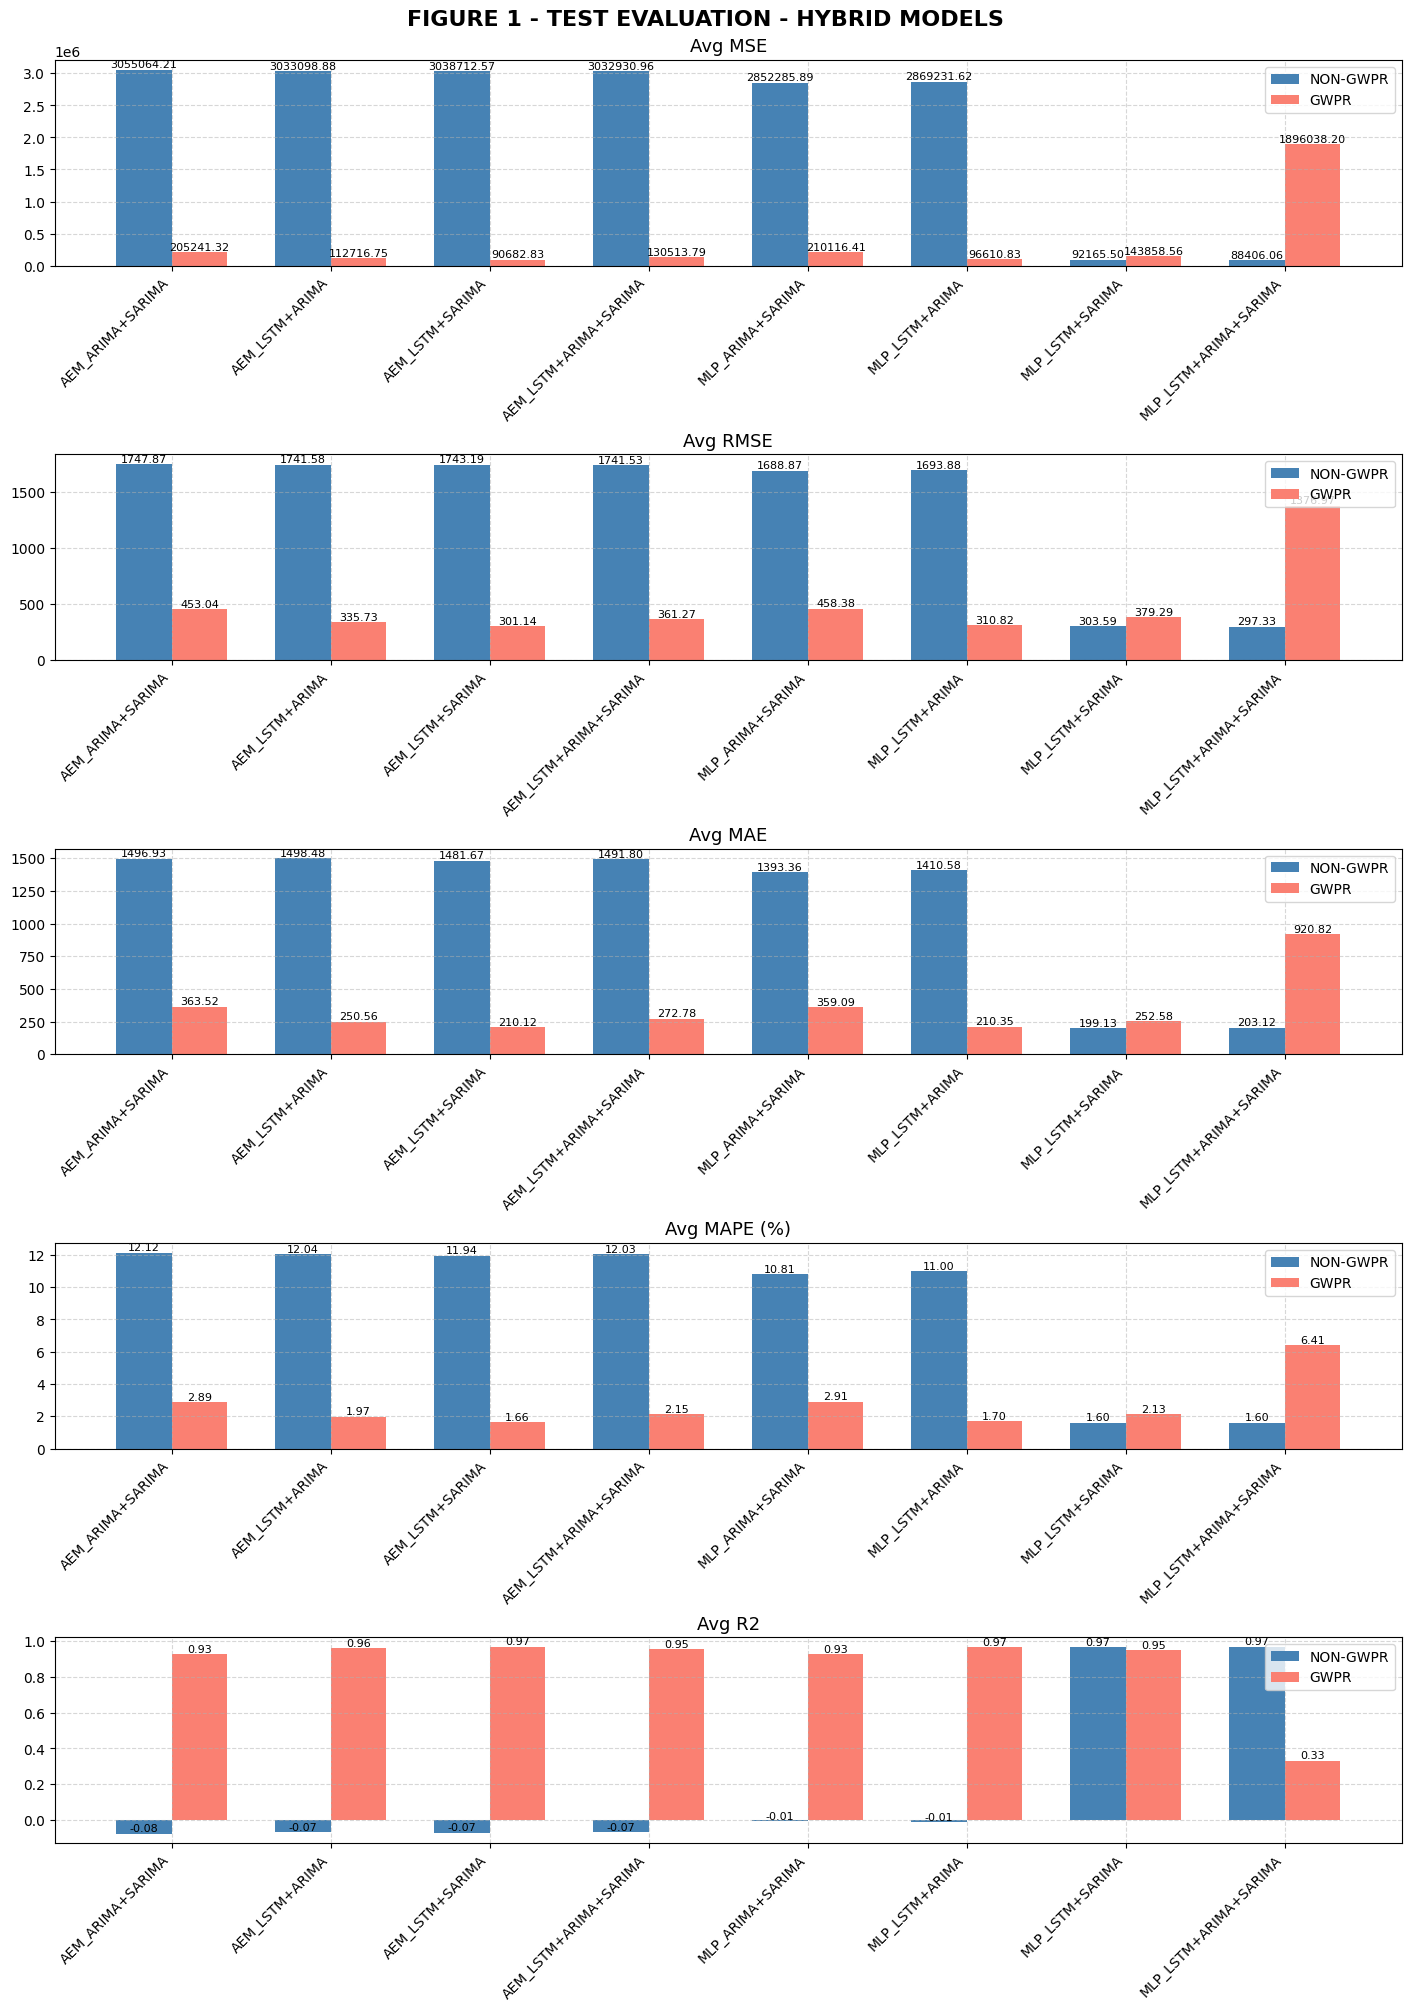

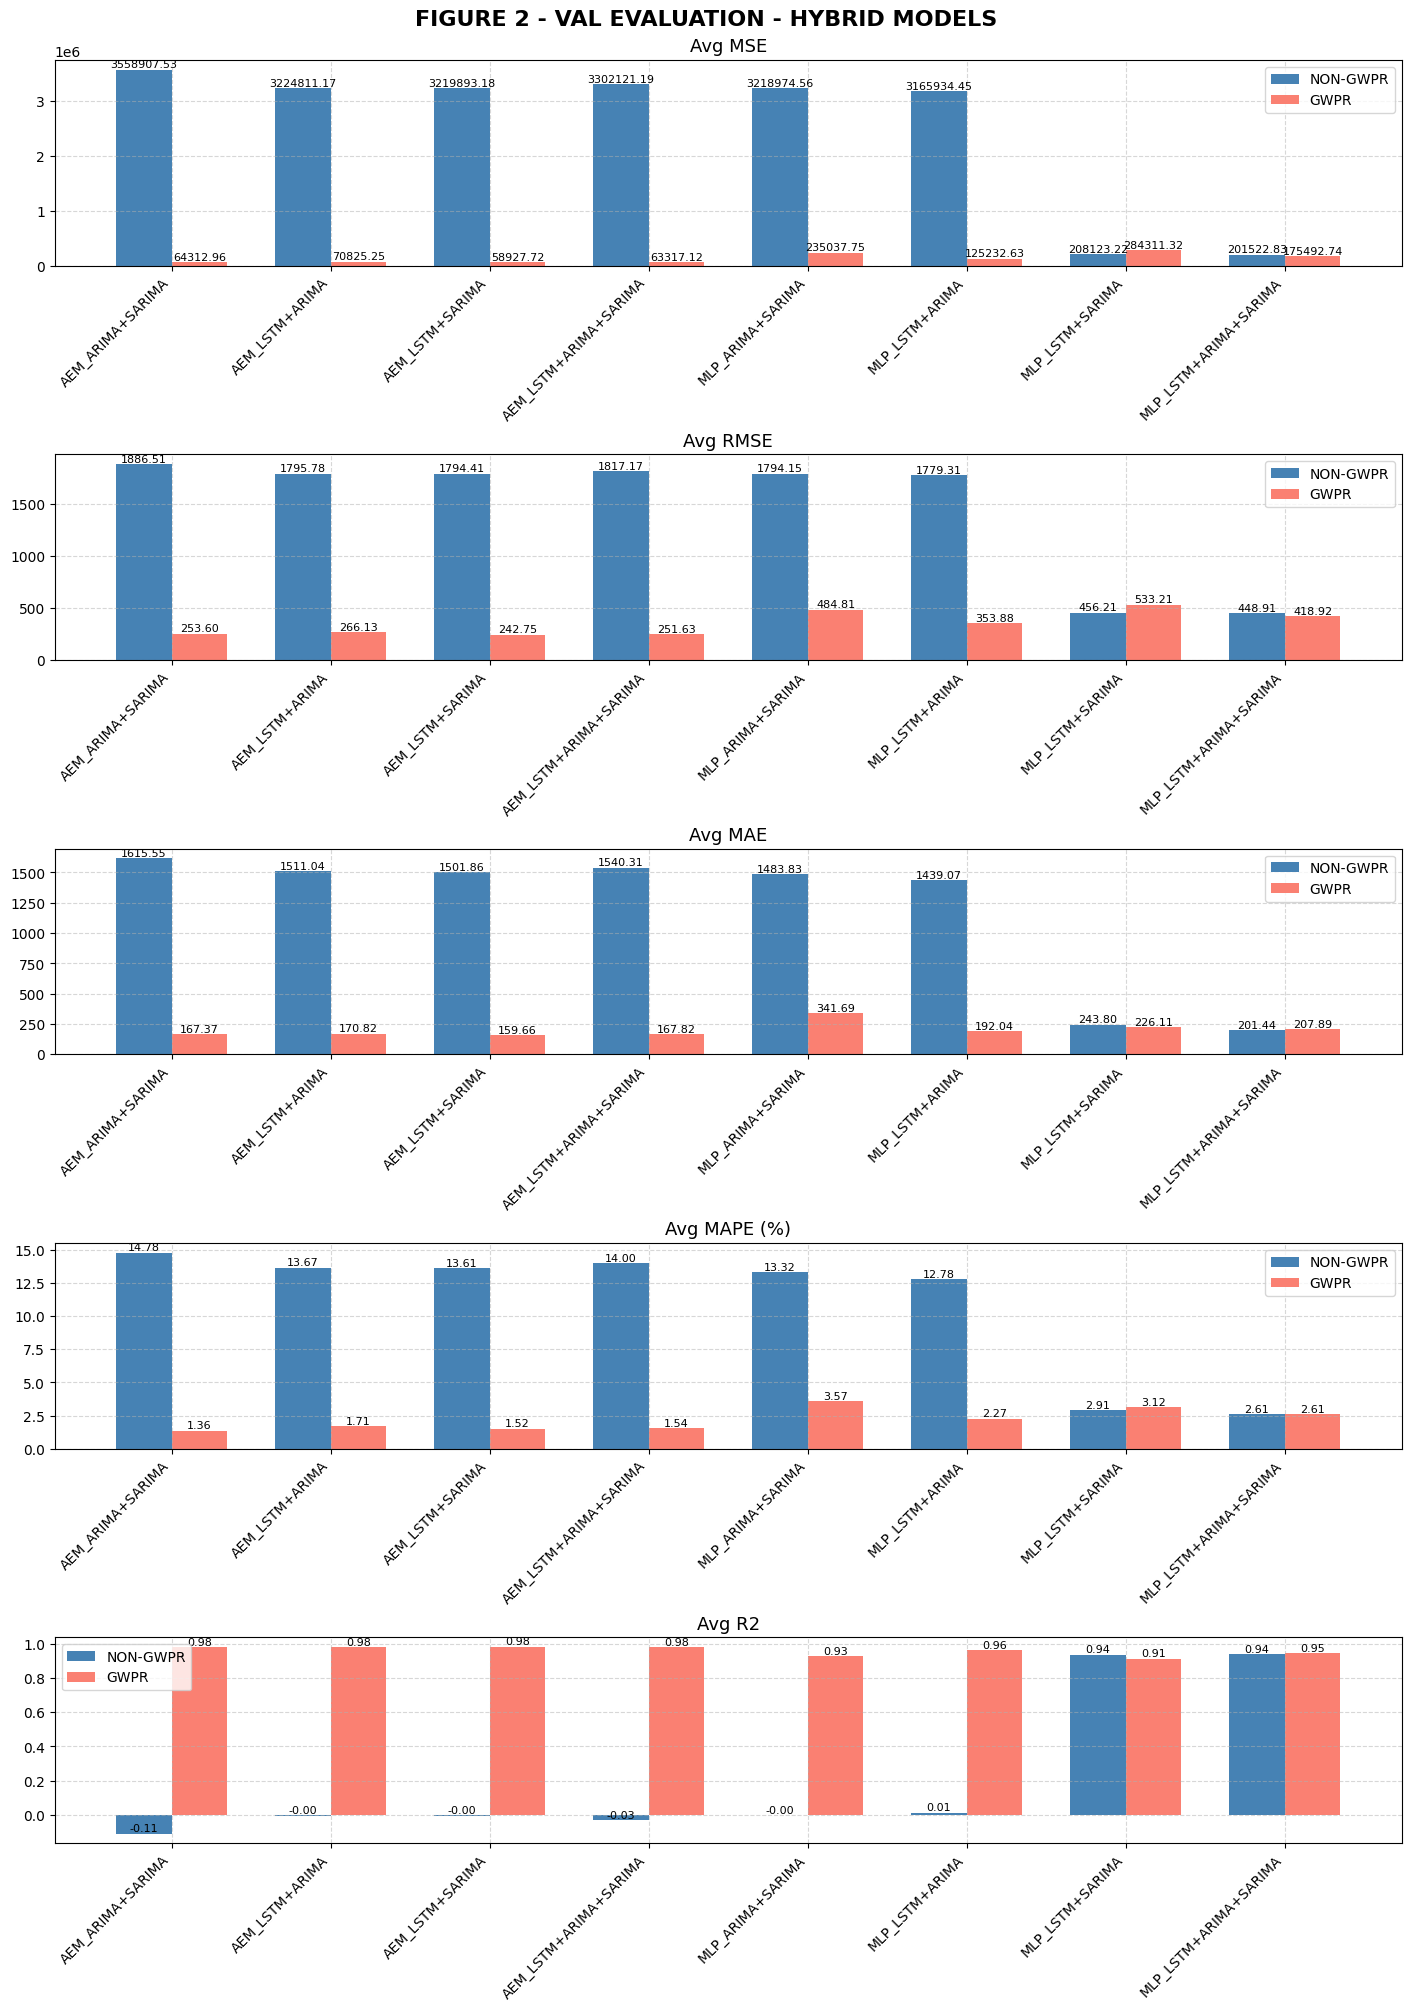

In [117]:
import matplotlib.pyplot as plt
import numpy as np

# === Daftar metrik dan model utama ===
metrics = ['Avg MSE', 'Avg RMSE', 'Avg MAE', 'Avg MAPE (%)', 'Avg R2']
model_labels = [
    'AEM_ARIMA+SARIMA', 'AEM_LSTM+ARIMA', 'AEM_LSTM+SARIMA', 'AEM_LSTM+ARIMA+SARIMA',
    'MLP_ARIMA+SARIMA', 'MLP_LSTM+ARIMA', 'MLP_LSTM+SARIMA', 'MLP_LSTM+ARIMA+SARIMA'
]

test_dfs = [
    df_AEM_arima_sarima_test, df_AEM_lstm_arima_test, df_AEM_lstm_sarima_test, df_AEM_lstm_arima_sarima_test,
    df_MLP_arima_sarima_test, df_MLP_lstm_arima_test, df_MLP_lstm_sarima_test, df_MLP_lstm_arima_sarima_test,
    df_AEM_arima_sarima_test_gwpr, df_AEM_lstm_arima_test_gwpr, df_AEM_lstm_sarima_test_gwpr, df_AEM_lstm_arima_sarima_test_gwpr,
    df_MLP_arima_sarima_test_gwpr, df_MLP_lstm_arima_test_gwpr, df_MLP_lstm_sarima_test_gwpr, df_MLP_lstm_arima_sarima_test_gwpr
]

val_dfs = [
    df_AEM_arima_sarima_val, df_AEM_lstm_arima_val, df_AEM_lstm_sarima_val, df_AEM_lstm_arima_sarima_val,
    df_MLP_arima_sarima_val, df_MLP_lstm_arima_val, df_MLP_lstm_sarima_val, df_MLP_lstm_arima_sarima_val,
    df_AEM_arima_sarima_val_gwpr, df_AEM_lstm_arima_val_gwpr, df_AEM_lstm_sarima_val_gwpr, df_AEM_lstm_arima_sarima_val_gwpr,
    df_MLP_arima_sarima_val_gwpr, df_MLP_lstm_arima_val_gwpr, df_MLP_lstm_sarima_val_gwpr, df_MLP_lstm_arima_sarima_val_gwpr
]

# === Fungsi plot dengan angka di atas bar ===
def plot_metric_bars_grouped(dfs, title):
    num_metrics = len(metrics)
    num_models = len(model_labels)
    x = np.arange(num_models)

    fig, axes = plt.subplots(nrows=num_metrics, ncols=1, figsize=(14, 4 * num_metrics), constrained_layout=True)

    for i, metric in enumerate(metrics):
        values_non_gwpr = [df[metric].values[0] for df in dfs[:8]]
        values_gwpr = [df[metric].values[0] for df in dfs[8:]]

        bar_width = 0.35
        bars1 = axes[i].bar(x - bar_width/2, values_non_gwpr, width=bar_width, label='NON-GWPR', color='steelblue')
        bars2 = axes[i].bar(x + bar_width/2, values_gwpr, width=bar_width, label='GWPR', color='salmon')

        # Tambahkan angka di atas bar
        for bar in bars1:
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

        for bar in bars2:
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

        axes[i].set_title(metric, fontsize=13)
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(model_labels, rotation=45, ha='right')
        axes[i].legend()
        axes[i].grid(True, linestyle='--', alpha=0.5)

    fig.suptitle(title, fontsize=16, fontweight='bold')
    plt.show()

# === Plot hasil test dan val ===
plot_metric_bars_grouped(test_dfs, 'FIGURE 1 - TEST EVALUATION - HYBRID MODELS')
plot_metric_bars_grouped(val_dfs, 'FIGURE 2 - VAL EVALUATION - HYBRID MODELS')


# REKAP TO EXCEL (STANDALONE & HYBRID - NON GWPR & GWPR)

In [119]:
import pandas as pd

# Daftar dataframe untuk validation dan test
test_dfs = [
    df_AEM_arima_sarima_test, df_AEM_lstm_arima_test, df_AEM_lstm_sarima_test, df_AEM_lstm_arima_sarima_test,
    df_MLP_arima_sarima_test, df_MLP_lstm_arima_test, df_MLP_lstm_sarima_test, df_MLP_lstm_arima_sarima_test,
    df_AEM_arima_sarima_test_gwpr, df_AEM_lstm_arima_test_gwpr, df_AEM_lstm_sarima_test_gwpr, df_AEM_lstm_arima_sarima_test_gwpr,
    df_MLP_arima_sarima_test_gwpr, df_MLP_lstm_arima_test_gwpr, df_MLP_lstm_sarima_test_gwpr, df_MLP_lstm_arima_sarima_test_gwpr
]

val_dfs = [
    df_AEM_arima_sarima_val, df_AEM_lstm_arima_val, df_AEM_lstm_sarima_val, df_AEM_lstm_arima_sarima_val,
    df_MLP_arima_sarima_val, df_MLP_lstm_arima_val, df_MLP_lstm_sarima_val, df_MLP_lstm_arima_sarima_val,
    df_AEM_arima_sarima_val_gwpr, df_AEM_lstm_arima_val_gwpr, df_AEM_lstm_sarima_val_gwpr, df_AEM_lstm_arima_sarima_val_gwpr,
    df_MLP_arima_sarima_val_gwpr, df_MLP_lstm_arima_val_gwpr, df_MLP_lstm_sarima_val_gwpr, df_MLP_lstm_arima_sarima_val_gwpr
]

# Gabungkan test dan validation data
dfs = test_dfs + val_dfs
model_names = [
    "AEM_arima_sarima_test", "AEM_lstm_arima_test", "AEM_lstm_sarima_test", "AEM_lstm_arima_sarima_test",
    "MLP_arima_sarima_test", "MLP_lstm_arima_test", "MLP_lstm_sarima_test", "MLP_lstm_arima_sarima_test",
    "AEM_arima_sarima_test_gwpr", "AEM_lstm_arima_test_gwpr", "AEM_lstm_sarima_test_gwpr", "AEM_lstm_arima_sarima_test_gwpr",
    "MLP_arima_sarima_test_gwpr", "MLP_lstm_arima_test_gwpr", "MLP_lstm_sarima_test_gwpr", "MLP_lstm_arima_sarima_test_gwpr",
    "AEM_arima_sarima_val", "AEM_lstm_arima_val", "AEM_lstm_sarima_val", "AEM_lstm_arima_sarima_val",
    "MLP_arima_sarima_val", "MLP_lstm_arima_val", "MLP_lstm_sarima_val", "MLP_lstm_arima_sarima_val",
    "AEM_arima_sarima_val_gwpr", "AEM_lstm_arima_val_gwpr", "AEM_lstm_sarima_val_gwpr", "AEM_lstm_arima_sarima_val_gwpr",
    "MLP_arima_sarima_val_gwpr", "MLP_lstm_arima_val_gwpr", "MLP_lstm_sarima_val_gwpr", "MLP_lstm_arima_sarima_val_gwpr"
]

# Kombinasikan semua dataframe secara vertikal
combined_df = pd.concat(dfs, keys=model_names)
combined_df.reset_index(level=0, inplace=True)
combined_df.rename(columns={'level_0': 'Model Name'}, inplace=True)

# Simpan ke Excel
file_name = "validation_test_data_hybrid.xlsx"
combined_df.to_excel(file_name, index=False)

print(f"Data telah berhasil disimpan dalam file: {file_name}")

Data telah berhasil disimpan dalam file: validation_test_data_hybrid.xlsx


In [120]:
import pandas as pd

# Daftar dataframe untuk versi ML
df_test_non_gwpr = [df_arima_test, df_sarima_test, df_adaboost_test, df_extratrees_test, df_gbr_test, df_rf_test, df_lstm_test]
df_test_gwpr = [df_arima_test_gwpr, df_sarima_test_gwpr, df_adaboost_test_gwpr, df_extratrees_test_gwpr, df_gbr_test_gwpr, df_rf_test_gwpr, df_lstm_test_gwpr]

df_val_non_gwpr = [df_arima_val, df_sarima_val, df_adaboost_val, df_extratrees_val, df_gbr_val, df_rf_val, df_lstm_val]
df_val_gwpr = [df_arima_val_gwpr, df_sarima_val_gwpr, df_adaboost_val_gwpr, df_extratrees_val_gwpr, df_gbr_val_gwpr, df_rf_val_gwpr, df_lstm_val_gwpr]

# Gabungkan semua dataframe
dfs = df_test_non_gwpr + df_test_gwpr + df_val_non_gwpr + df_val_gwpr
model_names = [
    "arima_test", "sarima_test", "adaboost_test", "extratrees_test", "gbr_test", "rf_test", "lstm_test",
    "arima_test_gwpr", "sarima_test_gwpr", "adaboost_test_gwpr", "extratrees_test_gwpr", "gbr_test_gwpr", "rf_test_gwpr", "lstm_test_gwpr",
    "arima_val", "sarima_val", "adaboost_val", "extratrees_val", "gbr_val", "rf_val", "lstm_val",
    "arima_val_gwpr", "sarima_val_gwpr", "adaboost_val_gwpr", "extratrees_val_gwpr", "gbr_val_gwpr", "rf_val_gwpr", "lstm_val_gwpr"
]

# Kombinasikan semua dataframe secara vertikal
combined_df = pd.concat(dfs, keys=model_names)
combined_df.reset_index(level=0, inplace=True)
combined_df.rename(columns={'level_0': 'Model Name'}, inplace=True)

# Simpan ke Excel
file_name = "validation_test_data_standalone.xlsx"
combined_df.to_excel(file_name, index=False)

print(f"Data telah berhasil disimpan dalam file: {file_name}")

Data telah berhasil disimpan dalam file: validation_test_data_standalone.xlsx


#Split Data

In [ ]:
# def build_plotmap(dbs, column):
#     # Set up figure and a single axis
#     f, ax = plt.subplots(1, figsize=(9, 9))
#     # Build choropleth
#     dbs.plot(
#         column=column,
#         cmap="viridis",
#         scheme="quantiles",
#         k=4,
#         edgecolor="white",
#         linewidth=0.0,
#         alpha=0.75,
#         legend=True,
#         legend_kwds=dict(loc=0),
#         ax=ax,
#     )
#     # Add basemap
#     contextily.add_basemap(
#         ax,
#         crs=dbs.crs,
#         source=contextily.providers.CartoDB.VoyagerNoLabels,
#     )
#     # Remove axes
#     ax.set_axis_off()
#     plt.title(column)
#     plt.figure(dpi=300)
#     plt.show()

In [ ]:
# def create_equation(dbs):
#     dbs_mean = dbs.groupby(level=0).agg(
#         Province=('Province', 'max'),
#         intercept=('intercept', 'mean'),
#         x1_coef=('x1_coef', 'mean'),
#         x2_coef=('x2_coef', 'mean'),
#         x3_coef=('x3_coef', 'mean'),
#         x1_significant=('x1_significant', 'mean'),
#         x2_significant=('x2_significant', 'mean'),
#         x3_significant=('x3_significant', 'mean'),)
#     for idx, row in dbs_mean.iterrows():
#         region = row['Province']
#         intercept = row['intercept']
#         x1_coef = row['x1_coef']
#         x2_coef = row['x2_coef']
#         x3_coef = row['x3_coef']
#         x1_sign = row['x1_significant']
#         x2_sign = row['x2_significant']
#         x3_sign = row['x3_significant']
#         print(f"Region {region}: y = {intercept:.4f} + {x1_coef:.4f}*x1 + {x2_coef:.4f}*x2 + {x3_coef:.4f}*x3")
#         print(f"x1_sign: {x1_sign:.4f}; x2_sign: {x2_sign:.4f}; x3_sign: {x3_sign:.4f}; ")